# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5 #0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 5


Using matplotlib, I look at the noisy time series I just simulated:

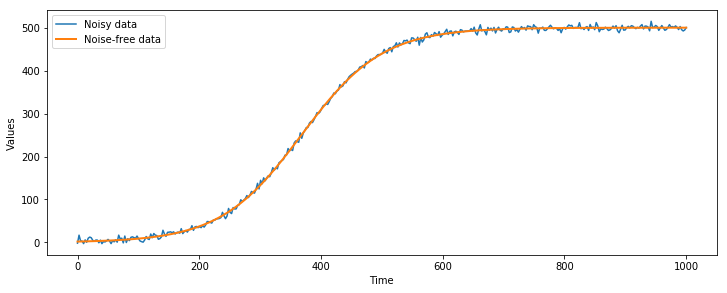

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

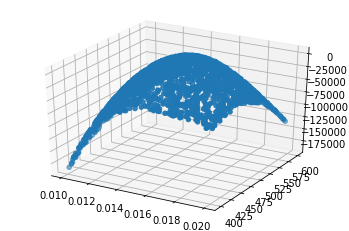

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
__________

In [15]:
emu([0.015, 500])

array([[-1302.9703]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1198.7504019375792

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


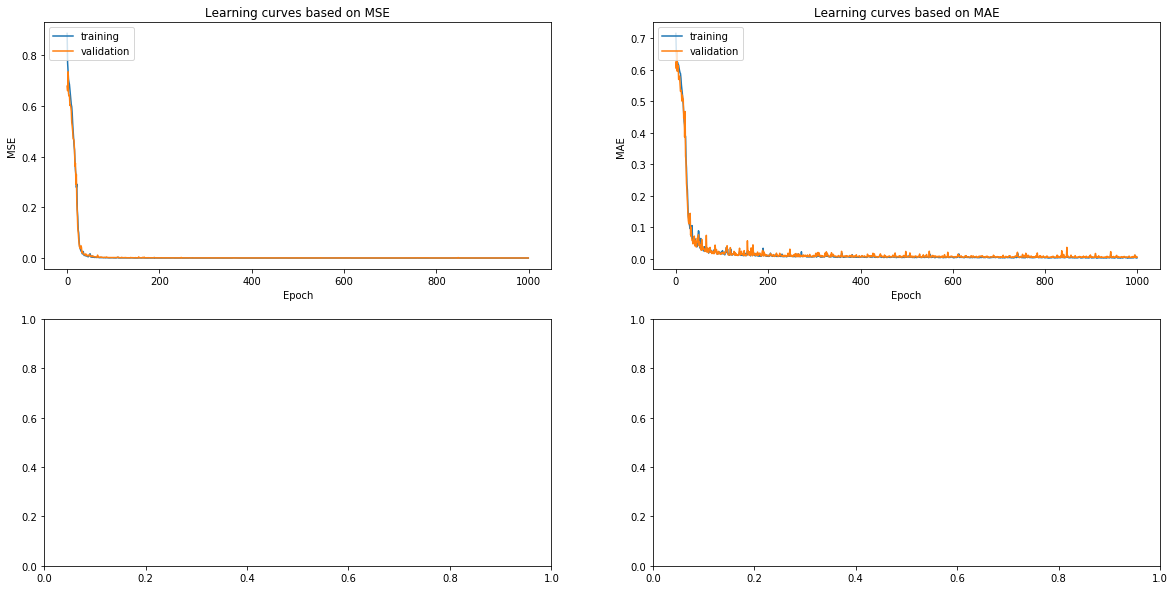

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 0.00038617588579654695
Best epoch based on validation MSE: 986


Minimum MAE during validation: 0.004656118222822745
Best epoch based on validation MAE: 989


0.00040326350358858083
0.00594611044973135


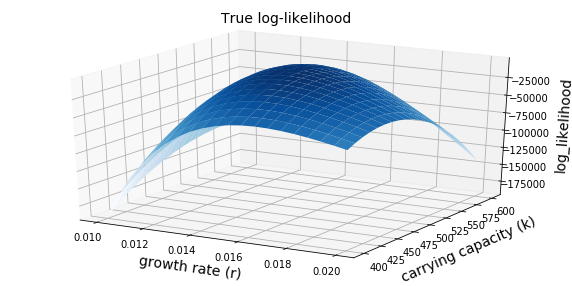

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

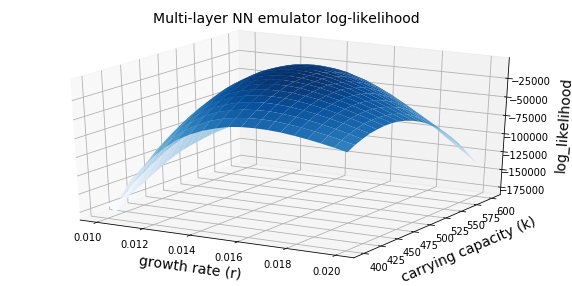

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.008009264925537456

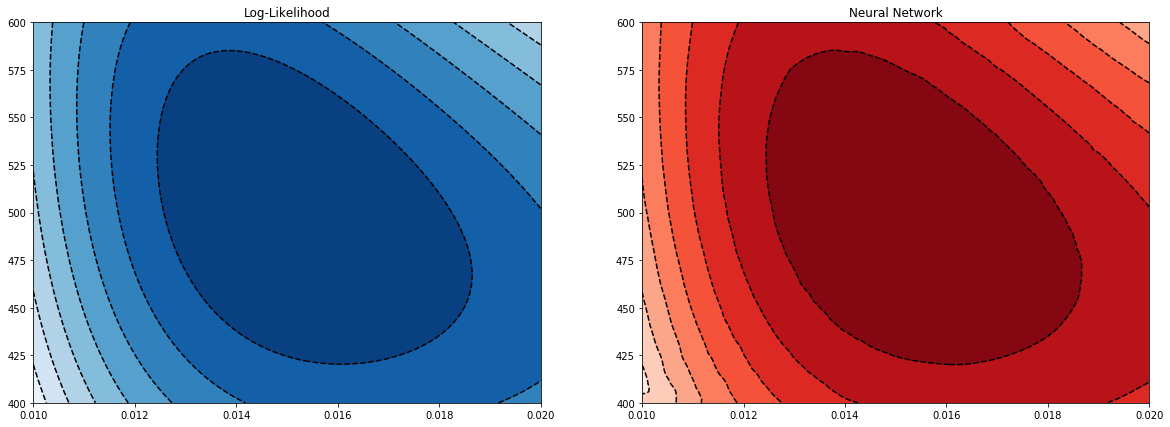

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

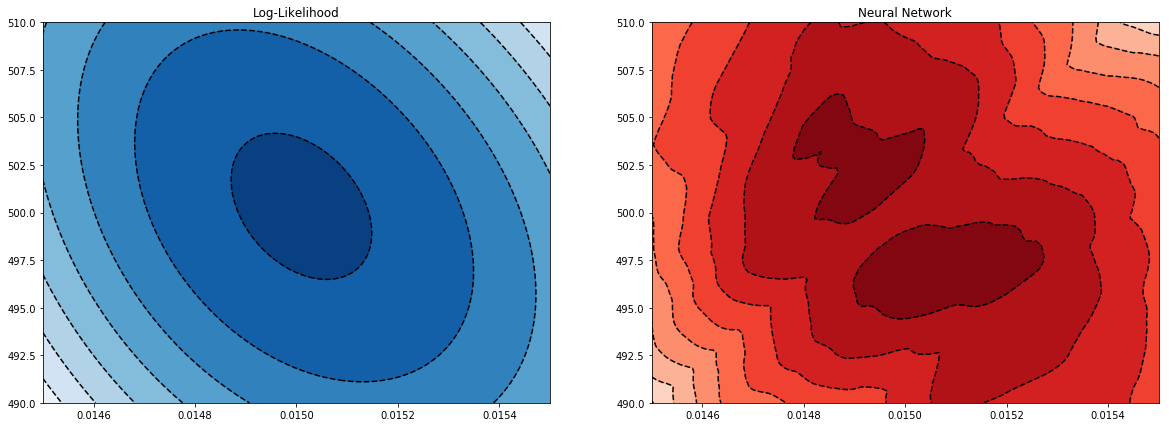

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[7.62865233e-03 4.52488678e+02]
-inf


[3.91679165e-03 5.24303093e+02]
-inf


[2.47882397e-02 5.77674067e+02]
-inf


[-4.04610621e-03  4.49679267e+02]
-inf


[3.31363752e-02 5.28354966e+02]
-inf


[1.27169191e-02 5.75990834e+02]
-28049.08033043609
accepted


[1.81259699e-02 4.51631937e+02]
-21560.055536897326
accepted


[6.39284420e-04 5.23838587e+02]
-inf


[4.59540068e-03 5.76970399e+02]
-inf


[2.78526860e-02 4.49826149e+02]
-inf


[2.00381303e-02 5.25155055e+02]
-inf


[7.99717639e-03 5.78650558e+02]
-inf


[1.75427071e-02 4.52592625e+02]
-16892.079493302364
accepted


[8.70629501e-03 5.22924529e+02]
-inf


[-1.58669810e-03  5.77075052e+02]
-inf


[3.42013318e-02 4.54995456e+02]
-inf


[1.85200151e-02 5.27505730e+02]
-40254.160269467044


[1.02374603e-02 5.78383575e+02]
-105036.87551352527


[1.16125276e-02 4.51372714e+02]
-71850.1558682029


[-1.39980079e-02  5.24916707e+02]
-inf


[2.55354610e-02 5.76372723e+02]
-inf


[2.96202231e-02 4.52166634e+02]
-inf


[1.53343966

[1.69872439e-02 4.63728962e+02]
-11085.938467225005


[1.28964810e-02 5.18922121e+02]
-16623.633415558284


[2.77695603e-02 5.73731722e+02]
-inf


[2.05565373e-02 4.59771084e+02]
-inf


[5.73187342e-03 5.18691678e+02]
-inf


[2.14680277e-02 5.73836245e+02]
-inf


[2.08245868e-02 4.56718720e+02]
-inf


[2.37127535e-02 5.20434270e+02]
-inf


[2.85532726e-02 5.79308596e+02]
-inf


[2.89710388e-02 4.60261836e+02]
-inf


[1.23194242e-02 5.19804317e+02]
-28128.55489641399


[-4.93896150e-03  5.75981887e+02]
-inf


[2.56529595e-02 4.62714578e+02]
-inf


[1.07925898e-02 5.22139591e+02]
-80924.91120472431


[2.58828953e-02 5.74679946e+02]
-inf


[1.92796344e-02 4.59054409e+02]
-31783.51080432795


[1.0140054e-02 5.1933377e+02]
-116784.82092793703


[4.18351833e-02 5.77900385e+02]
-inf


[2.41802085e-02 4.63727497e+02]
-inf


[1.26778771e-02 5.23422956e+02]
-20368.90674953589


[5.19892602e-04 5.78404180e+02]
-inf


[1.04818095e-02 4.57775753e+02]
-120840.30522462446


[2.68098005e-02 5.21881587

-6028.031703502128


[2.28946088e-02 5.73043556e+02]
-inf


[1.46027254e-02 4.61473197e+02]
-9077.599464477968


[1.41193166e-02 5.16709777e+02]
-3763.681720459069


[4.68823908e-04 5.71288961e+02]
-inf


[-1.37749186e-03  4.60052348e+02]
-inf


[7.61101642e-03 5.22118986e+02]
-inf


[1.77116267e-02 5.74431368e+02]
-61047.52584871502


[5.04469136e-03 4.62453390e+02]
-inf


[1.97693222e-03 5.19296359e+02]
-inf


[2.66101981e-02 5.73941644e+02]
-inf


[2.66191389e-02 4.60299868e+02]
-inf


[3.70659405e-02 5.18359079e+02]
-inf


[1.96013525e-02 5.72642743e+02]
-97546.4889344905


[2.28130539e-02 4.65249186e+02]
-inf


[2.17533431e-02 5.21531958e+02]
-inf


[1.03805218e-02 5.73498783e+02]
-97482.53609201797


[1.56846406e-02 4.59492148e+02]
-7298.668501354137


[1.53084839e-02 5.15531202e+02]
-2808.5272598081538


[3.65181608e-02 5.74960361e+02]
-inf


[1.02935071e-02 4.59881891e+02]
-130693.06323089075


[2.45606756e-02 5.20401702e+02]
-inf


[-1.88020738e-02  5.74412802e+02]
-inf


[1.3



[1.47274809e-02 5.17459274e+02]
-2234.0147290507075


[1.39334927e-02 5.73131985e+02]
-18957.28761500382


[1.58570371e-02 4.69370021e+02]
-5155.156229974763


[1.45236831e-02 5.17359056e+02]
-2445.2393719632773


[1.41986689e-02 5.73096483e+02]
-19021.858404076047


[1.52710530e-02 4.70235821e+02]
-4511.451528607895
accepted


[1.47340220e-02 5.17464397e+02]
-2232.3319389772814


[1.41950848e-02 5.73161776e+02]
-19048.960928067732


[1.55692142e-02 4.71020298e+02]
-4373.726785884247
accepted


[1.48675650e-02 5.17388908e+02]
-2239.8237783341206


[1.41051683e-02 5.73197084e+02]
-18974.77402930418


[1.55966108e-02 4.69593461e+02]
-4693.0547153183825


[1.49310265e-02 5.17394049e+02]
-2289.6419293323906


[1.41777848e-02 5.73144249e+02]
-19017.71938577404


[1.55046110e-02 4.72885113e+02]
-3956.7341390112333
accepted


[1.47490611e-02 5.17325434e+02]
-2212.183356180618
accepted


[1.40386186e-02 5.73115208e+02]
-18911.29077455711
accepted


[1.51882713e-02 4.73756754e+02]
-3818.71908

[1.50086126e-02 5.12921653e+02]
-1845.2103508465418


[1.44546107e-02 5.70003099e+02]
-18062.661073210067


[1.50513088e-02 4.96155776e+02]
-1260.4944129637165


[1.51538689e-02 5.09487002e+02]
-1719.0404535260247
accepted


[1.45530392e-02 5.69177791e+02]
-17980.02271069744
accepted


[1.49134818e-02 5.04322713e+02]
-1260.748987705582


[1.5032349e-02 5.1235534e+02]
-1814.5821570381834


[1.42112042e-02 5.71588995e+02]
-18305.65619609433


[1.50599002e-02 4.95389369e+02]
-1285.3658337376976


[1.51035207e-02 5.10022470e+02]
-1688.1700311993404
accepted


[1.44066108e-02 5.70224743e+02]
-18034.92770530605


[1.49284363e-02 5.04081565e+02]
-1251.4037586902175


[1.51146729e-02 5.10138757e+02]
-1714.613290182446


[1.43918049e-02 5.70330858e+02]
-18048.077656222955


[1.49499175e-02 4.93848313e+02]
-1411.4173480333156


[1.51937968e-02 5.07605661e+02]
-1634.2555858068674
accepted


[1.46402260e-02 5.68701845e+02]
-18084.29858622718


[1.49105568e-02 4.97357385e+02]
-1288.702819329192


[

-1207.5701658290382


[1.37573895e-02 5.66405387e+02]
-16443.016847028186


[1.49930923e-02 5.00303498e+02]
-1199.3451505345713
accepted


[1.50580076e-02 4.96170948e+02]
-1259.6650231880933


[1.38891827e-02 5.65385042e+02]
-15695.154810084665
accepted


[1.49700986e-02 5.00873050e+02]
-1202.728080936444


[1.50496358e-02 4.98456776e+02]
-1211.659928502025


[1.37719337e-02 5.64379823e+02]
-15618.160253506792
accepted


[1.49950784e-02 4.99579292e+02]
-1202.2175517824521


[1.49417693e-02 4.99664644e+02]
-1218.075540232062


[1.41959788e-02 5.63615795e+02]
-14701.593075017478
accepted


[1.49935501e-02 5.00319177e+02]
-1199.2792472465433
accepted


[1.49942908e-02 4.99584999e+02]
-1202.294100329974


[1.40061427e-02 5.62801689e+02]
-14471.991761654432
accepted


[1.49692037e-02 5.00567448e+02]
-1202.9120283739742


[1.49924923e-02 4.96904829e+02]
-1251.5562661491722


[1.35441965e-02 5.60930589e+02]
-15427.327347932045


[1.49684344e-02 5.00730357e+02]
-1202.98257938858


[1.51091818e


[1.50235540e-02 4.99534052e+02]
-1200.7985716018245
accepted


[1.50045177e-02 4.99316209e+02]
-1203.0752773557067


[1.53823867e-02 5.09387803e+02]
-2243.8385326557977


[1.50233766e-02 4.99154189e+02]
-1203.3638854716105


[1.50356813e-02 5.00170061e+02]
-1200.5711543832183


[1.39072992e-02 5.19420179e+02]
-5136.003220973413


[1.50078116e-02 4.99737283e+02]
-1199.9881396036797
accepted


[1.50178544e-02 5.00176406e+02]
-1198.7865331410853
accepted


[1.53846517e-02 4.77614827e+02]
-3064.864832363315


[1.50116917e-02 4.99139054e+02]
-1203.9887591685356


[1.50230990e-02 4.99818218e+02]
-1199.6283714823192


[1.4355769e-02 4.9968868e+02]
-2659.0184087040548


[1.50226884e-02 4.99430457e+02]
-1201.3670242738478
accepted


[1.50347145e-02 5.01794102e+02]
-1212.6910230750957


[1.32176641e-02 6.04355425e+02]
-inf


[1.50318971e-02 4.98834227e+02]
-1206.4031912917471


[1.49865774e-02 5.00142485e+02]
-1200.5519513418205


[1.42751770e-02 5.19160224e+02]
-3272.1574089965698


[1.5029275


[1.50006787e-02 4.99831020e+02]
-1200.060885976546


[1.51153337e-02 4.92308656e+02]
-1426.6297646619275


[1.50244662e-02 4.99645004e+02]
-1200.3079246631933


[1.50132529e-02 5.00615134e+02]
-1199.0786203378923


[1.51995179e-02 4.92116295e+02]
-1458.0779593063176


[1.4988273e-02 5.0032147e+02]
-1199.867441109906
accepted


[1.50114203e-02 5.00218175e+02]
-1198.5940425859383
accepted


[1.47221051e-02 5.04214575e+02]
-1432.4405943753204


[1.49993844e-02 5.00342261e+02]
-1198.8125587860186
accepted


[1.50227966e-02 5.00136203e+02]
-1199.091960923726


[1.50193603e-02 4.98793986e+02]
-1207.0789282606572
accepted


[1.50030181e-02 5.00725538e+02]
-1199.1320268736588
accepted


[1.50272182e-02 4.99375910e+02]
-1201.8176081082531


[1.57679211e-02 4.81199440e+02]
-3206.164064295527


[1.50161402e-02 5.00236717e+02]
-1198.6994451066373
accepted


[1.50249854e-02 5.00247920e+02]
-1199.298232912917
accepted


[1.48095234e-02 5.08230737e+02]
-1447.7690580458718


[1.50270984e-02 5.0019901

[1.50099497e-02 5.00291058e+02]
-1198.5568042573482
accepted


[1.49752598e-02 5.00476544e+02]
-1201.7451499225626


[1.50140814e-02 4.99976148e+02]
-1198.9725655741117
accepted


[1.50186791e-02 5.00696248e+02]
-1199.743953352157


[1.50065862e-02 5.00510649e+02]
-1198.6799652319248
accepted


[1.49276419e-02 5.02060743e+02]
-1219.9658900169477


[1.50024697e-02 5.01672268e+02]
-1205.4243651215295


[1.50020212e-02 5.00157085e+02]
-1198.8942048803874
accepted


[1.50040702e-02 4.96227201e+02]
-1268.589079273731


[1.50310122e-02 4.99424331e+02]
-1201.728626467501


[1.50034488e-02 5.00542835e+02]
-1198.74427027017
accepted


[1.50471324e-02 4.98071428e+02]
-1216.6856253506774


[1.50015094e-02 4.99729917e+02]
-1200.493379872398


[1.49948592e-02 5.00834358e+02]
-1199.6438164687493


[1.49200213e-02 5.02450831e+02]
-1226.2429219614085


[1.50164957e-02 4.99600010e+02]
-1200.3966568914163


[1.49976947e-02 5.00040182e+02]
-1199.5127400182848
accepted


[1.49850975e-02 5.00366319e+02]
-1

-1217.1850240017293


[1.50250360e-02 4.99741859e+02]
-1199.9673704425797
accepted


[1.50349996e-02 4.99557183e+02]
-1201.4240384162465


[1.50171281e-02 4.99748460e+02]
-1199.7103181867174


[1.50318633e-02 4.99955758e+02]
-1200.0643864029526
accepted


[1.50303544e-02 5.00605649e+02]
-1200.8496650484187
accepted


[1.50360906e-02 4.99933558e+02]
-1200.6196238610116


[1.50193055e-02 4.99863674e+02]
-1199.3526448083464
accepted


[1.50640822e-02 4.99945213e+02]
-1206.9358521983747


[1.50303160e-02 5.00126192e+02]
-1199.8103234369303
accepted


[1.50162128e-02 4.99674880e+02]
-1200.0286906624199
accepted


[1.49934095e-02 4.99033066e+02]
-1207.6831367629088


[1.50542946e-02 4.98401500e+02]
-1212.8431451844715


[1.50207199e-02 4.99651176e+02]
-1200.1655129291887
accepted


[1.50117329e-02 5.00692851e+02]
-1199.2367121049658
accepted


[1.49989433e-02 5.00062535e+02]
-1199.33481888071
accepted


[1.50619199e-02 4.99359061e+02]
-1206.9007498181602


[1.50064899e-02 5.00800140e+02]
-11

[1.49586771e-02 5.00870947e+02]
-1205.4005387307186


[1.50057267e-02 4.99187681e+02]
-1204.1005240001416


[1.49893878e-02 5.01183416e+02]
-1201.382021807639


[1.49473111e-02 5.00387786e+02]
-1210.1249281059925


[1.50212855e-02 5.01191383e+02]
-1203.0408950925423


[1.50168649e-02 4.99813310e+02]
-1199.4669834807885
accepted


[1.49916421e-02 5.02354371e+02]
-1213.4501196146446


[1.50215145e-02 5.01456769e+02]
-1205.5300384509517


[1.50045549e-02 5.00578778e+02]
-1198.7895778254524
accepted


[1.49539412e-02 5.00824291e+02]
-1206.7641301163783


[1.49917395e-02 5.01430401e+02]
-1202.9196217465565


[1.49713191e-02 5.01434905e+02]
-1204.5656433905272


[1.50209963e-02 5.00131865e+02]
-1198.9738824971191
accepted


[1.50235076e-02 5.00360600e+02]
-1199.2867569124887


[1.5030173e-02 4.9949384e+02]
-1201.3103509469827


[1.49797454e-02 5.02053135e+02]
-1209.2666144378284


[1.50059033e-02 5.01432976e+02]
-1203.3626745237755


[1.50171910e-02 5.00595682e+02]
-1199.2749522462318
accept

[1.49753730e-02 5.01041656e+02]
-1202.1820260886896


[1.50405960e-02 4.99389936e+02]
-1202.801211478959


[1.50014991e-02 5.00975926e+02]
-1200.075533421264
accepted


[1.49647053e-02 5.00304897e+02]
-1204.7138735807482


[1.50215597e-02 5.01081259e+02]
-1202.2322242388389


[1.49896587e-02 5.01060187e+02]
-1200.7584688021511
accepted


[1.49981787e-02 5.00659512e+02]
-1199.0749916094362
accepted


[1.49843176e-02 4.99353578e+02]
-1206.191117595644


[1.49946315e-02 5.00691446e+02]
-1199.3056276440052
accepted


[1.50445451e-02 5.00300527e+02]
-1202.4879855866893


[1.50070775e-02 4.99989433e+02]
-1199.0538938378347
accepted


[1.49907926e-02 5.01064182e+02]
-1200.7141489022465
accepted


[1.50203569e-02 5.00129675e+02]
-1198.9375453918963
accepted


[1.50034566e-02 5.00282434e+02]
-1198.6626286860912
accepted


[1.49918324e-02 5.01524487e+02]
-1203.6738096029142


[1.49798690e-02 5.00149318e+02]
-1201.701523955532
accepted


[1.50650071e-02 5.00023859e+02]
-1207.3775507961975


[1.49

[1.49823273e-02 4.99942042e+02]
-1202.1562240639398


[1.50670832e-02 4.99854223e+02]
-1207.7750372373123


[1.50453481e-02 4.99830253e+02]
-1202.2241144745115


[1.50446560e-02 5.00006192e+02]
-1202.0401207277089


[1.50091123e-02 5.00816425e+02]
-1199.570076075522
accepted


[1.50519388e-02 5.00354309e+02]
-1204.4878423178945


[1.50263995e-02 5.00961324e+02]
-1202.1361241200782


[1.50240657e-02 5.01261905e+02]
-1204.094549022413


[1.50279075e-02 5.00749294e+02]
-1201.1272327987112


[1.49739376e-02 5.00892468e+02]
-1202.0483575583794


[1.50010627e-02 5.01677850e+02]
-1205.386334837409


[1.50078903e-02 4.99961652e+02]
-1199.105334628231


[1.49645123e-02 4.99967759e+02]
-1206.5059551617778


[1.50006811e-02 5.00512101e+02]
-1198.7782253305077
accepted


[1.50054756e-02 4.99888090e+02]
-1199.465856299163


[1.50278508e-02 5.00031086e+02]
-1199.5749295709586
accepted


[1.50000686e-02 5.01164669e+02]
-1201.087889385792


[1.50287928e-02 4.99578408e+02]
-1200.8243449839708


[1.5011

[1.50264411e-02 5.01489405e+02]
-1206.8179739153666


[1.49901328e-02 5.01570314e+02]
-1204.0815220691445


[1.49915661e-02 4.99062335e+02]
-1207.7215560685513


[1.50498816e-02 5.00839606e+02]
-1206.6921066872728


[1.50001220e-02 5.00748288e+02]
-1199.226541118367
accepted


[1.49681743e-02 4.99522962e+02]
-1208.9953931684718


[1.50321143e-02 5.00807383e+02]
-1202.1641737743287


[1.50025949e-02 5.00263362e+02]
-1198.7134590444325
accepted


[1.50082385e-02 5.00258983e+02]
-1198.570724418134
accepted


[1.50032584e-02 5.00678255e+02]
-1199.0060192927442
accepted


[1.50575378e-02 4.99319662e+02]
-1206.0186449393289


[1.49937530e-02 5.00180649e+02]
-1199.5115894274231
accepted


[1.49978304e-02 5.00761365e+02]
-1199.3205514785361
accepted


[1.49674103e-02 5.00959863e+02]
-1203.4073273199554


[1.49870400e-02 5.00561239e+02]
-1199.8364614811999


[1.49857951e-02 4.98524397e+02]
-1216.765877647191


[1.49918291e-02 4.99481962e+02]
-1203.4915309227658


[1.50105035e-02 4.99564752e+02]

[1.50320537e-02 4.99395589e+02]
-1201.9579562447207


[1.49736933e-02 4.99686595e+02]
-1205.8897341771578


[1.49845285e-02 4.99081287e+02]
-1209.1357094378625


[1.50085409e-02 4.99976769e+02]
-1199.0401969411162
accepted


[1.50046664e-02 5.00042573e+02]
-1199.0135383263378
accepted


[1.49821781e-02 5.00553582e+02]
-1200.479757649289


[1.50015311e-02 5.00543711e+02]
-1198.7854735818112
accepted


[1.49820451e-02 5.00533841e+02]
-1200.5071811145167


[1.49879813e-02 4.99556025e+02]
-1203.6021116252757


[1.49958682e-02 5.00102471e+02]
-1199.4993609008745


[1.49707139e-02 4.98886818e+02]
-1215.9800233330768


[1.49346911e-02 5.01034875e+02]
-1213.561751031291


[1.49639631e-02 5.00610728e+02]
-1204.1324434422982


[1.50709135e-02 5.00647952e+02]
-1212.6939089818782


[1.49671538e-02 4.99530424e+02]
-1209.25281909252


[1.49894046e-02 5.01051609e+02]
-1200.73590676967


[1.50325806e-02 4.98408044e+02]
-1211.498918384297


[1.49931340e-02 5.00346079e+02]
-1199.2874720007978
accepted



[1.49987500e-02 5.00439901e+02]
-1198.8253794617524
accepted


[1.50185845e-02 5.00520873e+02]
-1199.1801637079473
accepted


[1.49780689e-02 5.00926571e+02]
-1201.469271259482
accepted


[1.49615617e-02 5.01833473e+02]
-1208.9736242226566


[1.50244118e-02 5.02124917e+02]
-1214.9469611245531


[1.49966545e-02 4.99890664e+02]
-1200.1950710918884
accepted


[1.50347306e-02 4.99232555e+02]
-1203.1553683062439


[1.50149385e-02 5.00588200e+02]
-1199.1003768812986
accepted


[1.49466488e-02 5.00889600e+02]
-1209.1038309880182


[1.49819280e-02 5.00325684e+02]
-1200.8011990394891
accepted


[1.50377386e-02 4.99744558e+02]
-1201.1465175998264


[1.50034115e-02 5.00726934e+02]
-1199.13553855834
accepted


[1.49627104e-02 5.01036570e+02]
-1204.5846344109348


[1.49876114e-02 5.01707598e+02]
-1205.370082721491


[1.49930596e-02 5.00088541e+02]
-1199.8456241490196


[1.49914174e-02 5.00851902e+02]
-1199.8845598277028
accepted


[1.49809323e-02 5.01200352e+02]
-1202.1131715308543


[1.49252488e-0

-1217.8996376785556


[1.49763959e-02 4.98800732e+02]
-1215.3166883903677


[1.50073719e-02 4.98144735e+02]
-1218.1263005649796


[1.49883184e-02 5.00791899e+02]
-1199.9721834440536


[1.50423461e-02 5.00298928e+02]
-1202.0124204098101


[1.49979501e-02 5.01008221e+02]
-1200.2320071995719
accepted


[1.49994194e-02 4.99141509e+02]
-1205.4053632974417


[1.49934640e-02 5.01080103e+02]
-1200.677143788885


[1.49931151e-02 5.01836270e+02]
-1206.7233185527


[1.50325519e-02 5.00422605e+02]
-1200.5626853353594


[1.49821992e-02 4.99726730e+02]
-1203.5072323095437


[1.50057001e-02 4.99273138e+02]
-1203.321705162511


[1.50427540e-02 4.99308274e+02]
-1203.4966114110696


[1.49630761e-02 5.01706929e+02]
-1207.7049341414008


[1.50008169e-02 5.00733241e+02]
-1199.1733199954924
accepted


[1.49879640e-02 5.00462413e+02]
-1199.7472371666324


[1.50210305e-02 5.00355441e+02]
-1199.0626827225274
accepted


[1.50353957e-02 4.99731450e+02]
-1200.8854542932586


[1.49871972e-02 4.99454915e+02]
-1204.

[1.49873835e-02 5.01254188e+02]
-1201.8883001102797
accepted


[1.50538687e-02 4.99699868e+02]
-1204.1495879022902


[1.50322324e-02 5.02104663e+02]
-1216.7396390996253


[1.49093866e-02 5.01227268e+02]
-1225.6795070229712


[1.49964439e-02 5.01160741e+02]
-1201.0502304418408
accepted


[1.50371001e-02 4.98898288e+02]
-1205.9891710194258


[1.49851591e-02 5.01136701e+02]
-1201.4222230691475
accepted


[1.49349279e-02 5.03192024e+02]
-1231.7325371924037


[1.50112335e-02 5.00780942e+02]
-1199.530187321431
accepted


[1.50151388e-02 5.01279725e+02]
-1202.9401854207763


[1.50170941e-02 5.00583909e+02]
-1199.233665809603
accepted


[1.49769277e-02 4.99830587e+02]
-1204.001779821945


[1.49998145e-02 5.01689647e+02]
-1205.433289406468


[1.50315009e-02 5.01470103e+02]
-1207.7283175012556


[1.50279524e-02 4.99426758e+02]
-1201.5455255163358


[1.49445925e-02 5.00247973e+02]
-1211.9331502598113


[1.49044554e-02 5.01438907e+02]
-1228.420188635115


[1.50130240e-02 5.01100813e+02]
-1201.3685

[1.49570056e-02 4.99591104e+02]
-1212.2659729275722


[1.50247586e-02 4.99192521e+02]
-1203.0545328594585


[1.49546144e-02 4.99578749e+02]
-1213.3379873655822


[1.50340241e-02 5.00041013e+02]
-1200.2789895034546
accepted


[1.50178032e-02 4.98889212e+02]
-1206.1003984037466


[1.49899319e-02 5.01364413e+02]
-1202.4803317608057


[1.50319510e-02 4.99926309e+02]
-1200.1091937892647
accepted


[1.50281792e-02 5.01513677e+02]
-1207.4610888190302


[1.5057621e-02 4.9915789e+02]
-1206.8145644740107


[1.49954917e-02 5.00375030e+02]
-1199.0563432152555
accepted


[1.50343432e-02 5.00486620e+02]
-1201.059366502771


[1.49769070e-02 5.00376975e+02]
-1201.603614112422


[1.50461244e-02 4.99593732e+02]
-1202.8166929998256


[1.50145330e-02 5.00707935e+02]
-1199.4535715451439


[1.50539367e-02 4.99704226e+02]
-1204.1594396896535


[1.49948771e-02 5.00243270e+02]
-1199.2693803734908
accepted


[1.50006628e-02 5.00094355e+02]
-1199.11741706694


[1.49998337e-02 5.00082234e+02]
-1199.2090869688698


-1206.3061205777913


[1.50045568e-02 5.01470874e+02]
-1203.6048036657687


[1.50133472e-02 5.00320622e+02]
-1198.6175340524778
accepted


[1.50796625e-02 4.99819392e+02]
-1212.2620078115442


[1.50125142e-02 4.99912574e+02]
-1199.1481550297324
accepted


[1.50441567e-02 4.99813065e+02]
-1202.0251678981333


[1.50147810e-02 4.99993239e+02]
-1198.939116183382
accepted


[1.50347921e-02 4.99634823e+02]
-1201.1108681881012


[1.50039028e-02 5.00393603e+02]
-1198.6182472932271
accepted


[1.50295725e-02 4.99721628e+02]
-1200.3380186206914
accepted


[1.50258897e-02 4.99692632e+02]
-1200.1883839364245


[1.49573318e-02 4.99958944e+02]
-1208.9444146975807


[1.50182907e-02 4.99957134e+02]
-1199.0880590071486
accepted


[1.50233319e-02 5.01153527e+02]
-1203.052945510564


[1.50014859e-02 5.00199955e+02]
-1198.8495227496496
accepted


[1.50127900e-02 4.98848464e+02]
-1206.9563048908983


[1.50402828e-02 4.99648383e+02]
-1201.7446713125614


[1.50238134e-02 5.00300422e+02]
-1199.2363439732894
a

-1208.0172863452847


[1.49438968e-02 5.00660527e+02]
-1210.4596193426257


[1.49754536e-02 5.01224208e+02]
-1202.8752133046937


[1.50049908e-02 5.00257541e+02]
-1198.6321638891436
accepted


[1.50015427e-02 5.02091899e+02]
-1210.4526964780177


[1.49663119e-02 5.00144959e+02]
-1204.9592793973468


[1.50457656e-02 4.98882883e+02]
-1206.8689460099474


[1.49970307e-02 4.99176889e+02]
-1205.4259108605725


[1.50238862e-02 5.00261523e+02]
-1199.2069492470118
accepted


[1.50218011e-02 5.00010397e+02]
-1199.1411517979602
accepted


[1.49889852e-02 5.01566923e+02]
-1204.072043438544


[1.50413135e-02 5.01241378e+02]
-1207.8051212971247


[1.50472098e-02 4.99299092e+02]
-1204.1760424679323


[1.49546281e-02 4.99669380e+02]
-1212.4136056061493


[1.50182255e-02 4.99632554e+02]
-1200.225061520674


[1.49964848e-02 5.00440374e+02]
-1198.9613657351208
accepted


[1.49620232e-02 5.01129844e+02]
-1204.9637310888447


[1.50451784e-02 4.98266135e+02]
-1213.7526556950263


[1.50397261e-02 4.99652873

[1.49823302e-02 5.01107499e+02]
-1201.548967307158


[1.49832027e-02 4.99092658e+02]
-1209.3401256289496


[1.49788205e-02 5.00890462e+02]
-1201.280031144745


[1.49727134e-02 5.00930105e+02]
-1202.332465673119


[1.49587969e-02 5.02584896e+02]
-1217.9169305550806


[1.4990188e-02 5.0051322e+02]
-1199.4896294664677


[1.49813114e-02 5.00749750e+02]
-1200.6944884915092


[1.49527213e-02 5.01665329e+02]
-1209.5695655807076


[1.50055216e-02 4.99355322e+02]
-1202.643789452714


[1.50327656e-02 5.00158852e+02]
-1200.1364684984067


[1.50265087e-02 5.00873915e+02]
-1201.5993395161283


[1.49833442e-02 5.01151037e+02]
-1201.6452003077065


[1.49945618e-02 5.00874279e+02]
-1199.7842742347643
accepted


[1.49405608e-02 5.01470647e+02]
-1212.1130752833383


[1.50024823e-02 5.00632417e+02]
-1198.9103076808285


[1.50208447e-02 5.00891849e+02]
-1200.9121169724979


[1.49622455e-02 5.00203586e+02]
-1205.8633392172414


[1.50381782e-02 5.00860186e+02]
-1203.7567809488578


[1.50451740e-02 4.9966178

[1.50027178e-02 4.98674659e+02]
-1210.539370622262


[1.50179504e-02 5.00470094e+02]
-1199.0208068387824
accepted


[1.50001795e-02 5.00947130e+02]
-1199.9393401820773


[1.50676887e-02 4.99314623e+02]
-1208.590244420529


[1.50484954e-02 5.00296420e+02]
-1203.3972544352737


[1.50019840e-02 5.00534628e+02]
-1198.7628343411163
accepted


[1.50290657e-02 5.01126371e+02]
-1203.846108863794


[1.50170026e-02 5.00408544e+02]
-1198.8557560580523
accepted


[1.49784531e-02 5.01289897e+02]
-1202.8358734005424


[1.49952119e-02 5.00417600e+02]
-1199.0572538820559
accepted


[1.5004572e-02 5.0015578e+02]
-1198.774543857279
accepted


[1.50055011e-02 5.00541014e+02]
-1198.7240715389328
accepted


[1.50207413e-02 5.00695552e+02]
-1199.9464188869545
accepted


[1.50281750e-02 5.00436778e+02]
-1199.9710777625596


[1.49577892e-02 5.02163331e+02]
-1212.7818470913444


[1.50667999e-02 5.01800545e+02]
-1225.1144518615674


[1.4984136e-02 4.9916585e+02]
-1208.23888882522


[1.49743531e-02 5.01017013e+0

[1.50299718e-02 4.99920860e+02]
-1199.9076619992472
accepted


[1.50342643e-02 4.99940125e+02]
-1200.3705156417486
accepted


[1.49354361e-02 4.99872633e+02]
-1219.0368909692709


[1.50074635e-02 5.00260570e+02]
-1198.5781446977949
accepted


[1.50481822e-02 4.99773574e+02]
-1202.8350456677035


[1.49747444e-02 5.00673501e+02]
-1201.702583505251


[1.50052200e-02 4.98512013e+02]
-1212.4653755950037


[1.50505120e-02 5.00184517e+02]
-1203.590895140213


[1.49841707e-02 4.99464846e+02]
-1205.1728610082857


[1.49889590e-02 5.02155489e+02]
-1210.4984530336794


[1.50785758e-02 4.98723124e+02]
-1214.916777843828


[1.50629852e-02 4.99875741e+02]
-1206.5180223324328


[1.50229770e-02 5.01897783e+02]
-1211.1952692761445


[1.50325641e-02 4.99961618e+02]
-1200.140001142722
accepted


[1.50311787e-02 4.97456695e+02]
-1228.323436669241


[1.49757181e-02 5.01601812e+02]
-1205.1680547846056


[1.50697696e-02 4.99318936e+02]
-1209.177760572574


[1.50236799e-02 5.00039082e+02]
-1199.2231618713788


[1.50245274e-02 4.99148365e+02]
-1203.4103511434853


[1.49864558e-02 4.99283475e+02]
-1206.4085002810075


[1.50120787e-02 4.99868861e+02]
-1199.294548780828


[1.50327371e-02 4.99590470e+02]
-1201.0754111257813


[1.50015752e-02 4.99246016e+02]
-1204.0613507609312
accepted


[1.49830320e-02 4.99505917e+02]
-1205.066379976775


[1.50779950e-02 4.98778815e+02]
-1214.3464695839448


[1.50165379e-02 4.98004659e+02]
-1219.1482652477937


[1.50384938e-02 4.99552639e+02]
-1201.8304866993476
accepted


[1.49648294e-02 5.00353427e+02]
-1204.5065514792848


[1.49883915e-02 4.99893737e+02]
-1201.3148019866458
accepted


[1.50404674e-02 4.99564211e+02]
-1202.04133287732


[1.49653961e-02 4.99034046e+02]
-1215.812807239823


[1.50001653e-02 4.99969259e+02]
-1199.5362412008149
accepted


[1.50492661e-02 4.99017189e+02]
-1206.2427130646875


[1.50260015e-02 4.99667057e+02]
-1200.2919320599929


[1.50276581e-02 5.00298440e+02]
-1199.6347013279399
accepted


[1.50437917e-02 5.00287310e+02]
-1202.2876

[1.49985898e-02 5.00951934e+02]
-1199.9709376605947


[1.49965802e-02 5.01031248e+02]
-1200.360875626122
accepted


[1.49800127e-02 5.00726728e+02]
-1200.8542173346195


[1.50179688e-02 5.01914008e+02]
-1210.3945249904973


[1.50277173e-02 4.99840753e+02]
-1199.8616466836077
accepted


[1.50180086e-02 4.99022057e+02]
-1204.7088550903225


[1.50127429e-02 5.02359725e+02]
-1216.239413999035


[1.51045860e-02 4.99660985e+02]
-1223.567994382135


[1.49602285e-02 5.01080079e+02]
-1205.2646521824254


[1.50170686e-02 4.99335672e+02]
-1202.0499260748995


[1.50559016e-02 5.00401135e+02]
-1205.816506043659


[1.49871571e-02 5.00492432e+02]
-1199.8300238697705
accepted


[1.49416154e-02 5.01386125e+02]
-1211.469530698267


[1.50258173e-02 5.01222651e+02]
-1204.0574899955916


[1.50458400e-02 4.99654126e+02]
-1202.6092478959918


[1.50183219e-02 5.02123309e+02]
-1213.5284939824062


[1.50161960e-02 5.02430839e+02]
-1218.1962622299711


[1.49870517e-02 5.01673428e+02]
-1205.0609198696502


[1.499

[1.49950331e-02 5.01181760e+02]
-1201.1892320161794
accepted


[1.49818706e-02 4.99058942e+02]
-1210.1113800036119


[1.50331438e-02 5.01398853e+02]
-1207.334469450506


[1.49885902e-02 5.01280895e+02]
-1201.9857514409694
accepted


[1.49370700e-02 5.01445043e+02]
-1213.241001752391


[1.49907217e-02 4.99934166e+02]
-1200.7573605011034
accepted


[1.49597385e-02 5.01249994e+02]
-1205.8640375436892


[1.49568952e-02 5.00408433e+02]
-1206.6733232894105


[1.49881762e-02 4.99930436e+02]
-1201.165450402166


[1.50043119e-02 5.00466991e+02]
-1198.6475284570772
accepted


[1.49778081e-02 5.00190146e+02]
-1201.9639778812225


[1.49590207e-02 4.99600230e+02]
-1211.4083331524844


[1.50258846e-02 4.99479720e+02]
-1201.1635653325961


[1.49842356e-02 4.98882491e+02]
-1211.78264364048


[1.49490203e-02 4.99762703e+02]
-1213.8114489059265


[1.50411958e-02 5.01036888e+02]
-1205.854958712885


[1.49754563e-02 4.99718138e+02]
-1205.172590258556


[1.49541685e-02 5.01105859e+02]
-1206.9015980474373



accepted


[1.50276953e-02 5.00418054e+02]
-1199.8633460962233


[1.49794886e-02 5.01327687e+02]
-1202.9377514989178


[1.50667873e-02 4.98557020e+02]
-1213.2868325209754


[1.49914257e-02 5.00922779e+02]
-1200.1099386339902
accepted


[1.49634681e-02 5.00088092e+02]
-1206.0941208918236


[1.50651275e-02 5.00120644e+02]
-1207.6718476953026


[1.49980624e-02 5.00743700e+02]
-1199.266666547559
accepted


[1.50507348e-02 4.99658532e+02]
-1203.5349697558372


[1.51009624e-02 4.97771130e+02]
-1232.096251027032


[1.49992005e-02 5.00422173e+02]
-1198.8002080390152
accepted


[1.50479095e-02 5.00486791e+02]
-1203.982334413753


[1.50684714e-02 4.98856753e+02]
-1211.178547921662


[1.50033247e-02 5.01050010e+02]
-1200.4871116854813


[1.50280984e-02 4.99417867e+02]
-1201.6033184784799


[1.5084163e-02 4.9914616e+02]
-1214.5296513194053


[1.50081546e-02 5.01264376e+02]
-1202.1401666203033


[1.50284857e-02 5.00254008e+02]
-1199.676490868558


[1.50424202e-02 4.98828956e+02]
-1207.025354929625



[1.49943379e-02 4.99938088e+02]
-1200.256535912973
accepted


[1.49887448e-02 5.02272130e+02]
-1212.0989884636247


[1.50315548e-02 4.98807921e+02]
-1206.6688458153174


[1.50031242e-02 4.99926757e+02]
-1199.4672952232863
accepted


[1.50064245e-02 5.01334706e+02]
-1202.5688553156372


[1.50226531e-02 5.00433558e+02]
-1199.3369938442393
accepted


[1.50139201e-02 4.99521932e+02]
-1200.8968776125505


[1.50013650e-02 5.00323388e+02]
-1198.7215843448903
accepted


[1.50012960e-02 5.00921862e+02]
-1199.8301716228234


[1.50091412e-02 5.00590924e+02]
-1198.8591420849928
accepted


[1.49710235e-02 5.00279251e+02]
-1203.1636024509178


[1.50426713e-02 5.00518802e+02]
-1202.856274380641


[1.50016365e-02 5.01383649e+02]
-1202.693947522912


[1.49611068e-02 5.02044241e+02]
-1210.997977409492


[1.50231753e-02 5.00276093e+02]
-1199.1560675946669
accepted


[1.49951871e-02 5.02196024e+02]
-1211.36271507297


[1.49814286e-02 5.00805653e+02]
-1200.7603918328743


[1.49997524e-02 5.01027418e+02]
-

[1.50970347e-02 5.00427153e+02]
-1223.5574179580908


[1.50209121e-02 5.01120683e+02]
-1202.4317521786145


[1.49499772e-02 5.01116557e+02]
-1208.1468133917215


[1.50674171e-02 5.00579510e+02]
-1210.791709408175


[1.50300574e-02 5.01470131e+02]
-1207.3924833541137


[1.49907662e-02 5.00237846e+02]
-1199.718574027961
accepted


[1.50064321e-02 5.00456603e+02]
-1198.618186388116
accepted


[1.50428928e-02 5.01267210e+02]
-1208.5240760490153


[1.50086630e-02 4.99723022e+02]
-1200.0131362808936
accepted


[1.49832883e-02 5.00737202e+02]
-1200.4189494453292
accepted


[1.49879175e-02 5.01772208e+02]
-1206.000878481548


[1.49949721e-02 4.99787377e+02]
-1200.9147647259715
accepted


[1.49514322e-02 5.01578607e+02]
-1209.3803046278392


[1.50131055e-02 5.00546685e+02]
-1198.900857099329
accepted


[1.50137235e-02 5.00002165e+02]
-1198.911565229888
accepted


[1.50205603e-02 4.98666209e+02]
-1208.5470370516623


[1.50488226e-02 4.99828672e+02]
-1202.9131664151912


[1.50608276e-02 5.0033363

[1.50203518e-02 4.98468451e+02]
-1211.2024543098605


[1.50088815e-02 5.02131585e+02]
-1211.949940314309


[1.49644594e-02 4.98846226e+02]
-1218.9692833447402


[1.49879282e-02 4.99461538e+02]
-1204.40036626067


[1.50839392e-02 5.01038187e+02]
-1222.692081615245


[1.50112465e-02 5.00324281e+02]
-1198.571887970354
accepted


[1.49815409e-02 5.00864309e+02]
-1200.8595207051128


[1.50477099e-02 5.01584409e+02]
-1213.888224706272


[1.49985521e-02 5.01441136e+02]
-1203.0529881737955


[1.49671011e-02 5.00771876e+02]
-1203.2844056950094


[1.49973566e-02 5.01346996e+02]
-1202.2876810867622
accepted


[1.50253408e-02 5.00183709e+02]
-1199.299298100889
accepted


[1.50203733e-02 5.00446555e+02]
-1199.1591895639176
accepted


[1.50045832e-02 5.00249138e+02]
-1198.6519495480798
accepted


[1.50061085e-02 5.00695206e+02]
-1199.0644818989476
accepted


[1.50261563e-02 5.00934281e+02]
-1201.919127087096
accepted


[1.50406406e-02 4.99254364e+02]
-1203.5554653077606


[1.49501457e-02 5.00244731e



[1.50903942e-02 4.98945204e+02]
-1217.6924156709974


[1.50047054e-02 5.00914227e+02]
-1199.8421855078684


[1.50145420e-02 5.00384259e+02]
-1198.7033069497172
accepted


[1.50240637e-02 4.99169634e+02]
-1203.2353390849742


[1.50250147e-02 4.99102393e+02]
-1203.7989466532813


[1.50157245e-02 4.99674435e+02]
-1200.0348215391084
accepted


[1.50163173e-02 5.00066087e+02]
-1198.8353352558236
accepted


[1.50417870e-02 4.98072571e+02]
-1216.469406713719


[1.50187968e-02 5.00466847e+02]
-1199.075522272095
accepted


[1.50215549e-02 5.01032437e+02]
-1201.8863341219137


[1.50248293e-02 4.99840455e+02]
-1199.6611884031695
accepted


[1.50821628e-02 5.00276967e+02]
-1215.0373791622806


[1.50345579e-02 4.99619032e+02]
-1201.1420929282901


[1.50040994e-02 5.01001814e+02]
-1200.250669676015


[1.50526044e-02 5.00863726e+02]
-1207.7213720527322


[1.49563190e-02 5.00494813e+02]
-1206.5767175184385


[1.49971253e-02 5.00251505e+02]
-1199.0621744636003
accepted


[1.50570978e-02 4.99966881e+0

[1.50285275e-02 4.99769778e+02]
-1200.1100787562907
accepted


[1.49924250e-02 5.01154664e+02]
-1201.098574124377


[1.50026708e-02 5.00612232e+02]
-1198.8683299920274
accepted


[1.49774680e-02 5.00816825e+02]
-1201.3474400468522


[1.50010670e-02 4.99364428e+02]
-1203.07395721856


[1.50294060e-02 5.00342428e+02]
-1199.9223531434204
accepted


[1.50240709e-02 4.99319199e+02]
-1202.1101306612284


[1.50093245e-02 5.00414458e+02]
-1198.593171180735
accepted


[1.49951855e-02 5.00206054e+02]
-1199.3116825401867
accepted


[1.50617488e-02 4.98779830e+02]
-1210.2479755382844


[1.50134159e-02 5.00432676e+02]
-1198.7140447507807
accepted


[1.49335976e-02 5.01366559e+02]
-1214.3273949827726


[1.50853378e-02 4.99631493e+02]
-1214.3417035278233


[1.49678386e-02 5.01513653e+02]
-1205.5767101962208


[1.49705428e-02 5.00600269e+02]
-1202.5780557508115


[1.51321065e-02 4.99418962e+02]
-1239.7108226299742


[1.50191993e-02 4.99632011e+02]
-1200.232875883703


[1.50026656e-02 4.99514641e+02]
-

accepted


[1.50595720e-02 4.99833552e+02]
-1205.5135606291415


[1.5001130e-02 4.9994586e+02]
-1199.543198629607


[1.49912386e-02 4.98923786e+02]
-1209.4916318207236


[1.49912490e-02 4.98649422e+02]
-1213.3183723561813


[1.49986087e-02 4.99639724e+02]
-1201.336476939142


[1.50868052e-02 4.99686808e+02]
-1215.0179445920778


[1.50756344e-02 4.99418298e+02]
-1210.792969889184


[1.50074756e-02 5.01348769e+02]
-1202.7609892730138


[1.49613941e-02 5.00728000e+02]
-1204.691321599791


[1.49753377e-02 5.01647762e+02]
-1205.5683124967486


[1.49495074e-02 5.00048228e+02]
-1211.2445652290085


[1.49973278e-02 5.01195900e+02]
-1201.258590406774
accepted


[1.50168510e-02 5.00515401e+02]
-1199.0418615955593


[1.50480282e-02 5.00402669e+02]
-1203.6539956805864


[1.50064451e-02 5.01938290e+02]
-1208.934007628761


[1.50621674e-02 4.99483966e+02]
-1206.596331777798


[1.49461501e-02 5.00544080e+02]
-1209.950254533995


[1.49837513e-02 4.99476688e+02]
-1205.1613101052324


[1.49747127e-02 5.

[1.50299344e-02 4.99683420e+02]
-1200.4934801834177


[1.50167999e-02 4.99482858e+02]
-1201.060828179682


[1.49671348e-02 5.00238816e+02]
-1204.308236714721


[1.49992475e-02 5.00459877e+02]
-1198.8051932158448
accepted


[1.50063147e-02 4.99286812e+02]
-1203.1391260635794


[1.50323834e-02 4.99578591e+02]
-1201.0924521321697
accepted


[1.49357212e-02 5.01389074e+02]
-1213.5723014379166


[1.50066117e-02 4.99621077e+02]
-1200.686374740035


[1.49728929e-02 5.00235547e+02]
-1202.876014665632


[1.50006706e-02 5.00440055e+02]
-1198.7353595504105
accepted


[1.50266323e-02 5.00234350e+02]
-1199.4523735305886


[1.49826304e-02 5.00155910e+02]
-1201.161523536715
accepted


[1.49660730e-02 5.00831472e+02]
-1203.542493162985


[1.49590537e-02 5.00384978e+02]
-1206.0790478721003


[1.50028371e-02 5.00429132e+02]
-1198.65676501153
accepted


[1.50411476e-02 5.00713969e+02]
-1203.5118842140503


[1.50108157e-02 5.00833329e+02]
-1199.7252927508998
accepted


[1.50345670e-02 5.00530952e+02]
-120

-1198.8077399825477
accepted


[1.50490598e-02 5.00212062e+02]
-1203.3009294002072


[1.50551784e-02 4.99711846e+02]
-1204.4408208741588


[1.50594727e-02 5.01718891e+02]
-1220.433206876799


[1.50467316e-02 5.00051411e+02]
-1202.4976975276952


[1.50296193e-02 4.98789535e+02]
-1206.8435596153995


[1.50508621e-02 4.99363830e+02]
-1204.4850340132068


[1.49740796e-02 4.99964658e+02]
-1203.866893779147


[1.50260813e-02 4.99440308e+02]
-1201.3916152022466


[1.49594474e-02 5.01133835e+02]
-1205.5816021119945


[1.49879786e-02 5.01074798e+02]
-1200.929862574119


[1.50067269e-02 5.00116927e+02]
-1198.7680530022244
accepted


[1.50557832e-02 4.99975143e+02]
-1204.5836560590114


[1.50033715e-02 4.99679905e+02]
-1200.6022476234136


[1.50105579e-02 5.00082820e+02]
-1198.7569821306759
accepted


[1.49957999e-02 5.00014043e+02]
-1199.7899978266694


[1.49860099e-02 5.01683804e+02]
-1205.1848423784143


[1.50000775e-02 4.99091561e+02]
-1205.830673328537


[1.50137730e-02 4.99502513e+02]
-1201

[1.50364725e-02 4.98298559e+02]
-1213.0208116820565


[1.50313726e-02 5.00216168e+02]
-1199.99754714601
accepted


[1.49965988e-02 5.00068128e+02]
-1199.5291707896622
accepted


[1.49907370e-02 5.00771803e+02]
-1199.7287298183874


[1.50115285e-02 5.00455285e+02]
-1198.6806995452262
accepted


[1.50417035e-02 4.99958197e+02]
-1201.4858446578905


[1.50575119e-02 5.01282608e+02]
-1213.6256230860492


[1.49487384e-02 5.01769480e+02]
-1211.2526063137584


[1.49060433e-02 4.99818708e+02]
-1237.202740321329


[1.49983778e-02 4.99700290e+02]
-1200.9909742719485


[1.50413315e-02 4.99605400e+02]
-1202.023633217713


[1.50010400e-02 5.00674764e+02]
-1199.0244022871282
accepted


[1.49901807e-02 5.00510627e+02]
-1199.490296616622


[1.50294442e-02 4.99972995e+02]
-1199.7862586746871


[1.49708709e-02 5.00937569e+02]
-1202.682383245279


[1.50097859e-02 5.01620862e+02]
-1205.5639326937821


[1.50344056e-02 5.00604858e+02]
-1201.5387776497712


[1.49479856e-02 5.00821998e+02]
-1208.6926501799726




[1.50245002e-02 4.99368645e+02]
-1201.7862272241143


[1.49912499e-02 5.00522101e+02]
-1199.3876536742337


[1.49845903e-02 5.01252119e+02]
-1202.0603927760392
accepted


[1.50085907e-02 5.00725476e+02]
-1199.2153578253215


[1.50454832e-02 5.00793726e+02]
-1205.111523444389


[1.48886279e-02 5.01915863e+02]
-1238.7880399702178


[1.49931529e-02 5.00321091e+02]
-1199.3152361411833
accepted


[1.50202553e-02 5.00554169e+02]
-1199.4098471735163


[1.49940239e-02 5.01853840e+02]
-1206.9479249347892


[1.49689533e-02 5.01007618e+02]
-1203.1951918014092


[1.50211535e-02 5.00351759e+02]
-1199.0677453792698
accepted


[1.50202960e-02 4.99489839e+02]
-1200.9919915309447
accepted


[1.49657277e-02 5.01255782e+02]
-1204.6098506234923


[1.50538826e-02 5.00274153e+02]
-1204.7316712873271


[1.50198707e-02 4.99684808e+02]
-1200.002978508371
accepted


[1.49948541e-02 5.00151823e+02]
-1199.4683484860627
accepted


[1.49854663e-02 5.01535106e+02]
-1203.926751669493


[1.49915886e-02 5.01479141e+0

[1.50071068e-02 5.00269911e+02]
-1198.5777298152725
accepted


[1.49901820e-02 5.00448961e+02]
-1199.5048095220257
accepted


[1.50120529e-02 5.00544672e+02]
-1198.8517710399524
accepted


[1.49543426e-02 4.99867294e+02]
-1210.7478307987635


[1.50320792e-02 4.98898052e+02]
-1205.7717903922123


[1.50185604e-02 5.00214186e+02]
-1198.8118227280688
accepted


[1.50254547e-02 4.99372628e+02]
-1201.7824722604767


[1.50052872e-02 5.01808105e+02]
-1207.1881469245748


[1.50309600e-02 5.00452788e+02]
-1200.4051971804772


[1.50127425e-02 5.00078241e+02]
-1198.760969084705
accepted


[1.50277808e-02 4.98134380e+02]
-1215.765640978251


[1.50039740e-02 5.00775848e+02]
-1199.289162397717


[1.49914580e-02 4.99980766e+02]
-1200.4475851867858


[1.50008080e-02 5.01141703e+02]
-1200.9601687257061
accepted


[1.50331187e-02 5.00053123e+02]
-1200.1571859672688


[1.50361076e-02 4.98811682e+02]
-1206.774857486598


[1.49585237e-02 5.02259522e+02]
-1213.73993314206


[1.49919852e-02 5.00494549e+02]
-1

[1.50140175e-02 5.00236644e+02]
-1198.6303293806316
accepted


[1.50187086e-02 4.99454693e+02]
-1201.2088243452781


[1.50768391e-02 4.98433103e+02]
-1216.9086225977917


[1.50207906e-02 4.99137615e+02]
-1203.5399917779296


[1.49719637e-02 5.01859328e+02]
-1207.767819015407


[1.50071247e-02 5.00789685e+02]
-1199.3948177430493
accepted


[1.49974643e-02 5.00003535e+02]
-1199.6577218945497
accepted


[1.49441284e-02 5.00524034e+02]
-1210.7982981382415


[1.50044795e-02 5.01230800e+02]
-1201.6668619939865


[1.50184380e-02 5.02341629e+02]
-1217.1344747036999


[1.49588794e-02 5.00690113e+02]
-1205.4142837354657


[1.49834002e-02 5.01159956e+02]
-1201.6820939866616


[1.50024817e-02 5.00470645e+02]
-1198.6894348084197
accepted


[1.49565580e-02 4.99758295e+02]
-1210.8399873693265


[1.49876357e-02 5.01163262e+02]
-1201.3747693019175


[1.50083184e-02 5.00634864e+02]
-1198.9441357602143
accepted


[1.49719936e-02 5.00317533e+02]
-1202.8095108677328


[1.49818639e-02 5.01033193e+02]
-1201.



[1.50297861e-02 5.00501392e+02]
-1200.3807780852292


[1.49616664e-02 5.02410884e+02]
-1215.1728054767402


[1.50028636e-02 5.00688292e+02]
-1199.0332470338874
accepted


[1.50102227e-02 4.99991611e+02]
-1198.9599815216131
accepted


[1.50449272e-02 4.99179389e+02]
-1204.5385768241595


[1.50056175e-02 4.98707690e+02]
-1209.6151077439852


[1.50240426e-02 5.00091206e+02]
-1199.2061397989971
accepted


[1.50227277e-02 4.98369720e+02]
-1212.4493014586576


[1.50451196e-02 5.00837687e+02]
-1205.3248136159225


[1.50312001e-02 5.00837563e+02]
-1202.176496054438


[1.50349910e-02 4.98910336e+02]
-1205.764525313091


[1.49985656e-02 4.99980164e+02]
-1199.6369878493804


[1.50088740e-02 5.00867767e+02]
-1199.778945031469


[1.49542792e-02 5.00277330e+02]
-1208.0985540394404


[1.50091041e-02 5.00467736e+02]
-1198.6447900232606
accepted


[1.49661712e-02 4.99748148e+02]
-1207.6036124147038


[1.50200618e-02 4.98369454e+02]
-1212.6710128462757


[1.49867391e-02 5.01600258e+02]
-1204.417190446

[1.50386777e-02 4.98246960e+02]
-1213.7858191233943


[1.50348836e-02 5.00902634e+02]
-1203.3252484135842
accepted


[1.48714256e-02 5.00271520e+02]
-1258.9859897814943


[1.50104838e-02 4.99672488e+02]
-1200.1821586375875
accepted


[1.50021568e-02 5.01024851e+02]
-1200.327231159352
accepted


[1.49932583e-02 5.00541549e+02]
-1199.221581440726
accepted


[1.49872461e-02 4.99886740e+02]
-1201.5428248525614


[1.49709905e-02 5.01758217e+02]
-1206.9626988145376


[1.49640509e-02 4.98759675e+02]
-1220.522610143112


[1.50001969e-02 4.98171955e+02]
-1219.1341191936792


[1.49857609e-02 5.00710847e+02]
-1200.0909758559897
accepted


[1.49649226e-02 4.99524792e+02]
-1210.0555297633673


[1.50292975e-02 5.01106953e+02]
-1203.73187150457


[1.49494407e-02 5.00336019e+02]
-1209.5604050761324


[1.50578443e-02 5.03206600e+02]
-1251.8514189738191


[1.50431443e-02 4.98758556e+02]
-1207.7682913597241


[1.49567431e-02 5.00924288e+02]
-1205.9567796402544


[1.50366918e-02 5.01096738e+02]
-1205.2433

[1.50416021e-02 4.98899794e+02]
-1206.305693452686


[1.49950520e-02 5.00492518e+02]
-1199.0669320569402
accepted


[1.49626022e-02 5.00536472e+02]
-1204.6202677877586


[1.50134001e-02 5.00672851e+02]
-1199.2609638055383


[1.50431808e-02 4.99218374e+02]
-1204.0728458129872


[1.49643468e-02 5.01241072e+02]
-1204.826408292978


[1.49961547e-02 4.99583982e+02]
-1202.0297969763105


[1.49673511e-02 5.01659679e+02]
-1206.660229392215


[1.49756275e-02 5.01181126e+02]
-1202.6603246434602


[1.49915008e-02 5.00267282e+02]
-1199.5739496132176


[1.49647967e-02 5.00804509e+02]
-1203.8258726006304


[1.50540315e-02 5.00514332e+02]
-1205.818167581425


[1.49931180e-02 5.00714525e+02]
-1199.44271506657


[1.50410966e-02 5.00465391e+02]
-1202.2875795707782


[1.50373411e-02 4.98472590e+02]
-1210.687100232565


[1.50626195e-02 5.00734840e+02]
-1210.1338265113172


[1.49951296e-02 5.00395745e+02]
-1199.0728893224293
accepted


[1.49597821e-02 5.00108200e+02]
-1207.1427255516885


[1.49913385e-02 5

[1.50060299e-02 5.00801749e+02]
-1199.4113243152024
accepted


[1.50572161e-02 4.99105363e+02]
-1207.0312943681356


[1.49948034e-02 4.99924986e+02]
-1200.2570419144595


[1.50049589e-02 4.99620034e+02]
-1200.8189336661442


[1.49726773e-02 5.00797478e+02]
-1202.1476000914004
accepted


[1.5023565e-02 4.9951407e+02]
-1200.904384508791


[1.49993463e-02 5.00685722e+02]
-1199.0893780948902
accepted


[1.49520991e-02 5.00585254e+02]
-1207.707531291199


[1.50092559e-02 4.97747445e+02]
-1225.469110765148


[1.50135768e-02 5.01059456e+02]
-1201.1470996412515


[1.49892500e-02 5.01756072e+02]
-1205.8286910406566


[1.49755533e-02 5.01141300e+02]
-1202.5071632835693


[1.50111698e-02 5.00267942e+02]
-1198.570667003541
accepted


[1.49969363e-02 4.99074712e+02]
-1206.5373715040434


[1.49954201e-02 4.98715216e+02]
-1211.3891952773013


[1.49913831e-02 4.99509970e+02]
-1203.3418930526884


[1.49268198e-02 5.00862014e+02]
-1217.2752411652202


[1.49927765e-02 5.00761084e+02]
-1199.5623502867852


-1227.020068886783


[1.49810167e-02 4.99509013e+02]
-1205.5128818495286


[1.49830246e-02 5.00495144e+02]
-1200.3840994059503


[1.50489415e-02 4.99441986e+02]
-1203.81864785159


[1.49523143e-02 5.00415863e+02]
-1208.1771309107298


[1.50344582e-02 4.98509128e+02]
-1210.1695110132184


[1.50129731e-02 4.99973306e+02]
-1198.9781142437625
accepted


[1.49756013e-02 5.01460590e+02]
-1204.1746882521384


[1.49994790e-02 5.00857061e+02]
-1199.5841570364548


[1.50370280e-02 4.99953097e+02]
-1200.7375561828685


[1.49676166e-02 5.00883495e+02]
-1203.250511730944


[1.49596771e-02 5.01740592e+02]
-1208.578043683905


[1.50632225e-02 5.00038354e+02]
-1206.8390917594136


[1.49802700e-02 4.99367481e+02]
-1207.0456699249717


[1.50049995e-02 5.00273823e+02]
-1198.6195685322095
accepted


[1.49976150e-02 5.00720574e+02]
-1199.2253342936403


[1.50145531e-02 4.99874147e+02]
-1199.2558295660658


[1.50109882e-02 4.99901440e+02]
-1199.206593215885


[1.49779363e-02 5.01305432e+02]
-1202.9778194461

[1.49132292e-02 5.00060369e+02]
-1229.7263840829107


[1.50369632e-02 5.00025660e+02]
-1200.7011376108428


[1.5027664e-02 5.0043866e+02]
-1199.9097984444454
accepted


[1.4990115e-02 4.9975165e+02]
-1201.8385782342134


[1.50124919e-02 5.00812406e+02]
-1199.7345737129772
accepted


[1.50283936e-02 5.00680545e+02]
-1200.8701480783704


[1.50576930e-02 4.99236152e+02]
-1206.4270661234336


[1.50380038e-02 5.01173973e+02]
-1206.2629209563377


[1.50562320e-02 5.00133493e+02]
-1204.980253488396


[1.50137597e-02 5.00339472e+02]
-1198.6391672521445
accepted


[1.50393347e-02 5.00846009e+02]
-1203.9271593944966


[1.50144457e-02 5.00968366e+02]
-1200.6704908688162
accepted


[1.50337523e-02 5.00726501e+02]
-1202.01494088906


[1.50483510e-02 5.00486585e+02]
-1204.0956508026118


[1.50529601e-02 5.00174998e+02]
-1204.1938884899728
accepted


[1.50370208e-02 5.00253449e+02]
-1200.905842809718


[1.50189225e-02 5.00965788e+02]
-1201.11685617957
accepted


[1.50688862e-02 5.00479947e+02]
-1210.

[1.50155753e-02 4.99639209e+02]
-1200.2073592739264


[1.50288628e-02 4.99966229e+02]
-1199.7371183659625
accepted


[1.50414179e-02 5.00268275e+02]
-1201.7489201893939


[1.49991177e-02 4.99784796e+02]
-1200.4408673528987


[1.50110266e-02 4.99925112e+02]
-1199.1315660990979
accepted


[1.50271018e-02 5.01767102e+02]
-1210.3436149524118


[1.49974614e-02 4.99046571e+02]
-1206.7608602745215


[1.50141378e-02 4.99293681e+02]
-1202.4888809109773


[1.50569245e-02 5.00649453e+02]
-1207.5328302200721


[1.49032555e-02 5.00942696e+02]
-1229.9272421540115


[1.50077838e-02 5.00042845e+02]
-1198.8917052660813
accepted


[1.49429914e-02 4.99597371e+02]
-1218.2390816044663


[1.50559330e-02 4.99316823e+02]
-1205.6850664671904


[1.49854082e-02 4.99464137e+02]
-1204.9054516460087


[1.49951361e-02 5.00046722e+02]
-1199.748047349719
accepted


[1.49998438e-02 5.01370494e+02]
-1202.5224422609706


[1.50528868e-02 4.99974996e+02]
-1203.845544726599


[1.49996361e-02 5.00303912e+02]
-1198.8265243821

[1.49775435e-02 5.01966596e+02]
-1208.3998854886643


[1.49833623e-02 5.00694436e+02]
-1200.3617027727473


[1.50577219e-02 5.01134235e+02]
-1212.0268081178635


[1.49379799e-02 5.00183647e+02]
-1215.225817928421


[1.49803155e-02 5.00751054e+02]
-1200.8356528827221


[1.50399729e-02 5.00480269e+02]
-1202.1085797504236


[1.50028389e-02 4.99638044e+02]
-1200.8957280458642


[1.49635699e-02 5.00885892e+02]
-1204.1652037907386


[1.50224939e-02 5.00384241e+02]
-1199.2301170366236
accepted


[1.49610681e-02 5.01591915e+02]
-1207.2750412205007


[1.50164193e-02 5.00961407e+02]
-1200.8177797298983


[1.50414027e-02 4.98745631e+02]
-1207.759958594935


[1.50365788e-02 4.99846024e+02]
-1200.7945114825548


[1.50082927e-02 5.00814934e+02]
-1199.5307604679779


[1.50843647e-02 4.98950314e+02]
-1215.4196361334252


[1.49472918e-02 5.00658767e+02]
-1209.20334388028


[1.49986520e-02 5.00495433e+02]
-1198.8508344006075
accepted


[1.49484571e-02 5.01468752e+02]
-1209.648400550148


[1.5091887e-02 

[1.49723523e-02 5.01265875e+02]
-1203.5119890971384


[1.50003630e-02 5.00401726e+02]
-1198.7434520524102
accepted


[1.49519570e-02 5.02181017e+02]
-1214.0578627057266


[1.49604225e-02 5.01952007e+02]
-1210.2168174241665


[1.50114773e-02 5.00864327e+02]
-1199.9038772558163


[1.50032281e-02 5.02025735e+02]
-1209.7257197241593


[1.49569970e-02 5.01614369e+02]
-1208.2618819281633


[1.49609936e-02 5.00683173e+02]
-1204.8344303457802


[1.49103431e-02 5.02599437e+02]
-1231.736886773819


[1.50039113e-02 5.00017217e+02]
-1199.1223369836057
accepted


[1.49810556e-02 5.01011692e+02]
-1201.3253992572722


[1.49672470e-02 5.02156191e+02]
-1211.3875125055254


[1.49350643e-02 5.00070893e+02]
-1217.455191716161


[1.49817152e-02 5.00619359e+02]
-1200.544376413396


[1.49951795e-02 5.01798533e+02]
-1206.3755872550284


[1.50484722e-02 4.99164603e+02]
-1205.1319686672948


[1.50286955e-02 5.00342946e+02]
-1199.8320283170938


[1.49681314e-02 5.02277729e+02]
-1212.761241374351


[1.50464437e-0

[1.50509862e-02 5.00415566e+02]
-1204.4785731663687


[1.50622653e-02 4.98287373e+02]
-1215.3752019166002


[1.50292323e-02 4.99242660e+02]
-1202.7804323455878


[1.49589977e-02 5.01411076e+02]
-1206.699349512675


[1.50170586e-02 4.99626033e+02]
-1200.2589162529234


[1.50308968e-02 4.98367429e+02]
-1212.0899639211093


[1.50046035e-02 5.01968696e+02]
-1209.118402244845


[1.50133516e-02 4.99703383e+02]
-1199.937481271056


[1.49357414e-02 5.00079176e+02]
-1217.0603047973427


[1.49631102e-02 4.99288556e+02]
-1213.33409405762


[1.50070153e-02 4.99995145e+02]
-1199.0401435710812
accepted


[1.49722632e-02 5.00655131e+02]
-1202.1848686302937


[1.49465331e-02 4.99673306e+02]
-1215.7817896461954


[1.49381182e-02 5.00536835e+02]
-1213.2160512970509


[1.50716728e-02 5.00643396e+02]
-1212.9731814229503


[1.49898735e-02 5.00771296e+02]
-1199.795498309968
accepted


[1.50411524e-02 5.00056974e+02]
-1201.4023960564552


[1.49928994e-02 5.00013988e+02]
-1200.1259859273111
accepted


[1.4917

[1.49560019e-02 5.01353241e+02]
-1207.150600473635


[1.49976008e-02 4.99639803e+02]
-1201.4599729607603


[1.50595548e-02 4.99769771e+02]
-1205.5113479860483


[1.49822901e-02 5.00197379e+02]
-1201.0830728574726


[1.50236723e-02 5.01599557e+02]
-1207.5042133126797


[1.49947772e-02 5.01300249e+02]
-1201.945412361836


[1.50153637e-02 5.00175415e+02]
-1198.6946557642482
accepted


[1.50213750e-02 5.01179249e+02]
-1202.9560324799838


[1.50262494e-02 4.99236765e+02]
-1202.735928543347


[1.4953387e-02 5.0193818e+02]
-1211.4483758444023


[1.50169888e-02 5.00702983e+02]
-1199.6209175687056
accepted


[1.50200569e-02 5.00074542e+02]
-1198.9676062746967
accepted


[1.50220759e-02 4.99309630e+02]
-1202.1647619083308


[1.50462175e-02 5.00783894e+02]
-1205.2417671089536


[1.50993485e-02 4.97731387e+02]
-1232.0640640560782


[1.50115494e-02 4.99349253e+02]
-1202.2017200610292


[1.50288554e-02 4.99952059e+02]
-1199.7546721873487
accepted


[1.49986373e-02 5.00580223e+02]
-1198.930863514999


[1.50197783e-02 5.00562409e+02]
-1199.3905772917417
accepted


[1.50002888e-02 5.00460018e+02]
-1198.7585237538165
accepted


[1.50558707e-02 5.01278347e+02]
-1212.9553094394078


[1.50287702e-02 5.00370807e+02]
-1199.8959025714425


[1.49658315e-02 5.01641733e+02]
-1206.7647942763435


[1.50610431e-02 5.00402921e+02]
-1207.4481550566823


[1.50271526e-02 4.99129722e+02]
-1203.5879708015902


[1.49866931e-02 5.00845463e+02]
-1200.245575721667


[1.50182578e-02 5.00599208e+02]
-1199.3697765040658
accepted


[1.50441527e-02 4.99712662e+02]
-1202.1880876491075


[1.50322129e-02 4.99196781e+02]
-1203.2473339542635


[1.50465681e-02 5.00095933e+02]
-1202.5122620126915


[1.49976709e-02 4.99624793e+02]
-1201.5491593118606


[1.49766727e-02 5.00521545e+02]
-1201.4178795247797


[1.50228594e-02 5.02291450e+02]
-1217.3303278354365


[1.50800940e-02 4.98650662e+02]
-1215.921939972929


[1.50672956e-02 4.99638694e+02]
-1207.8118565260793


[1.49966509e-02 5.02486889e+02]
-1215.9732865176388


[1.

-1199.394896409659
accepted


[1.50168293e-02 4.99451263e+02]
-1201.2593463873707


[1.50530579e-02 5.00074641e+02]
-1204.0121784908263


[1.49877164e-02 5.01942143e+02]
-1207.8352692804265


[1.50166255e-02 4.99987932e+02]
-1198.980107531016
accepted


[1.50645927e-02 4.98730947e+02]
-1211.2474641223805


[1.49617314e-02 5.01087296e+02]
-1204.9229260966017


[1.50044983e-02 5.00364113e+02]
-1198.6011692430095
accepted


[1.50372703e-02 5.00024339e+02]
-1200.7479918483912


[1.50306234e-02 4.99308163e+02]
-1202.3995321586372


[1.49646194e-02 5.00192035e+02]
-1205.215677150447


[1.49806204e-02 5.00592452e+02]
-1200.7073079956892


[1.49468188e-02 5.01495988e+02]
-1210.243508069454


[1.50042741e-02 5.00001971e+02]
-1199.146954151218
accepted


[1.50618945e-02 4.98750273e+02]
-1210.5237740596147


[1.50216722e-02 5.00787739e+02]
-1200.463245968716


[1.50110051e-02 5.00615305e+02]
-1198.9768978858283
accepted


[1.50145787e-02 5.00828085e+02]
-1199.9534076327154
accepted


[1.50516748e

[1.49765941e-02 5.00305115e+02]
-1201.844195997584
accepted


[1.49714245e-02 5.00919088e+02]
-1202.5450663065565


[1.50101101e-02 4.99853552e+02]
-1199.3949746492983
accepted


[1.50257294e-02 5.00398187e+02]
-1199.5850204663031
accepted


[1.49568015e-02 5.02124165e+02]
-1212.5389625865655


[1.49971626e-02 4.98881353e+02]
-1208.800322463354


[1.50278915e-02 5.00447320e+02]
-1199.9614040932647


[1.50176519e-02 5.00839426e+02]
-1200.2798042146821
accepted


[1.50438768e-02 4.99542178e+02]
-1202.6119468007569


[1.50187392e-02 5.01164338e+02]
-1202.4662950709474


[1.50189220e-02 5.00869562e+02]
-1200.5667616942767
accepted


[1.50382328e-02 4.99337810e+02]
-1202.8119387489016


[1.49986041e-02 5.01964448e+02]
-1208.512933807458


[1.50281217e-02 5.02396417e+02]
-1220.6457394989889


[1.50122401e-02 5.00549042e+02]
-1198.8685386725408
accepted


[1.50328872e-02 4.99874729e+02]
-1200.2908575544118
accepted


[1.50492525e-02 4.99111066e+02]
-1205.5906542909051


[1.50522239e-02 4.9975

[1.49622189e-02 5.01278055e+02]
-1205.414842381271


[1.50305868e-02 5.00031613e+02]
-1199.858459347184


[1.49812294e-02 4.99250296e+02]
-1208.0340789691982


[1.49402804e-02 4.99328202e+02]
-1222.9508724813495


[1.50587212e-02 4.99614258e+02]
-1205.4448206677503


[1.50355393e-02 4.99682825e+02]
-1201.0383559110821


[1.49488794e-02 5.01250571e+02]
-1208.7637383528295


[1.51109374e-02 4.99617981e+02]
-1226.9754901364781


[1.49703568e-02 5.00048078e+02]
-1204.3546443197943


[1.50053018e-02 5.00137000e+02]
-1198.7791494766395
accepted


[1.50283944e-02 4.99071436e+02]
-1204.0996124222627


[1.50413633e-02 4.98056819e+02]
-1216.7093068718557


[1.49889578e-02 5.00334210e+02]
-1199.7607411887918
accepted


[1.49917638e-02 4.99046244e+02]
-1207.8686026788791


[1.50250104e-02 5.00214199e+02]
-1199.2799070866527
accepted


[1.50210434e-02 5.00797901e+02]
-1200.4389286892656


[1.50767370e-02 4.99107803e+02]
-1212.1126169673757


[1.50088761e-02 5.00719719e+02]
-1199.205927247103
accept

[1.50383426e-02 5.02049956e+02]
-1217.7382531303483


[1.50111700e-02 5.00356141e+02]
-1198.582173874054
accepted


[1.49704397e-02 5.01120305e+02]
-1203.2391738994195


[1.50162553e-02 5.01452796e+02]
-1204.6620052712306


[1.50189766e-02 5.00821506e+02]
-1200.3261120555755


[1.50036338e-02 5.00657845e+02]
-1198.9554130893414
accepted


[1.50270130e-02 5.01605814e+02]
-1208.2800230629525


[1.50266561e-02 5.00808334e+02]
-1201.246512032331


[1.49052674e-02 5.01843063e+02]
-1228.8358310126032


[1.50293724e-02 5.01219873e+02]
-1204.716454855233


[1.49699668e-02 4.99242920e+02]
-1211.4655397677577


[1.50059948e-02 5.00666442e+02]
-1198.9849054243698
accepted


[1.50268710e-02 5.00387324e+02]
-1199.6946908178318
accepted


[1.50136172e-02 4.98459896e+02]
-1212.009433103528


[1.49844147e-02 5.01854711e+02]
-1206.9137957567013


[1.50400237e-02 5.00693533e+02]
-1203.1354433140198


[1.50305430e-02 5.00000403e+02]
-1199.874931665219


[1.50297281e-02 5.00103426e+02]
-1199.7405250166232

[1.49909565e-02 5.00324996e+02]
-1199.5398449287338


[1.50096391e-02 5.00284164e+02]
-1198.5569060714233
accepted


[1.49548962e-02 5.00287270e+02]
-1207.8380094830616


[1.50211041e-02 5.00567841e+02]
-1199.5303033917546
accepted


[1.49772889e-02 5.01323999e+02]
-1203.1539279696851


[1.49783534e-02 5.01167851e+02]
-1202.2506684965558


[1.50190693e-02 5.00992048e+02]
-1201.2976568855713


[1.50199258e-02 5.00107273e+02]
-1198.929948161572


[1.49883924e-02 4.99788661e+02]
-1201.9021239259425


[1.49513373e-02 5.01150568e+02]
-1207.800683530263


[1.49885008e-02 5.00060967e+02]
-1200.5491290918246


[1.50299642e-02 5.00681145e+02]
-1201.119967591009


[1.51025287e-02 5.01657617e+02]
-1243.542670537993


[1.50052388e-02 5.00389202e+02]
-1198.5899571778148
accepted


[1.50034046e-02 5.01378239e+02]
-1202.7362556330897


[1.49709286e-02 5.00772691e+02]
-1202.4693396031594


[1.50006511e-02 5.01954871e+02]
-1208.5535809699536


[1.50075902e-02 5.00501029e+02]
-1198.6716040655374
accepte

accepted


[1.49808292e-02 4.99694235e+02]
-1204.0455848752279


[1.50431266e-02 4.99231191e+02]
-1203.9877942430091


[1.49836921e-02 5.01000626e+02]
-1200.999952768066
accepted


[1.50202083e-02 4.99568719e+02]
-1200.556748659607


[1.50134588e-02 5.00032916e+02]
-1198.8464458812552
accepted


[1.49578881e-02 5.00996040e+02]
-1205.7140619749528


[1.50501152e-02 4.99125212e+02]
-1205.633451065054


[1.49953330e-02 5.01105116e+02]
-1200.7559419632898


[1.49480749e-02 5.02605087e+02]
-1219.918990657554


[1.50550323e-02 5.00071068e+02]
-1204.521492952339


[1.50403964e-02 4.99409629e+02]
-1202.680415959718


[1.49856897e-02 5.01226012e+02]
-1201.836422687834


[1.50325775e-02 5.00157320e+02]
-1200.1099502509107


[1.50193296e-02 5.00011134e+02]
-1199.0210133322923
accepted


[1.49253379e-02 5.00544979e+02]
-1219.1831430727077


[1.49796879e-02 5.01746922e+02]
-1206.0654101810171


[1.50459279e-02 5.00419448e+02]
-1203.2040718473643
accepted


[1.49595288e-02 5.00630838e+02]
-1205.3082

[1.50416712e-02 5.00534708e+02]
-1202.701845913272
accepted


[1.50266281e-02 5.01368817e+02]
-1205.5868411862918


[1.49766121e-02 5.01011478e+02]
-1201.9070942985747


[1.50813713e-02 5.01214054e+02]
-1223.5824886398239


[1.50428277e-02 4.99838115e+02]
-1201.7627702256532


[1.49958885e-02 4.99705540e+02]
-1201.2679911327916


[1.51030997e-02 5.00468253e+02]
-1227.3953898627467


[1.50406404e-02 4.99458079e+02]
-1202.486974500084


[1.49860820e-02 5.00768807e+02]
-1200.1446565863728
accepted


[1.50692126e-02 4.97125301e+02]
-1235.7329445594426


[1.50178517e-02 5.00012690e+02]
-1198.9652741254765
accepted


[1.49869960e-02 5.00715095e+02]
-1199.9630892653813
accepted


[1.50568789e-02 5.00767116e+02]
-1208.3600724884336


[1.50002322e-02 5.00721985e+02]
-1199.1541112156963


[1.50084122e-02 5.00292710e+02]
-1198.5561071085374
accepted


[1.50528380e-02 5.03113174e+02]
-1246.6849389242361


[1.50262822e-02 4.99933819e+02]
-1199.5607666618125


[1.50207790e-02 4.98515564e+02]
-1210.5

[1.49378924e-02 5.02342056e+02]
-1219.1623761227077


[1.49931373e-02 5.00134084e+02]
-1199.699984984877


[1.49940712e-02 5.01398393e+02]
-1202.6555362992992


[1.49857115e-02 5.00715125e+02]
-1200.1020601505422
accepted


[1.49655122e-02 5.00875189e+02]
-1203.704033870053


[1.50146923e-02 5.00362985e+02]
-1198.689935419407
accepted


[1.49601710e-02 5.01238688e+02]
-1205.7245489618876


[1.49916091e-02 5.00500352e+02]
-1199.3515821821654
accepted


[1.49961173e-02 5.00492782e+02]
-1198.9940984426275


[1.50003159e-02 5.01806328e+02]
-1206.739598146867


[1.49857303e-02 4.99948235e+02]
-1201.4901647062202


[1.49711341e-02 5.00169454e+02]
-1203.564368104516


[1.49817241e-02 5.02458687e+02]
-1214.6891018075155


[1.49936195e-02 5.00883642e+02]
-1199.8587482651712
accepted


[1.49906814e-02 5.00773739e+02]
-1199.7372061029416


[1.50455440e-02 4.99409552e+02]
-1203.390105667061


[1.49577109e-02 5.00837536e+02]
-1205.6606915811415


[1.49819856e-02 5.00562408e+02]
-1200.5058894186855


[1.49974657e-02 5.01590985e+02]
-1204.3460353274374


[1.50207575e-02 4.99463207e+02]
-1201.151389989506


[1.49506809e-02 5.00025067e+02]
-1210.9479348831637


[1.50181134e-02 5.00915060e+02]
-1200.728255319809
accepted


[1.49940112e-02 5.00624121e+02]
-1199.2397722574478


[1.49694255e-02 4.99468470e+02]
-1209.141362044699


[1.49966833e-02 5.01337802e+02]
-1202.2125657208624


[1.50061261e-02 5.01082130e+02]
-1200.7739345874888


[1.49707129e-02 4.98967237e+02]
-1214.8147557659922


[1.50445828e-02 5.00542805e+02]
-1203.4152443117407


[1.49920006e-02 5.00736473e+02]
-1199.5619884932455


[1.50659380e-02 5.00383873e+02]
-1209.043579087797


[1.50118467e-02 5.00977298e+02]
-1200.5095136272614
accepted


[1.49437456e-02 5.00931643e+02]
-1210.1099102668074


[1.49076346e-02 5.00095893e+02]
-1232.9756457879487


[1.50483422e-02 5.00513849e+02]
-1204.2227721533775


[1.50007798e-02 5.00552286e+02]
-1198.81768880714
accepted


[1.50365061e-02 4.99665757e+02]
-1201.2026695076684


[1.5013

[1.49754277e-02 5.00024385e+02]
-1203.2156132491089


[1.50105922e-02 4.99994262e+02]
-1198.9470537713412
accepted


[1.50480698e-02 4.99695188e+02]
-1202.9332476823633


[1.49446574e-02 5.00214466e+02]
-1212.1081833251912


[1.50340531e-02 4.99950631e+02]
-1200.3334863237385


[1.49491002e-02 5.00469583e+02]
-1209.1191476829479


[1.50235316e-02 4.99673906e+02]
-1200.1504193600485
accepted


[1.4954213e-02 5.0061408e+02]
-1206.947095834891


[1.49562096e-02 5.01679174e+02]
-1208.854492797537


[1.50306035e-02 5.01535516e+02]
-1208.2677826329611


[1.50519332e-02 4.99354217e+02]
-1204.725681076887


[1.50454678e-02 4.99389981e+02]
-1203.466298637527


[1.50239249e-02 4.98976348e+02]
-1204.9625034708895


[1.50317296e-02 5.00423001e+02]
-1200.4368698229432


[1.50199633e-02 5.00726878e+02]
-1199.9948716926167


[1.50431276e-02 4.99478198e+02]
-1202.7399322525746


[1.50131717e-02 5.00072985e+02]
-1198.772219202188
accepted


[1.49455326e-02 5.01716676e+02]
-1211.7816037395967


[1.50055


[1.49915658e-02 5.00493816e+02]
-1199.3554871953943
accepted


[1.50448871e-02 5.01626280e+02]
-1213.496934148135


[1.50260424e-02 4.98635191e+02]
-1208.6764569140712


[1.50199594e-02 4.99335635e+02]
-1201.9914390016736


[1.50568308e-02 5.01445112e+02]
-1215.3999910810442


[1.49921773e-02 5.00078282e+02]
-1199.985839135609
accepted


[1.49676135e-02 5.01082254e+02]
-1203.647076226819


[1.50611514e-02 4.98962250e+02]
-1208.755494644136


[1.50240803e-02 4.99801786e+02]
-1199.7261985143134
accepted


[1.49400934e-02 5.01716664e+02]
-1213.4213863128841


[1.50590211e-02 4.99684268e+02]
-1205.4274965660456


[1.50571896e-02 4.99097527e+02]
-1207.0727275783365


[1.49560396e-02 4.99472292e+02]
-1213.922612726109


[1.50057330e-02 4.99516772e+02]
-1201.417160708733
accepted


[1.50182630e-02 5.00160013e+02]
-1198.8129012718334
accepted


[1.50259375e-02 5.00078983e+02]
-1199.3683622694987
accepted


[1.50384953e-02 4.99077034e+02]
-1204.5701765142062


[1.50295744e-02 5.00357172e+02]
-

-1205.1521326353366


[1.49974093e-02 5.00002440e+02]
-1199.666930621435
accepted


[1.49494233e-02 5.01330322e+02]
-1208.8388681151766


[1.50313577e-02 4.99319460e+02]
-1202.3681948432315


[1.49782186e-02 5.00772394e+02]
-1201.1728293096564
accepted


[1.49902222e-02 5.01451359e+02]
-1203.1086739098537


[1.50029352e-02 5.01067787e+02]
-1200.5758266300156


[1.50217332e-02 5.00849406e+02]
-1200.7875294151754
accepted


[1.50151272e-02 4.99710236e+02]
-1199.877070136739


[1.50652612e-02 5.00342751e+02]
-1208.5943721346773


[1.49720696e-02 5.00937026e+02]
-1202.4610064384783


[1.49534432e-02 5.01447307e+02]
-1208.2010700682963


[1.50712157e-02 4.98981774e+02]
-1211.09859869682


[1.50405483e-02 5.01418907e+02]
-1209.5252814020398


[1.49932322e-02 4.99904603e+02]
-1200.5473592397198


[1.50890642e-02 5.00148002e+02]
-1217.5511150013742


[1.50244962e-02 5.00634119e+02]
-1200.1353884770467
accepted


[1.49915943e-02 5.00052515e+02]
-1200.1494263108145


[1.50153601e-02 5.00935833e+

[1.50124662e-02 4.99610683e+02]
-1200.4332616684712
accepted


[1.49668233e-02 5.01001828e+02]
-1203.6104549363652


[1.50258767e-02 5.01310333e+02]
-1204.8698418111173


[1.50501918e-02 4.99171931e+02]
-1205.357976094717


[1.49755702e-02 5.00420810e+02]
-1201.778704246049


[1.49375063e-02 5.01524509e+02]
-1213.368417350321


[1.50584943e-02 4.99863239e+02]
-1205.2279308760328


[1.49828845e-02 5.00711718e+02]
-1200.4408382682284
accepted


[1.50175200e-02 5.00441567e+02]
-1198.9391393216526
accepted


[1.49682862e-02 5.01433057e+02]
-1205.0193958853768


[1.49747165e-02 5.00967308e+02]
-1202.077211842519


[1.50133744e-02 4.99671248e+02]
-1200.090804742855


[1.50231596e-02 4.99029092e+02]
-1204.471766466796


[1.49940231e-02 5.01026185e+02]
-1200.4032742497989
accepted


[1.50669993e-02 5.01264092e+02]
-1217.30277536772


[1.50170749e-02 4.99153727e+02]
-1203.5228753912945


[1.49382622e-02 5.01144669e+02]
-1212.1856800891242


[1.50257678e-02 4.99063088e+02]
-1204.1436063864696




[1.49678541e-02 5.01892215e+02]
-1208.5542788472821


[1.49874255e-02 5.01143730e+02]
-1201.289992547697


[1.50735789e-02 5.00629122e+02]
-1213.6656408361052


[1.49854092e-02 5.01076188e+02]
-1201.1315059063186


[1.49757761e-02 5.00909604e+02]
-1201.7773073938904


[1.50302780e-02 4.99111341e+02]
-1203.8176099288266


[1.50317991e-02 5.01130436e+02]
-1204.4330904907417


[1.50288368e-02 5.00531675e+02]
-1200.3436160980632
accepted


[1.50786362e-02 4.99051643e+02]
-1212.9791326337365


[1.50852093e-02 4.99767481e+02]
-1214.4575192322295


[1.50750915e-02 5.00136030e+02]
-1211.3591274243083


[1.49949027e-02 4.99592525e+02]
-1202.149042292283


[1.50079488e-02 5.01853099e+02]
-1208.0323998548236


[1.50256996e-02 4.99453890e+02]
-1201.3006693057162


[1.49575925e-02 5.01366500e+02]
-1206.8209735817975


[1.49877564e-02 5.00749538e+02]
-1199.9415459080442
accepted


[1.50396170e-02 4.99325649e+02]
-1203.0270261386386


[1.49518386e-02 4.99823434e+02]
-1212.0973297225748


[1.50151288e

[1.50242574e-02 5.01190841e+02]
-1203.511165136969
accepted


[1.49871110e-02 5.00353643e+02]
-1199.9680414497725
accepted


[1.50394547e-02 4.99492318e+02]
-1202.1907057193787


[1.49966022e-02 5.01861016e+02]
-1207.1411979905695


[1.50266506e-02 4.98963098e+02]
-1205.068235095425


[1.50652899e-02 4.98823386e+02]
-1210.663816307226


[1.50140672e-02 5.00186714e+02]
-1198.6540495023662
accepted


[1.50158903e-02 5.02051741e+02]
-1211.9629154247662


[1.49628420e-02 5.01744646e+02]
-1208.033840666925


[1.50222974e-02 5.00150102e+02]
-1199.0520203450094
accepted


[1.49546544e-02 5.00613638e+02]
-1206.8073470157763


[1.50463276e-02 4.98086418e+02]
-1216.4162176525188


[1.50501777e-02 4.99661997e+02]
-1203.414122598337


[1.50069946e-02 4.99872380e+02]
-1199.446261186501
accepted


[1.49701807e-02 5.00293591e+02]
-1203.3193144370327


[1.49867584e-02 5.01371419e+02]
-1202.659829014373


[1.49773460e-02 4.99407329e+02]
-1207.419765398379


[1.50085592e-02 4.99553752e+02]
-1200.9634498

[1.50780334e-02 4.99533293e+02]
-1211.4900518566183


[1.50444659e-02 4.97793285e+02]
-1221.1759300385825


[1.50037145e-02 5.00312973e+02]
-1198.6350257503825
accepted


[1.50546855e-02 5.00580977e+02]
-1206.3913963502425


[1.50270313e-02 5.00398808e+02]
-1199.7379529596192
accepted


[1.50552654e-02 4.98719621e+02]
-1209.610463519548


[1.50228534e-02 4.99518363e+02]
-1200.864366851677


[1.50323435e-02 5.01132883e+02]
-1204.5698451892936


[1.49813521e-02 5.00941565e+02]
-1201.0750006881071


[1.50430710e-02 5.01378323e+02]
-1209.80196438625


[1.50396164e-02 5.00467963e+02]
-1201.9880277944292


[1.50115290e-02 4.99322333e+02]
-1202.4132199927724


[1.50204722e-02 5.00054650e+02]
-1199.0112989977426


[1.50234277e-02 5.00897040e+02]
-1201.280913440835


[1.49791392e-02 4.99474298e+02]
-1206.2965901386412


[1.50294280e-02 4.99486258e+02]
-1201.3018827244632


[1.50165606e-02 5.01026056e+02]
-1201.2291056796373
accepted


[1.50587036e-02 5.00388053e+02]
-1206.6186088406994


[1.506

[1.50190631e-02 5.00047489e+02]
-1198.955007178563
accepted


[1.50347391e-02 5.00112194e+02]
-1200.387882031389


[1.49598384e-02 4.99032389e+02]
-1218.042013826651


[1.49850514e-02 5.00509095e+02]
-1200.0917037999156


[1.50151880e-02 5.00258063e+02]
-1198.6635646146024
accepted


[1.49561762e-02 5.01177719e+02]
-1206.5207500836123


[1.49437904e-02 5.02529447e+02]
-1219.8328739295828


[1.50309197e-02 5.00876331e+02]
-1202.366451795974


[1.50158719e-02 5.00340038e+02]
-1198.7228602288155
accepted


[1.4967411e-02 5.0163361e+02]
-1206.45894371685


[1.50494268e-02 5.00572573e+02]
-1204.8156614263048


[1.49789776e-02 5.00085004e+02]
-1202.1434793623591


[1.50702305e-02 5.00094727e+02]
-1209.3663207448008


[1.50168747e-02 5.00145722e+02]
-1198.7648622634206
accepted


[1.49994619e-02 4.99657492e+02]
-1201.1254454695375
accepted


[1.49905179e-02 5.01763446e+02]
-1205.9047564293387


[1.49800635e-02 5.00041217e+02]
-1202.1183504422127


[1.50037450e-02 4.98622888e+02]
-1211.0923130

[1.50887186e-02 4.99569850e+02]
-1215.7413456053584


[1.50072909e-02 4.99967855e+02]
-1199.1087552472911
accepted


[1.49625046e-02 5.00495322e+02]
-1204.7387976555108


[1.50618268e-02 4.98893186e+02]
-1209.3848477672307


[1.50223814e-02 5.01103412e+02]
-1202.516460546826


[1.49596320e-02 4.99742752e+02]
-1209.8500760732102


[1.50978078e-02 5.00073723e+02]
-1221.582284278667


[1.50012851e-02 4.99917288e+02]
-1199.639356855096
accepted


[1.50097178e-02 5.00283831e+02]
-1198.5571926074847
accepted


[1.50309824e-02 5.01393032e+02]
-1206.7648560467508


[1.49606019e-02 5.01692547e+02]
-1208.0486655967286


[1.50207713e-02 4.99900440e+02]
-1199.305495806439


[1.50609063e-02 5.01399126e+02]
-1216.4370308588987


[1.50197534e-02 4.98948873e+02]
-1205.363773996678


[1.49882132e-02 5.02373664e+02]
-1213.5645789037808


[1.50861786e-02 4.99579878e+02]
-1214.6656531852702


[1.50158105e-02 4.99302327e+02]
-1202.3450039038285


[1.50080843e-02 5.01260738e+02]
-1202.1071941435762


[1.501

[1.49616848e-02 4.99280282e+02]
-1213.9738784338938


[1.49573686e-02 5.01262566e+02]
-1206.4748323338092


[1.49673626e-02 5.01031726e+02]
-1203.5664419029029
accepted


[1.49887629e-02 5.00504583e+02]
-1199.6405518335414
accepted


[1.50118860e-02 5.01424784e+02]
-1203.8435259366686


[1.49696440e-02 4.99922835e+02]
-1205.291229637024
accepted


[1.50003905e-02 4.99130030e+02]
-1205.3759652828137


[1.49912588e-02 5.01353907e+02]
-1202.370031921528


[1.49763110e-02 4.99470148e+02]
-1207.085865252777


[1.49884000e-02 4.99363826e+02]
-1205.1935478455275


[1.50566958e-02 4.99341295e+02]
-1205.7458536614245


[1.49518480e-02 4.98117203e+02]
-1238.860465534944


[1.50014915e-02 5.00433836e+02]
-1198.7017705679225
accepted


[1.50286829e-02 5.01789297e+02]
-1211.0233243207053


[1.49801286e-02 4.99565190e+02]
-1205.238137719012
accepted


[1.49577814e-02 5.01814211e+02]
-1209.5158325348448


[1.49874888e-02 5.02672169e+02]
-1218.3673572900811


[1.50062021e-02 4.99468123e+02]
-1201.7168

[1.50419174e-02 4.99224649e+02]
-1203.882783050035


[1.50264569e-02 5.00819441e+02]
-1201.2773507093887
accepted


[1.49746654e-02 4.99698922e+02]
-1205.5295556377478


[1.49934648e-02 4.99049014e+02]
-1207.4853878982537


[1.50192953e-02 5.01673312e+02]
-1207.5479050162346


[1.49418476e-02 5.02597372e+02]
-1221.1497052447896


[1.50197379e-02 5.00270404e+02]
-1198.8930754284675
accepted


[1.50183227e-02 5.00795250e+02]
-1200.1332027524672
accepted


[1.49792636e-02 5.00325810e+02]
-1201.27168656878


[1.49651740e-02 5.00234136e+02]
-1204.868026625892


[1.50372214e-02 5.01684633e+02]
-1211.8964914038024


[1.50391451e-02 5.00087258e+02]
-1201.0682589747994


[1.49826413e-02 5.01333499e+02]
-1202.6869897254717


[1.50319124e-02 5.01122755e+02]
-1204.3917529526134


[1.50407552e-02 5.00031171e+02]
-1201.321362643484


[1.50504074e-02 5.00357578e+02]
-1204.091713863435


[1.49911106e-02 5.00328544e+02]
-1199.5177571602978
accepted


[1.49546004e-02 5.01045018e+02]
-1206.6799541051967


-1200.3345693056203


[1.50103892e-02 5.00133793e+02]
-1198.6770945829876
accepted


[1.50328314e-02 4.98638999e+02]
-1208.5646838229875


[1.49725768e-02 5.00609818e+02]
-1202.142175730399


[1.50300264e-02 4.99571522e+02]
-1200.9375047469553


[1.50145079e-02 5.01343823e+02]
-1203.4150999865512


[1.49757062e-02 5.01590812e+02]
-1205.0850360679653


[1.50128511e-02 5.00644466e+02]
-1199.1420112379342


[1.50035218e-02 4.99524779e+02]
-1201.565428180775


[1.49975290e-02 5.01632861e+02]
-1204.7502665933741


[1.50416607e-02 4.99535749e+02]
-1202.3086813792054


[1.50013635e-02 5.00692118e+02]
-1199.0593111258208
accepted


[1.49968229e-02 5.01003823e+02]
-1200.2280006970584


[1.49915665e-02 5.01399543e+02]
-1202.6908776640873


[1.50146835e-02 5.00864147e+02]
-1200.1340413280836
accepted


[1.49740206e-02 5.00090841e+02]
-1203.2183542577932


[1.50301830e-02 4.98266059e+02]
-1213.5881595517428


[1.49823573e-02 5.00170817e+02]
-1201.158712641719


[1.50423857e-02 5.00420935e+02]
-120

-1203.0977113174742
accepted


[1.49799962e-02 5.01460956e+02]
-1203.736271914236


[1.50383425e-02 4.99212809e+02]
-1203.5852081672238


[1.49837002e-02 5.00906763e+02]
-1200.7093166705301
accepted


[1.49451714e-02 5.02310234e+02]
-1216.9355069877358


[1.49928042e-02 4.99895556e+02]
-1200.647303694387


[1.50010612e-02 5.00604258e+02]
-1198.885430899279
accepted


[1.49782354e-02 4.99781124e+02]
-1204.0245868799534


[1.5003967e-02 5.0023423e+02]
-1198.6884114482082
accepted


[1.50231170e-02 4.99473362e+02]
-1201.1199678610012


[1.49814995e-02 5.00535553e+02]
-1200.5892784605219
accepted


[1.49891962e-02 4.99036724e+02]
-1208.5475202608993


[1.49960152e-02 5.00148996e+02]
-1199.3619705330793
accepted


[1.49502517e-02 5.01485697e+02]
-1209.2228535057573


[1.49292658e-02 5.00966763e+02]
-1215.9510045845932


[1.50135590e-02 5.00310304e+02]
-1198.6200747767346
accepted


[1.50360140e-02 4.99989061e+02]
-1200.5713031391294
accepted


[1.50615509e-02 4.98367035e+02]
-1214.307426419

[1.49942941e-02 4.99415256e+02]
-1203.632220761112


[1.49874650e-02 5.01128569e+02]
-1201.213318887582


[1.50255223e-02 4.99984322e+02]
-1199.4246964598394
accepted


[1.50222579e-02 4.99776754e+02]
-1199.7209624529585
accepted


[1.50150816e-02 5.02018715e+02]
-1211.3331310934414


[1.50007560e-02 4.99738963e+02]
-1200.5169222919667


[1.50469088e-02 5.00430400e+02]
-1203.4860213327304


[1.50643694e-02 4.99140599e+02]
-1208.4419619077248


[1.50398615e-02 5.00917130e+02]
-1204.5606162870563


[1.49992084e-02 5.00121851e+02]
-1199.155761844942
accepted


[1.50193905e-02 5.00658515e+02]
-1199.6686393988161
accepted


[1.50146895e-02 5.00032608e+02]
-1198.8586408416847
accepted


[1.49973933e-02 5.00721398e+02]
-1199.235570554191
accepted


[1.50060884e-02 5.00857183e+02]
-1199.6305958600092
accepted


[1.50335879e-02 5.00720609e+02]
-1201.9523470351542


[1.50118462e-02 4.98738900e+02]
-1208.3875141010192


[1.50080390e-02 5.00925803e+02]
-1200.012120611502
accepted


[1.50297667e-02

[1.49925312e-02 5.00365324e+02]
-1199.3261758450208
accepted


[1.49623203e-02 4.98401890e+02]
-1227.6827285363795


[1.50185546e-02 4.98780741e+02]
-1207.2840445086104


[1.49660088e-02 5.00959528e+02]
-1203.704043354883


[1.50211148e-02 4.97956511e+02]
-1219.435698396587


[1.50549467e-02 4.99269712e+02]
-1205.6964736000873


[1.49895509e-02 5.00496878e+02]
-1199.5564367911259


[1.49799255e-02 5.00667000e+02]
-1200.8263020689888


[1.49823357e-02 4.98731054e+02]
-1214.5109545853181


[1.49879403e-02 5.00810261e+02]
-1200.0467489164528
accepted


[1.50154830e-02 4.99960528e+02]
-1199.021649244217


[1.49956990e-02 4.99978802e+02]
-1199.9319838838226
accepted


[1.50113675e-02 5.01122402e+02]
-1201.3698224568784
accepted


[1.49526310e-02 4.99805935e+02]
-1211.9351846362977


[1.49522719e-02 5.00342613e+02]
-1208.4987213353268


[1.49917113e-02 5.02179806e+02]
-1210.9312316286048


[1.50621956e-02 4.98228287e+02]
-1216.1000895682178


[1.49848603e-02 5.01729053e+02]
-1205.64491161744

[1.50178502e-02 4.98934957e+02]
-1205.605768193286


[1.49700530e-02 5.00804698e+02]
-1202.6672678334874


[1.50248934e-02 5.01140248e+02]
-1203.2032231785552


[1.50340253e-02 4.99668320e+02]
-1200.9185978590833


[1.50080955e-02 4.99375189e+02]
-1202.2513464169654


[1.50253421e-02 5.00598698e+02]
-1200.1085150663178


[1.49615920e-02 4.98683457e+02]
-1222.839521016723


[1.49733870e-02 5.01833831e+02]
-1207.383821427545


[1.50010212e-02 4.99304328e+02]
-1203.6017642435443


[1.49812673e-02 4.99505575e+02]
-1205.4831743886634


[1.50136399e-02 5.01139900e+02]
-1201.696911098515
accepted


[1.50442912e-02 5.00315142e+02]
-1202.473505796559


[1.49702048e-02 5.00734534e+02]
-1202.6033924755952


[1.50337201e-02 5.01644151e+02]
-1210.3882802694698


[1.50257000e-02 5.01138412e+02]
-1203.3265312990245


[1.50171769e-02 5.00219483e+02]
-1198.7444342646818
accepted


[1.50480708e-02 5.02645610e+02]
-1233.0355562599218


[1.50096860e-02 4.99680402e+02]
-1200.1772598198895


[1.49841491e-02

[1.50421817e-02 5.00290258e+02]
-1201.9562465106007


[1.50487034e-02 5.00157845e+02]
-1203.0959453056496


[1.50100773e-02 5.00872200e+02]
-1199.859213275133


[1.49966104e-02 5.01779347e+02]
-1206.225190167513


[1.49508857e-02 5.02409377e+02]
-1216.855382648654


[1.50262422e-02 5.00762412e+02]
-1200.943274982625


[1.50203410e-02 5.00018157e+02]
-1199.0543231855415
accepted


[1.50147378e-02 5.00141723e+02]
-1198.7054253965464
accepted


[1.50268101e-02 5.00214910e+02]
-1199.4572317195477
accepted


[1.49768295e-02 5.00825978e+02]
-1201.4614216177863


[1.50869745e-02 4.99205762e+02]
-1215.4201375632163


[1.49851436e-02 5.01741600e+02]
-1205.755831959149


[1.50001480e-02 4.98386132e+02]
-1215.4252470061126


[1.50001752e-02 5.01425919e+02]
-1202.980849123508


[1.5029093e-02 5.0041785e+02]
-1200.0454193811086


[1.51056239e-02 4.99264327e+02]
-1223.73513180162


[1.50316403e-02 5.01984977e+02]
-1214.6538852308622


[1.50104665e-02 5.00629541e+02]
-1198.9941944536474
accepted


[1

-1202.5448598022263


[1.49635347e-02 5.02050679e+02]
-1210.7004661779108


[1.50000892e-02 5.00458833e+02]
-1198.7664593721263
accepted


[1.50238878e-02 5.00631110e+02]
-1200.049512385938


[1.49777384e-02 4.99854809e+02]
-1203.6522954219186


[1.49874848e-02 5.00002345e+02]
-1200.9445882543323


[1.49485915e-02 5.00099423e+02]
-1211.2535296132414


[1.50392920e-02 4.99387793e+02]
-1202.6589935523261


[1.50205312e-02 4.98879125e+02]
-1206.0644479971027


[1.49924466e-02 5.01116573e+02]
-1200.89613748826
accepted


[1.50427949e-02 5.01593361e+02]
-1212.373042960963


[1.49234473e-02 5.01108865e+02]
-1218.507225138152


[1.50078775e-02 5.00046161e+02]
-1198.8812992425972
accepted


[1.49757037e-02 5.00687110e+02]
-1201.530786057712


[1.50088108e-02 5.00123197e+02]
-1198.70976074934
accepted


[1.50131416e-02 4.99592712e+02]
-1200.5096821489117


[1.49813124e-02 5.00348686e+02]
-1200.856938042185


[1.50075275e-02 4.99339068e+02]
-1202.5867048766625


[1.50194835e-02 5.00587380e+02]
-

-1213.5281785260122


[1.49968961e-02 5.00936627e+02]
-1199.9366063519758
accepted


[1.50212101e-02 5.00351084e+02]
-1199.0714141447347
accepted


[1.49347887e-02 5.01238549e+02]
-1213.628475578557


[1.49693832e-02 5.02373195e+02]
-1213.8963802870956


[1.50534319e-02 5.02090735e+02]
-1224.1325350783995


[1.49684906e-02 5.01520050e+02]
-1205.515397984027


[1.50128256e-02 4.99499041e+02]
-1201.0811353280012


[1.49993942e-02 4.99563504e+02]
-1201.7502393951115


[1.50035545e-02 5.00414193e+02]
-1198.6322787691176
accepted


[1.49933738e-02 5.00074883e+02]
-1199.8529103388935
accepted


[1.50569538e-02 5.00078478e+02]
-1205.060668145772


[1.49711412e-02 5.01455274e+02]
-1204.7144506017012


[1.50246555e-02 4.99800563e+02]
-1199.7611795967957
accepted


[1.50601175e-02 5.01075756e+02]
-1212.3113862030177


[1.50142757e-02 4.99673231e+02]
-1200.0614242677796


[1.50443605e-02 4.98828139e+02]
-1207.2126034461382


[1.50154709e-02 4.99466757e+02]
-1201.193695909509


[1.49893669e-02 5.0

[1.50383828e-02 4.99951193e+02]
-1200.9418737571505


[1.50089004e-02 5.00658913e+02]
-1199.0230479688626


[1.50303934e-02 5.00088322e+02]
-1199.8176792548095


[1.50512063e-02 4.98737591e+02]
-1208.8530767282768


[1.50244800e-02 5.00685723e+02]
-1200.343550619621


[1.50211676e-02 5.00536724e+02]
-1199.4456717222963


[1.50459269e-02 4.99409599e+02]
-1203.4492193517158


[1.49712368e-02 5.01119356e+02]
-1203.098327100671


[1.50430276e-02 4.99857119e+02]
-1201.7777618492164


[1.50798423e-02 4.98018354e+02]
-1222.412963266231


[1.49944791e-02 5.00643847e+02]
-1199.2360242435316


[1.49831257e-02 5.00649848e+02]
-1200.3590684441765


[1.50232272e-02 5.00927103e+02]
-1201.434295422684


[1.50725602e-02 4.99754606e+02]
-1209.5327911878796


[1.50156388e-02 5.01477560e+02]
-1204.8218109248553


[1.49971369e-02 4.99702135e+02]
-1201.1290833350183


[1.50193689e-02 4.98428831e+02]
-1211.8551600742926


[1.50291657e-02 5.00624100e+02]
-1200.7413330358045


[1.50867226e-02 4.99731038e+02]


[1.50491587e-02 5.00151266e+02]
-1203.1905496061133


[1.50186154e-02 5.00484827e+02]
-1199.0995128561478
accepted


[1.50342656e-02 5.00041808e+02]
-1200.311504513344
accepted


[1.49743089e-02 5.01451202e+02]
-1204.2675522107163


[1.50252663e-02 4.99475584e+02]
-1201.1644100161604


[1.50519324e-02 4.99424086e+02]
-1204.4429367536495


[1.49983217e-02 5.01103656e+02]
-1200.7183570772747
accepted


[1.50187306e-02 5.02555140e+02]
-1221.085675670659


[1.50016739e-02 5.01464473e+02]
-1203.3756226330859


[1.50363334e-02 5.00496169e+02]
-1201.4517038840488
accepted


[1.50056982e-02 5.01245656e+02]
-1201.838222274541


[1.50424444e-02 4.99788838e+02]
-1201.7640620972375


[1.50346913e-02 5.01751675e+02]
-1212.0899537618195


[1.50209933e-02 5.00464940e+02]
-1199.250768544269
accepted


[1.49763084e-02 5.00011775e+02]
-1203.0766716987528


[1.51602418e-02 4.98781010e+02]
-1259.7026280467371


[1.50134180e-02 5.00982961e+02]
-1200.6657477766553


[1.50527709e-02 5.00873120e+02]
-1207.850

[1.50291721e-02 5.00031874e+02]
-1199.7056515637132


[1.50303313e-02 5.00333199e+02]
-1200.0281323795255
accepted


[1.49326446e-02 5.01012887e+02]
-1214.4267643439446


[1.49673432e-02 5.00602368e+02]
-1203.304294304157


[1.50402786e-02 5.00993280e+02]
-1205.256342325831


[1.49319605e-02 5.00079734e+02]
-1218.924437752009


[1.49813958e-02 5.01306230e+02]
-1202.6315680711555


[1.50283899e-02 4.99983794e+02]
-1199.6712950413255
accepted


[1.50062131e-02 4.99337151e+02]
-1202.7244775003728


[1.50324021e-02 5.00637192e+02]
-1201.3262871267548


[1.50427803e-02 4.99360298e+02]
-1203.2269528099487


[1.49547220e-02 5.00650747e+02]
-1206.71432702887


[1.49712008e-02 5.00367466e+02]
-1202.8491895467184


[1.50120664e-02 5.00975200e+02]
-1200.5140596039512


[1.49705398e-02 4.99028672e+02]
-1214.0197812707258


[1.50225816e-02 5.00808773e+02]
-1200.6805116572043


[1.50580355e-02 4.98344532e+02]
-1214.0291894766783


[1.49963031e-02 4.99648040e+02]
-1201.5750788544626
accepted


[1.500

[1.50148374e-02 5.00124727e+02]
-1198.725139521575
accepted


[1.49846355e-02 5.01721078e+02]
-1205.57721990932


[1.50588555e-02 5.00127141e+02]
-1205.7185595840454


[1.50066967e-02 5.00472377e+02]
-1198.6333609952571
accepted


[1.49924134e-02 5.00985789e+02]
-1200.2951217910595
accepted


[1.49570744e-02 4.99434723e+02]
-1213.93493053092


[1.50230030e-02 5.00540008e+02]
-1199.6410317336247
accepted


[1.50156856e-02 5.00460691e+02]
-1198.862185820595
accepted


[1.50055531e-02 5.00688942e+02]
-1199.0401330357136
accepted


[1.50465560e-02 5.01350331e+02]
-1210.5641535164657


[1.49863260e-02 5.01123849e+02]
-1201.2713323402802


[1.49893273e-02 5.01347780e+02]
-1202.3870074532626


[1.50451126e-02 5.01871185e+02]
-1217.1685129867583


[1.50044592e-02 5.00547680e+02]
-1198.739564243635
accepted


[1.50562637e-02 4.99835820e+02]
-1204.6361431544744


[1.50137681e-02 4.99488400e+02]
-1201.11136448459


[1.49769155e-02 5.01386464e+02]
-1203.5592506780197


[1.49861805e-02 5.00000786e+

-1238.7994206201458


[1.50163972e-02 5.00405964e+02]
-1198.817840909406
accepted


[1.5009673e-02 5.0225984e+02]
-1214.0432953774193


[1.50006761e-02 5.01030687e+02]
-1200.338794544705
accepted


[1.50114693e-02 4.99739622e+02]
-1199.8214176623221


[1.49819486e-02 5.01981725e+02]
-1208.3679392524812


[1.49812348e-02 4.99080231e+02]
-1210.0207256242331


[1.49939421e-02 5.01562453e+02]
-1204.0061919117866


[1.50144408e-02 5.00032001e+02]
-1198.8566790284015
accepted


[1.49548752e-02 5.00460362e+02]
-1207.1497571072043


[1.49512098e-02 5.00978316e+02]
-1207.614908254004


[1.50206399e-02 4.99073324e+02]
-1204.118249898713


[1.50233614e-02 5.00305005e+02]
-1199.2001045641123
accepted


[1.50449456e-02 5.00412601e+02]
-1202.9458632511391


[1.50298190e-02 4.98870817e+02]
-1205.9962018273245


[1.50135022e-02 5.00832942e+02]
-1199.8947249418618
accepted


[1.50855527e-02 4.98629115e+02]
-1217.8318661036146


[1.49787308e-02 5.00480473e+02]
-1201.0914495525715


[1.50153940e-02 4.988

[1.50041199e-02 5.01700254e+02]
-1205.8539454811116


[1.50412198e-02 4.97950900e+02]
-1218.4291498366301


[1.50170704e-02 4.99647475e+02]
-1200.1538905681596
accepted


[1.50223334e-02 5.00545771e+02]
-1199.587618305238
accepted


[1.49588041e-02 5.00360761e+02]
-1206.2458364122847


[1.49989660e-02 5.01406036e+02]
-1202.7781955906764


[1.50207073e-02 4.99473477e+02]
-1201.089870090329


[1.49612678e-02 5.01156043e+02]
-1205.21013299903


[1.50357931e-02 4.98044302e+02]
-1216.9164343779405


[1.50037037e-02 5.00103795e+02]
-1198.914153217853
accepted


[1.50856158e-02 4.99718414e+02]
-1214.5515254392365


[1.50049756e-02 4.98644370e+02]
-1210.5839169462554


[1.50536160e-02 4.99388152e+02]
-1204.9143967685015


[1.49762248e-02 5.01390896e+02]
-1203.6648132281875


[1.50557433e-02 4.99875435e+02]
-1204.5076276225511


[1.50151417e-02 4.99808267e+02]
-1199.4795050140974


[1.50153608e-02 4.99937489e+02]
-1199.07748511225
accepted


[1.50074658e-02 4.99086746e+02]
-1204.9000200217945



[1.50174433e-02 4.99975609e+02]
-1199.0251407120802
accepted


[1.50369472e-02 5.01040348e+02]
-1204.8281733694448


[1.50090432e-02 5.00952164e+02]
-1200.1947287546927


[1.50657669e-02 4.99081074e+02]
-1209.1026756478946


[1.50161439e-02 5.00310855e+02]
-1198.716614367312
accepted


[1.50177292e-02 5.00569370e+02]
-1199.2406744860516
accepted


[1.50382424e-02 5.00494550e+02]
-1201.8127162456126
accepted


[1.50027573e-02 5.00291548e+02]
-1198.6826091347505
accepted


[1.50054475e-02 5.00500893e+02]
-1198.6695724752838
accepted


[1.49786182e-02 4.99788392e+02]
-1203.8846770999803


[1.50118276e-02 5.00443935e+02]
-1198.6746472791165
accepted


[1.49959150e-02 5.00584869e+02]
-1199.0735266616216
accepted


[1.50693982e-02 5.00120407e+02]
-1209.1508564937592


[1.49943510e-02 4.99661674e+02]
-1201.7577343856212


[1.49720918e-02 5.00695691e+02]
-1202.2139161709752


[1.50787763e-02 4.99350962e+02]
-1212.0166964720167


[1.50039086e-02 5.00817721e+02]
-1199.434561060003
accepted


[1.


[1.49937359e-02 5.00263143e+02]
-1199.3446026200888
accepted


[1.50726459e-02 5.02016903e+02]
-1232.0039124720388


[1.49938913e-02 4.98927263e+02]
-1208.8729724890018


[1.50320638e-02 5.00465221e+02]
-1200.612024068879


[1.50304752e-02 5.01593853e+02]
-1208.935091758739


[1.50180209e-02 5.00737685e+02]
-1199.8498849039106
accepted


[1.49416524e-02 4.99171947e+02]
-1224.4765984152998


[1.50805142e-02 4.98829453e+02]
-1214.797516720509


[1.4999882e-02 5.0207808e+02]
-1210.1034467240581


[1.50468338e-02 4.99729688e+02]
-1202.6366999336972


[1.50269687e-02 4.97466162e+02]
-1228.5732389568982


[1.50294222e-02 5.00307618e+02]
-1199.863660719063


[1.50392775e-02 5.00515563e+02]
-1202.105958351941


[1.50438160e-02 5.00167461e+02]
-1202.036317792583


[1.49867425e-02 5.01073233e+02]
-1201.0120906052819


[1.50080171e-02 4.98680920e+02]
-1209.6241348302722


[1.50192637e-02 5.00477248e+02]
-1199.1330544073464
accepted


[1.50144861e-02 5.00146838e+02]
-1198.6950042635115
accepted



[1.50304701e-02 4.99904294e+02]
-1199.9833738604755


[1.49689916e-02 5.01151609e+02]
-1203.6044113258647


[1.50493491e-02 5.01519478e+02]
-1213.5942277884624


[1.50520682e-02 4.99758515e+02]
-1203.6736243766338


[1.50036277e-02 4.99765893e+02]
-1200.1245016194855


[1.50111971e-02 4.99744192e+02]
-1199.809444324467


[1.50062777e-02 5.01107644e+02]
-1200.9370136975758
accepted


[1.50399827e-02 4.99447732e+02]
-1202.451200682666


[1.50039882e-02 4.99865420e+02]
-1199.6475817409587


[1.49862435e-02 5.00461532e+02]
-1199.9617822260059
accepted


[1.50574214e-02 4.97990623e+02]
-1218.7529973336852


[1.50570898e-02 5.00575480e+02]
-1207.1141583865972


[1.50127709e-02 4.99647511e+02]
-1200.2271200404857


[1.49935299e-02 4.99319813e+02]
-1204.6223869004386


[1.49578787e-02 5.00780401e+02]
-1205.6269939989652


[1.49251861e-02 5.00161093e+02]
-1221.8079140935176


[1.50148279e-02 5.01044477e+02]
-1201.1693677429917


[1.49972375e-02 5.00822139e+02]
-1199.5163116565702
accepted


[1.



[1.49825334e-02 5.00633358e+02]
-1200.43211384358


[1.50607658e-02 5.00082130e+02]
-1206.1795136459696


[1.50240781e-02 4.99494910e+02]
-1201.021900757043


[1.49595369e-02 5.00016690e+02]
-1207.7873161457194


[1.49636387e-02 5.01883105e+02]
-1209.0655576030006


[1.50602495e-02 4.99527656e+02]
-1205.9991745983318


[1.50285063e-02 4.98997317e+02]
-1204.7596176974378


[1.49628416e-02 5.00029237e+02]
-1206.6350172451835


[1.50148331e-02 5.00211881e+02]
-1198.6605662827583
accepted


[1.50466318e-02 4.99495938e+02]
-1203.2187740211998


[1.50583667e-02 4.99984473e+02]
-1205.2979093388365


[1.49938061e-02 5.00567659e+02]
-1199.1967829081702
accepted


[1.49967120e-02 4.99382683e+02]
-1203.5278371754675


[1.50397091e-02 4.99724869e+02]
-1201.4645008690195


[1.49958810e-02 5.02907996e+02]
-1223.604810449482


[1.50084874e-02 4.98821838e+02]
-1207.7510900248833


[1.49870872e-02 4.99878704e+02]
-1201.6131413098965


[1.49688668e-02 5.02368246e+02]
-1213.871043903723


[1.50153380e-

[1.50431377e-02 4.98886652e+02]
-1206.5631321572978


[1.49719044e-02 5.00452641e+02]
-1202.4897332163875


[1.50147001e-02 5.00027042e+02]
-1198.8692535815892
accepted


[1.50279093e-02 4.99400669e+02]
-1201.695483775013


[1.49733207e-02 5.00220108e+02]
-1202.8338768829606


[1.50288504e-02 5.00477507e+02]
-1200.17403132341


[1.50536130e-02 5.00528132e+02]
-1205.7680899873985


[1.49954703e-02 4.99163090e+02]
-1205.8401067633981


[1.49611405e-02 4.99774085e+02]
-1209.0513289177927


[1.50483714e-02 4.99434891e+02]
-1203.7464228584288


[1.50231952e-02 5.00706862e+02]
-1200.2738150164037
accepted


[1.50382484e-02 4.98207006e+02]
-1214.3660801902704


[1.50566804e-02 4.99542494e+02]
-1205.0943738126714


[1.49896516e-02 5.01487577e+02]
-1203.404553868972


[1.50740178e-02 4.98585257e+02]
-1214.7470087281438


[1.50008759e-02 5.00608675e+02]
-1198.8975599265677
accepted


[1.50688529e-02 5.02317143e+02]
-1236.0410613583915


[1.50029776e-02 4.99678384e+02]
-1200.6455561117948


[1.49



[1.50116857e-02 5.01261204e+02]
-1202.4169590213576


[1.50256433e-02 4.99769561e+02]
-1199.912096316695
accepted


[1.50254879e-02 4.99200550e+02]
-1202.9985520927885


[1.49687289e-02 5.01984766e+02]
-1209.3579349151128


[1.50226611e-02 4.99162203e+02]
-1203.3021483374005


[1.50389851e-02 5.00857237e+02]
-1203.9225306363917


[1.50264568e-02 5.01820758e+02]
-1210.9176451634721


[1.50423281e-02 5.00608553e+02]
-1203.2063377461295


[1.50139803e-02 5.01401345e+02]
-1203.8709430231224


[1.50649600e-02 5.02231491e+02]
-1232.2201321991274


[1.50131609e-02 4.99977669e+02]
-1198.9670837100414
accepted


[1.49979479e-02 5.00504495e+02]
-1198.8920146744929
accepted


[1.49570980e-02 5.01390988e+02]
-1207.0449130205097


[1.49414054e-02 5.00972401e+02]
-1210.9538560869132


[1.49887758e-02 5.00975608e+02]
-1200.4717739725932


[1.49733321e-02 5.00205333e+02]
-1202.887454081642


[1.50635914e-02 4.97275756e+02]
-1232.0373767287856


[1.49875657e-02 4.98897109e+02]
-1210.7139838221703


[

[1.50431537e-02 5.01272868e+02]
-1208.6602810886218


[1.50307895e-02 4.99593966e+02]
-1200.8989767422406


[1.49788419e-02 5.01159834e+02]
-1202.1569959108913


[1.50070890e-02 5.00168101e+02]
-1198.6763616545684
accepted


[1.50138753e-02 4.99874820e+02]
-1199.2555544761901
accepted


[1.49728363e-02 5.00562198e+02]
-1202.1278821391043
accepted


[1.50205473e-02 4.99697329e+02]
-1199.9636946924672


[1.49880923e-02 5.00087843e+02]
-1200.510570194855
accepted


[1.49873175e-02 5.00749593e+02]
-1199.9845886809928
accepted


[1.50659885e-02 4.99287983e+02]
-1208.2148622915627


[1.49681477e-02 4.99454031e+02]
-1209.7022943407007


[1.49876526e-02 4.99734674e+02]
-1202.3711175828437


[1.50558933e-02 5.00020328e+02]
-1204.6697436038044


[1.49554388e-02 5.00843765e+02]
-1206.310853844474


[1.50170077e-02 5.01361220e+02]
-1203.8951191313163


[1.49926982e-02 5.00198642e+02]
-1199.5835577482605
accepted


[1.50496587e-02 4.99375533e+02]
-1204.2180787866566


[1.50502373e-02 5.00410034e+02

[1.50248414e-02 5.00831785e+02]
-1201.1075194958564


[1.49477981e-02 5.00035768e+02]
-1212.023085125561


[1.50211403e-02 5.01481067e+02]
-1205.7180724120044


[1.50024777e-02 4.97633916e+02]
-1229.520233499483


[1.49583259e-02 5.01574567e+02]
-1207.7291044770393


[1.49619541e-02 5.02464746e+02]
-1215.8570698864594


[1.49965975e-02 5.00041199e+02]
-1199.614762093533
accepted


[1.49210441e-02 5.01438604e+02]
-1219.8340514298413


[1.49776724e-02 5.01295857e+02]
-1202.9558591105167
accepted


[1.49488993e-02 5.01428259e+02]
-1209.3513630085633


[1.50108033e-02 5.00572331e+02]
-1198.8661504600866
accepted


[1.49373156e-02 5.02288708e+02]
-1218.7755645991874


[1.49659561e-02 5.01590207e+02]
-1206.3837655773825


[1.50387941e-02 5.00556310e+02]
-1202.1799786421145


[1.50437781e-02 5.00910385e+02]
-1205.508852010193


[1.49606730e-02 4.99591757e+02]
-1210.8840966926764


[1.50425425e-02 5.01377313e+02]
-1209.631881543043


[1.49910841e-02 5.01944520e+02]
-1207.9070528532734


[1.497

[1.50162571e-02 4.99091416e+02]
-1204.1320090889667


[1.50186948e-02 5.00316119e+02]
-1198.8566567059602
accepted


[1.50303564e-02 5.00496397e+02]
-1200.448962060185


[1.50146253e-02 5.00564324e+02]
-1199.0202123294735
accepted


[1.50334929e-02 5.00275904e+02]
-1200.3782782346404


[1.50644599e-02 5.01000557e+02]
-1213.238929930666


[1.49834866e-02 5.00897373e+02]
-1200.7078738210635
accepted


[1.50223949e-02 4.99261301e+02]
-1202.5190412275936


[1.50453093e-02 5.00410429e+02]
-1203.0228093480696


[1.50140151e-02 4.99841433e+02]
-1199.3664369749831
accepted


[1.50098154e-02 5.00887662e+02]
-1199.9172381300928


[1.50135130e-02 5.00295637e+02]
-1198.6150705400087
accepted


[1.50493559e-02 4.99658047e+02]
-1203.2572450705431


[1.50158978e-02 4.99825510e+02]
-1199.418738809552
accepted


[1.50327542e-02 5.00471086e+02]
-1200.740876190615


[1.49965055e-02 5.01495940e+02]
-1203.464444748861


[1.50415715e-02 4.99698057e+02]
-1201.8033736055404


[1.51074307e-02 4.99488529e+02]
-

accepted


[1.50153096e-02 5.01207523e+02]
-1202.3775608101255


[1.49655799e-02 5.00113805e+02]
-1205.327029385831


[1.50223532e-02 4.99420107e+02]
-1201.426883898819


[1.50067490e-02 5.01262486e+02]
-1202.0274837757327


[1.49951595e-02 4.99646070e+02]
-1201.7450857485842


[1.49275059e-02 5.02437433e+02]
-1223.388536205857


[1.49183613e-02 5.00897543e+02]
-1221.4170070280275


[1.50395061e-02 4.98762783e+02]
-1207.4557677434088


[1.49417338e-02 5.01253276e+02]
-1211.086151040171


[1.49390021e-02 5.02539190e+02]
-1221.1148726217964


[1.49519267e-02 5.00962156e+02]
-1207.385395150013


[1.49834587e-02 4.99687571e+02]
-1203.5178453728142


[1.49320189e-02 5.00206523e+02]
-1217.9087131317083


[1.49852411e-02 4.98953667e+02]
-1210.559732041363


[1.49630863e-02 4.99965037e+02]
-1206.9697482466745


[1.50316867e-02 5.00837181e+02]
-1202.2638833566377


[1.49803065e-02 5.00888542e+02]
-1201.072821478837


[1.49622302e-02 5.01845348e+02]
-1208.9609968806576


[1.49470040e-02 5.025195

[1.50427765e-02 4.99039268e+02]
-1205.264462088875


[1.49705272e-02 5.02198504e+02]
-1211.5690889121986


[1.50296325e-02 4.99717128e+02]
-1200.3571831532


[1.50261160e-02 4.99671254e+02]
-1200.2818112029838


[1.49920180e-02 5.02038051e+02]
-1209.0761699310724


[1.49651944e-02 5.00982924e+02]
-1203.9222312149225


[1.50145937e-02 5.01667609e+02]
-1206.7135776734408


[1.49761686e-02 5.01277503e+02]
-1203.0406850887887


[1.50400686e-02 4.99022915e+02]
-1205.1298717057234


[1.49323639e-02 5.02981002e+02]
-1228.931371734025


[1.50171435e-02 5.00200192e+02]
-1198.7470093695551
accepted


[1.50437088e-02 4.99568479e+02]
-1202.4976446938326


[1.50230880e-02 4.99505259e+02]
-1200.9406640257562


[1.49996365e-02 4.99279238e+02]
-1204.0204905564653


[1.49754749e-02 4.98804336e+02]
-1215.567560188919


[1.49838247e-02 5.00473445e+02]
-1200.2839858183982


[1.50309102e-02 5.00635610e+02]
-1201.067034272726


[1.50486246e-02 4.99682457e+02]
-1203.0649825531348


[1.49219218e-02 5.00853491

-1200.2998638402362
accepted


[1.49643148e-02 5.01000261e+02]
-1204.1490616937206


[1.49827678e-02 5.02005164e+02]
-1208.613946842172


[1.49575256e-02 5.01493124e+02]
-1207.4435386660239


[1.50127846e-02 5.01659187e+02]
-1206.3603858457602


[1.50091134e-02 4.99372863e+02]
-1202.18884107715


[1.49527520e-02 5.02180736e+02]
-1213.8943672117864


[1.50245845e-02 5.00281052e+02]
-1199.2887487648811
accepted


[1.49829795e-02 5.00548571e+02]
-1200.3645487722772


[1.49370496e-02 5.02471984e+02]
-1220.8344912391692


[1.50444625e-02 4.99264803e+02]
-1203.9636085780046


[1.50378684e-02 4.99212846e+02]
-1203.541609160897


[1.50417185e-02 5.00296876e+02]
-1201.878231362707
accepted


[1.50479970e-02 5.00238859e+02]
-1203.113655506371


[1.50423720e-02 4.99936081e+02]
-1201.6103584631853


[1.50589084e-02 4.99446571e+02]
-1205.8799932637476


[1.50177349e-02 5.01824937e+02]
-1209.1580417048308


[1.50798681e-02 4.98601599e+02]
-1216.2456405685668


[1.4953691e-02 5.0066039e+02]
-1207.023

-1199.5111209962108
accepted


[1.49493916e-02 5.01143666e+02]
-1208.372347237503


[1.49500473e-02 4.99223904e+02]
-1219.618871123032


[1.49953035e-02 5.01343110e+02]
-1202.2449842235392


[1.49654509e-02 5.03045154e+02]
-1224.9061470002998


[1.50209434e-02 4.99120319e+02]
-1203.6875296115043


[1.50202053e-02 5.01132218e+02]
-1202.4195644671179


[1.50321302e-02 4.99702174e+02]
-1200.6230596735008
accepted


[1.49803055e-02 5.01841786e+02]
-1206.94241179035


[1.49510619e-02 5.01349919e+02]
-1208.439115608113


[1.50903850e-02 4.99329025e+02]
-1216.561231967538


[1.50149308e-02 4.99390498e+02]
-1201.7263580636272


[1.49758117e-02 5.00158714e+02]
-1202.5098117959744


[1.50175856e-02 4.99462601e+02]
-1201.1733372554613
accepted


[1.49998968e-02 5.00779142e+02]
-1199.3198411052092


[1.49371448e-02 4.98620454e+02]
-1236.528110684669


[1.50252874e-02 4.99553118e+02]
-1200.7605753060368
accepted


[1.50182465e-02 4.99843403e+02]
-1199.3877240083343
accepted


[1.49732339e-02 5.0072

[1.49606945e-02 5.00137119e+02]
-1206.6860622455256


[1.49744995e-02 5.00544405e+02]
-1201.8103280823225


[1.50060883e-02 4.99945182e+02]
-1199.231771829108
accepted


[1.50027364e-02 5.00603740e+02]
-1198.851737924195
accepted


[1.50187988e-02 4.99550989e+02]
-1200.6450387625753


[1.49899745e-02 4.99369944e+02]
-1204.8187282845563


[1.50252444e-02 4.99950614e+02]
-1199.4547952694868


[1.50031116e-02 5.00654009e+02]
-1198.9497714558931


[1.50305645e-02 4.99212157e+02]
-1203.0550399505612


[1.50226098e-02 5.00633350e+02]
-1199.9092467457133


[1.49458456e-02 5.00345010e+02]
-1210.8991172815206


[1.50422897e-02 5.00198089e+02]
-1201.7801720142597


[1.50863453e-02 4.99097552e+02]
-1215.5159380207594


[1.50022101e-02 4.99537825e+02]
-1201.6089708378001


[1.50051728e-02 4.99555721e+02]
-1201.2051408495033


[1.50458656e-02 4.98481930e+02]
-1211.0206714386175


[1.50034962e-02 5.01436168e+02]
-1203.2294661592698


[1.49945592e-02 4.98351256e+02]
-1217.3105048499035


[1.49879143e

[1.49732883e-02 5.00213792e+02]
-1202.8652090394423


[1.50470914e-02 4.99748047e+02]
-1202.6563029887145


[1.50143171e-02 5.00453427e+02]
-1198.7814777340725
accepted


[1.50261732e-02 4.99956716e+02]
-1199.515179339844


[1.50437134e-02 4.99529378e+02]
-1202.6319128818488


[1.49532367e-02 4.99747467e+02]
-1212.222852588019


[1.49833954e-02 5.00229717e+02]
-1200.7957522898462


[1.50105459e-02 5.01540082e+02]
-1204.8102900847377


[1.49982242e-02 5.00204109e+02]
-1199.05659956002
accepted


[1.49368702e-02 5.00863270e+02]
-1212.8257112322415


[1.49694042e-02 5.01114529e+02]
-1203.4052616268718


[1.49794084e-02 5.00415624e+02]
-1201.063809160915
accepted


[1.49640708e-02 5.00525003e+02]
-1204.2486042615549


[1.50212360e-02 5.01119544e+02]
-1202.469555266212


[1.48977074e-02 5.02442711e+02]
-1236.4100127768347


[1.49992988e-02 5.00618678e+02]
-1198.9618436813237
accepted


[1.50376680e-02 4.99493865e+02]
-1201.974372572912


[1.49708206e-02 4.99720487e+02]
-1206.4235962970847




[1.49983641e-02 5.00111278e+02]
-1199.249126939953


[1.49403844e-02 5.01811371e+02]
-1213.9051196791563


[1.50506171e-02 4.99130978e+02]
-1205.6775552440874


[1.50262501e-02 4.99662022e+02]
-1200.3251502121154


[1.50275213e-02 5.00920941e+02]
-1202.0558023176081


[1.49501932e-02 5.02320487e+02]
-1215.9425380284765


[1.50103691e-02 4.99875122e+02]
-1199.3099440250562
accepted


[1.49593203e-02 5.00135026e+02]
-1207.1411503187926


[1.50068739e-02 4.99763831e+02]
-1199.9140390712905


[1.50097036e-02 5.00269150e+02]
-1198.5612765686342
accepted


[1.49971217e-02 5.01289557e+02]
-1201.8726704496507
accepted


[1.50163112e-02 4.99845253e+02]
-1199.3549501447985


[1.50064839e-02 4.99853312e+02]
-1199.546440017716


[1.49824776e-02 5.00625405e+02]
-1200.437142649631
accepted


[1.49968113e-02 5.00067053e+02]
-1199.5119519343036
accepted


[1.50097830e-02 5.00112065e+02]
-1198.7146296767335
accepted


[1.49804692e-02 5.00777295e+02]
-1200.8471972989119


[1.50125197e-02 5.00354317e+02

-1201.0510351048385


[1.49730833e-02 5.00113649e+02]
-1203.3360695644037


[1.50450218e-02 4.98688145e+02]
-1208.6477532330962


[1.49983469e-02 5.00653611e+02]
-1199.0575431284444
accepted


[1.50041374e-02 4.99150252e+02]
-1204.6531335872044


[1.50277927e-02 4.99299340e+02]
-1202.3342965594406


[1.50092050e-02 5.01249691e+02]
-1202.109076840277


[1.50346763e-02 4.99190588e+02]
-1203.4418180262635


[1.50587862e-02 4.99338530e+02]
-1206.2237107701924


[1.49579880e-02 5.02505677e+02]
-1216.9206824711891


[1.50643621e-02 4.97126109e+02]
-1235.2428795999795


[1.49886644e-02 4.99678103e+02]
-1202.568465509579


[1.49852166e-02 5.00163360e+02]
-1200.69834424326


[1.50653737e-02 4.99504914e+02]
-1207.4261906134277


[1.50471963e-02 4.99340570e+02]
-1203.9664595162606


[1.49882306e-02 5.00332307e+02]
-1199.8550703387225
accepted


[1.50206493e-02 4.97338940e+02]
-1232.3686228657527


[1.50139108e-02 5.00690753e+02]
-1199.351914468948
accepted


[1.49896686e-02 4.99641831e+02]
-1202.

-1208.3360590934599


[1.49838527e-02 5.01084060e+02]
-1201.3026861547166


[1.49873247e-02 5.00445270e+02]
-1199.8362957279073
accepted


[1.50675523e-02 4.99949630e+02]
-1208.065026093307


[1.50026583e-02 5.00417529e+02]
-1198.658022573061
accepted


[1.50148993e-02 4.98099358e+02]
-1217.6827531696467


[1.50523941e-02 5.00104812e+02]
-1203.8962169500282
accepted


[1.50089130e-02 5.00914961e+02]
-1200.001167819259


[1.49729887e-02 4.99573862e+02]
-1207.0507829307019


[1.50106998e-02 4.99959879e+02]
-1199.0362722500192
accepted


[1.49768170e-02 4.99777254e+02]
-1204.3937017272399


[1.49718163e-02 5.00831665e+02]
-1202.3447650593087


[1.50662042e-02 4.99431189e+02]
-1207.827921278332


[1.50349581e-02 5.00773166e+02]
-1202.5128912175999


[1.50172379e-02 5.00457515e+02]
-1198.9491064474746
accepted


[1.49750793e-02 5.01506986e+02]
-1204.5455302846785


[1.50190084e-02 5.00883487e+02]
-1200.6512244388819


[1.49925487e-02 5.01004052e+02]
-1200.3646785678573


[1.50139854e-02 5.0

-1200.5654853368937
accepted


[1.49936430e-02 4.99888759e+02]
-1200.568294493198
accepted


[1.50081309e-02 4.99130739e+02]
-1204.390972949117


[1.49913078e-02 4.98764555e+02]
-1211.6227915548932


[1.49959356e-02 4.99594621e+02]
-1201.9858724021722


[1.50163828e-02 4.99912768e+02]
-1199.1547655097709


[1.50555032e-02 4.99389940e+02]
-1205.2996492717689


[1.49804516e-02 4.99922257e+02]
-1202.6465398558628


[1.50107892e-02 5.00294063e+02]
-1198.563013289488
accepted


[1.49814191e-02 5.00084300e+02]
-1201.6603719722502
accepted


[1.49852310e-02 4.99445855e+02]
-1205.1085780920139


[1.50316922e-02 5.00043072e+02]
-1199.9816222551078


[1.49510297e-02 5.00474277e+02]
-1208.410827804981


[1.49899510e-02 5.01094249e+02]
-1200.8986876931906
accepted


[1.49820671e-02 5.01825601e+02]
-1206.6954832321203


[1.49459749e-02 5.00221667e+02]
-1211.5249098279064


[1.49168380e-02 5.01269859e+02]
-1221.7076689654393


[1.49716756e-02 4.99932724e+02]
-1204.6751615284595


[1.50205084e-02 4.9

[1.49120082e-02 5.01477699e+02]
-1224.339550862797


[1.50892549e-02 4.98743655e+02]
-1218.3454046430004


[1.50118928e-02 4.98964288e+02]
-1205.7379286457385


[1.50220777e-02 5.00746582e+02]
-1200.3167083092087
accepted


[1.49486431e-02 5.00843700e+02]
-1208.4514324567006


[1.49357314e-02 4.98942470e+02]
-1231.4014395914533


[1.50259366e-02 5.01167776e+02]
-1203.6091702033787


[1.49875043e-02 4.99368985e+02]
-1205.3320616330955


[1.49731595e-02 4.99632721e+02]
-1206.4848864095911


[1.50762700e-02 5.00195503e+02]
-1212.087194768199


[1.50306183e-02 4.98347082e+02]
-1212.3862180237456


[1.49788735e-02 5.00338948e+02]
-1201.3132075205406


[1.50650935e-02 5.01176562e+02]
-1215.4226413044196


[1.50639519e-02 5.00362189e+02]
-1208.231931800789


[1.50289582e-02 4.99477307e+02]
-1201.3207270907246


[1.50493040e-02 5.01122796e+02]
-1209.0011140510935


[1.49829953e-02 4.99137096e+02]
-1208.8632409448417


[1.50325255e-02 4.99466278e+02]
-1201.6163196349337


[1.50688082e-02 5.0192

[1.50157042e-02 5.01316858e+02]
-1203.3263972968311


[1.50010135e-02 5.00049928e+02]
-1199.2119039609602
accepted


[1.50820533e-02 5.00805533e+02]
-1219.1537321267276


[1.49897531e-02 5.01378210e+02]
-1202.582582652528


[1.50673484e-02 4.98606780e+02]
-1212.9412299069124


[1.49589742e-02 5.00449976e+02]
-1205.887535736198


[1.50628924e-02 4.98425536e+02]
-1213.8773305389038


[1.49903256e-02 5.01374542e+02]
-1202.5394895724444


[1.50934228e-02 4.99830255e+02]
-1218.345724416796


[1.49867490e-02 5.01298024e+02]
-1202.1872877009976


[1.50318556e-02 4.99650654e+02]
-1200.769978064807


[1.50374046e-02 5.00389600e+02]
-1201.2957401415222


[1.50487641e-02 4.99201554e+02]
-1204.955105428845


[1.50089208e-02 5.01346732e+02]
-1202.862034543514


[1.50186282e-02 5.00138387e+02]
-1198.8427474644943
accepted


[1.50253227e-02 4.98550710e+02]
-1209.7769981888537


[1.50649485e-02 4.99282764e+02]
-1207.957478730006


[1.49909499e-02 5.01079068e+02]
-1200.7753867873441


[1.50142451e-02 5

[1.50791528e-02 5.00011647e+02]
-1212.5434550027699


[1.49510337e-02 5.01304367e+02]
-1208.2912978952543


[1.50545977e-02 5.00135799e+02]
-1204.5367703025424


[1.50829929e-02 5.00921860e+02]
-1220.853917636295


[1.50330185e-02 5.00430213e+02]
-1200.6584116569197


[1.50226849e-02 4.98810229e+02]
-1206.7325804699337


[1.50397436e-02 4.99662578e+02]
-1201.6288697891712


[1.50838456e-02 4.99056928e+02]
-1214.7489223682414


[1.50536892e-02 5.00090436e+02]
-1204.2024914068818


[1.50201717e-02 4.99952818e+02]
-1199.1634397654132
accepted


[1.49992439e-02 5.00353849e+02]
-1198.81411792958
accepted


[1.50298406e-02 5.00526682e+02]
-1200.4728655044269


[1.50307842e-02 4.99821831e+02]
-1200.1733163704814


[1.49806487e-02 5.00852168e+02]
-1200.9496229990984


[1.50729384e-02 5.00312242e+02]
-1211.3187252934617


[1.50819465e-02 4.99629333e+02]
-1212.9621828555948


[1.50413911e-02 5.01696927e+02]
-1213.333979615599


[1.49974441e-02 4.99067050e+02]
-1206.5336503256033


[1.49725705e-0

[1.49744151e-02 5.00006776e+02]
-1203.549748833869


[1.49669910e-02 5.02771831e+02]
-1220.0297635369918


[1.50903428e-02 4.99784436e+02]
-1216.7708330900762


[1.50432913e-02 4.99130125e+02]
-1204.661440532829


[1.50102938e-02 4.99558629e+02]
-1200.8310454483947


[1.49987511e-02 4.99683277e+02]
-1201.0493196902175


[1.50181467e-02 4.99663337e+02]
-1200.0797575650383


[1.49719346e-02 5.01012928e+02]
-1202.6588579910606


[1.50566406e-02 4.99641423e+02]
-1204.8875474071758


[1.50477527e-02 4.99835284e+02]
-1202.6884460498595


[1.50357830e-02 5.00632234e+02]
-1201.9253451907869


[1.50146577e-02 5.00181905e+02]
-1198.6711966284402
accepted


[1.49876145e-02 5.01115704e+02]
-1201.1418313952545


[1.49598277e-02 5.02239959e+02]
-1213.3138579750096


[1.50672524e-02 4.99047451e+02]
-1209.6659317100293


[1.49911084e-02 5.00372930e+02]
-1199.4641657612503


[1.49982430e-02 5.02957462e+02]
-1224.9505315170927


[1.50028476e-02 5.00229076e+02]
-1198.7402329391402
accepted


[1.50208682e

[1.50165465e-02 5.00085017e+02]
-1198.8158448460313
accepted


[1.49851880e-02 5.00612264e+02]
-1200.074424065831
accepted


[1.50236425e-02 5.01006038e+02]
-1202.0069003938079


[1.50167759e-02 5.00596308e+02]
-1199.245980359736
accepted


[1.50586705e-02 4.98833872e+02]
-1209.209437615636


[1.49695981e-02 5.00702205e+02]
-1202.7310391483347


[1.49702765e-02 5.01633139e+02]
-1206.046616382329


[1.49529698e-02 5.01492806e+02]
-1208.5386755078268


[1.50276455e-02 4.99490805e+02]
-1201.1808962353382


[1.50296871e-02 5.00455360e+02]
-1200.2272370526284
accepted


[1.49543040e-02 5.00737651e+02]
-1206.7193268458957


[1.49700575e-02 5.01369768e+02]
-1204.3863714036684


[1.50278742e-02 5.00176708e+02]
-1199.5498404331472
accepted


[1.49465836e-02 5.01045506e+02]
-1209.145960834371


[1.50001945e-02 5.00286333e+02]
-1198.810870827762
accepted


[1.50582408e-02 5.00246913e+02]
-1205.8982027707593


[1.50382746e-02 4.98085610e+02]
-1216.2279348792279


[1.50204313e-02 4.98158257e+02]
-1

[1.50260799e-02 5.01520821e+02]
-1207.0923811516757


[1.50337161e-02 5.01939156e+02]
-1214.5419105253989


[1.50378047e-02 5.00801636e+02]
-1203.2870178584578


[1.50187886e-02 5.01181448e+02]
-1202.6060941203077


[1.49668232e-02 5.01201416e+02]
-1204.187871457563


[1.50058445e-02 4.99944120e+02]
-1199.2471194202903
accepted


[1.50613014e-02 5.00686289e+02]
-1209.2866978783359


[1.50019947e-02 5.00931985e+02]
-1199.8781998787188
accepted


[1.49496165e-02 4.99927270e+02]
-1212.119663844359


[1.49935059e-02 5.00558893e+02]
-1199.2128099649128
accepted


[1.49667827e-02 5.02085325e+02]
-1210.6465017309672


[1.49848635e-02 4.99851265e+02]
-1202.1686932527707


[1.50201628e-02 4.99705991e+02]
-1199.920036780578
accepted


[1.49918774e-02 5.00404698e+02]
-1199.3574671438978
accepted


[1.50349064e-02 5.00774735e+02]
-1202.5117216067588


[1.50509104e-02 5.00016766e+02]
-1203.4066243559635


[1.49063311e-02 5.02119569e+02]
-1229.66093006292


[1.50327764e-02 4.99976527e+02]
-1200.1521

[1.49893153e-02 4.98109570e+02]
-1223.2212607523518


[1.4991576e-02 5.0037270e+02]
-1199.4152699092124
accepted


[1.49729160e-02 5.00514621e+02]
-1202.1679837619786


[1.49714532e-02 5.01311677e+02]
-1203.8701498674018


[1.50479977e-02 4.99866298e+02]
-1202.7198609457892


[1.50511271e-02 5.00198023e+02]
-1203.778036719616


[1.50569687e-02 4.98698171e+02]
-1210.0841382906979


[1.49866446e-02 5.00370976e+02]
-1200.0051149471249
accepted


[1.49246537e-02 5.00767000e+02]
-1218.5972249351014


[1.50218935e-02 5.00935383e+02]
-1201.3025416208027
accepted


[1.49316032e-02 5.02198094e+02]
-1219.6933264661147


[1.48767687e-02 5.01697438e+02]
-1246.5141833533814


[1.50049319e-02 5.01925633e+02]
-1208.5974671565891


[1.50160576e-02 4.99900222e+02]
-1199.1853904907318
accepted


[1.49770460e-02 5.00239127e+02]
-1201.9517744913064
accepted


[1.50651184e-02 5.00773581e+02]
-1211.393216288374


[1.49992889e-02 4.99440158e+02]
-1202.6833559030488


[1.49719231e-02 4.99525465e+02]
-1207.811


[1.49959309e-02 5.00655175e+02]
-1199.1697234600813
accepted


[1.50103829e-02 5.00995109e+02]
-1200.5074503858818
accepted


[1.50134194e-02 5.00087160e+02]
-1198.7518187368512
accepted


[1.50413875e-02 5.01203908e+02]
-1207.4483088930779


[1.50236813e-02 5.01590346e+02]
-1207.3987986772909


[1.50024209e-02 4.99285046e+02]
-1203.5941570174307


[1.50741680e-02 5.00685531e+02]
-1214.3797875947942


[1.50181472e-02 5.00038386e+02]
-1198.9328918114757
accepted


[1.50342646e-02 5.00060617e+02]
-1200.309680457886
accepted


[1.49789330e-02 4.99256896e+02]
-1208.577063762458


[1.50263673e-02 5.00507300e+02]
-1199.9348297668482


[1.50293182e-02 4.99318318e+02]
-1202.2695780410593


[1.49255891e-02 5.01489551e+02]
-1217.9142547758809


[1.50566127e-02 4.98840789e+02]
-1208.780314659574


[1.49823723e-02 5.00925516e+02]
-1200.9097438001393
accepted


[1.49664081e-02 5.00005904e+02]
-1205.6962713867013


[1.50112498e-02 5.00787459e+02]
-1199.5570636505122
accepted


[1.49889300e-02 5.014

-1199.1661596695499
accepted


[1.50027799e-02 4.99984591e+02]
-1199.2903095944755
accepted


[1.49705483e-02 5.02187808e+02]
-1211.4380224967085


[1.50609334e-02 5.00209739e+02]
-1206.599529655607


[1.49570494e-02 4.98881007e+02]
-1221.5499613312293


[1.50334506e-02 5.00752627e+02]
-1202.100886310492


[1.50227919e-02 5.00456033e+02]
-1199.399307494412


[1.50092751e-02 4.99917755e+02]
-1199.1972368263707
accepted


[1.49873642e-02 5.00614924e+02]
-1199.8211179842835


[1.50744747e-02 4.99296710e+02]
-1210.7001349586376


[1.50048278e-02 4.99481243e+02]
-1201.7466713064448


[1.50006320e-02 5.01932267e+02]
-1208.2680068767859


[1.49910668e-02 5.00532464e+02]
-1199.407153751002


[1.49361761e-02 4.99886839e+02]
-1218.53178466834


[1.50025739e-02 5.00134301e+02]
-1198.9084806176934
accepted


[1.50204319e-02 5.00497265e+02]
-1199.275738750548
accepted


[1.50149151e-02 4.99670000e+02]
-1200.0660353217538


[1.50330462e-02 5.00932064e+02]
-1203.150348627253


[1.51118579e-02 4.99474

[1.49729975e-02 5.01200840e+02]
-1203.1247216802046


[1.50488027e-02 5.00440950e+02]
-1204.0090470921389


[1.49689821e-02 5.01220204e+02]
-1203.863917420691


[1.49741625e-02 5.01205489e+02]
-1202.9717253102285


[1.50034415e-02 5.01317068e+02]
-1202.2526844943961
accepted


[1.50396510e-02 4.98548283e+02]
-1209.8366587688668


[1.49859495e-02 5.00734626e+02]
-1200.1030161134715
accepted


[1.50043765e-02 5.00865160e+02]
-1199.6246754435988
accepted


[1.50838842e-02 4.98310385e+02]
-1220.1316760824784


[1.49781011e-02 5.00971860e+02]
-1201.581836040475


[1.50106790e-02 5.01043891e+02]
-1200.813268311892
accepted


[1.50398731e-02 5.00071065e+02]
-1201.1839473391897
accepted


[1.49816419e-02 5.01924474e+02]
-1207.7446635367112


[1.50508262e-02 5.01280520e+02]
-1211.1796125029575


[1.50694734e-02 5.01417134e+02]
-1220.457606370634


[1.50122783e-02 4.99772616e+02]
-1199.655954005522
accepted


[1.50073230e-02 5.00524953e+02]
-1198.7045359011329
accepted


[1.50419837e-02 5.006032

[1.50636748e-02 4.99189806e+02]
-1208.0297855673537


[1.50554098e-02 4.98720723e+02]
-1209.6230179970494


[1.50330315e-02 4.99313764e+02]
-1202.5098098997478


[1.49959790e-02 5.00105924e+02]
-1199.4786992381348


[1.50376511e-02 5.00824148e+02]
-1203.3975793169873
accepted


[1.50232204e-02 5.00585730e+02]
-1199.8096735084014
accepted


[1.49901830e-02 4.99878686e+02]
-1201.108964358895


[1.50179091e-02 5.00702895e+02]
-1199.6997072738927
accepted


[1.50365237e-02 5.01372788e+02]
-1207.8999336411941


[1.50319006e-02 4.99493418e+02]
-1201.4345256797687


[1.49779640e-02 5.00261524e+02]
-1201.6952709534253


[1.50502170e-02 5.00478655e+02]
-1204.5541544126193


[1.50045882e-02 5.00814915e+02]
-1199.4329314182216
accepted


[1.50644662e-02 5.01646413e+02]
-1221.522376425941


[1.49448664e-02 5.01248345e+02]
-1210.019721270585


[1.49995368e-02 5.01553324e+02]
-1204.0753891810514


[1.49571950e-02 5.00689276e+02]
-1205.9030281223022


[1.50023438e-02 5.00630797e+02]
-1198.90899286923

[1.49875945e-02 5.01324846e+02]
-1202.3107443179538


[1.50010554e-02 5.00390003e+02]
-1198.713399850303
accepted


[1.50015638e-02 5.00246369e+02]
-1198.7807425196802
accepted


[1.50595809e-02 4.99422840e+02]
-1206.1144988886529


[1.50069739e-02 4.99385988e+02]
-1202.2630249514125


[1.50384935e-02 4.98205483e+02]
-1214.3912341664948


[1.50312121e-02 5.00061301e+02]
-1199.918586455773
accepted


[1.50274027e-02 4.99563939e+02]
-1200.8080456600806
accepted


[1.49887706e-02 4.99234896e+02]
-1206.4037806439812


[1.50862168e-02 4.99593993e+02]
-1214.6873652949128


[1.50643958e-02 5.01464658e+02]
-1218.8158647293037


[1.50601726e-02 5.00304052e+02]
-1206.7141702517722


[1.50502510e-02 4.99959753e+02]
-1203.2107209589908
accepted


[1.50429602e-02 5.00382777e+02]
-1202.3923107100327


[1.49939007e-02 5.01235492e+02]
-1201.5330257438484


[1.50776276e-02 4.99211066e+02]
-1212.007827076226


[1.50490528e-02 5.00749963e+02]
-1205.7997528883911


[1.50119267e-02 4.99976261e+02]
-1198.97

[1.50417977e-02 4.99039302e+02]
-1205.163304301838


[1.49757232e-02 5.00322780e+02]
-1201.9748092866796


[1.49597250e-02 5.00356709e+02]
-1205.97648599586


[1.49996632e-02 5.00477982e+02]
-1198.7940231040416
accepted


[1.49295906e-02 5.01407532e+02]
-1216.026827868284


[1.5010271e-02 5.0036974e+02]
-1198.5749285651577
accepted


[1.50444433e-02 4.99585226e+02]
-1202.5611499641698


[1.49996168e-02 4.99926055e+02]
-1199.7467272947283
accepted


[1.49899233e-02 5.00433524e+02]
-1199.5413063179733


[1.50176742e-02 5.00139302e+02]
-1198.8004421287005
accepted


[1.49556609e-02 5.01500951e+02]
-1207.9170211931573


[1.49914040e-02 4.99319606e+02]
-1205.017200598512


[1.50289306e-02 5.01197873e+02]
-1204.4308930459358


[1.49740356e-02 5.01107079e+02]
-1202.6027671034128


[1.50084413e-02 4.99815930e+02]
-1199.60414005576


[1.49859767e-02 5.00283545e+02]
-1200.2563988339302
accepted


[1.49686956e-02 4.99642075e+02]
-1207.7185004967512


[1.50035253e-02 5.00146543e+02]
-1198.83648304



[1.50406039e-02 5.00392481e+02]
-1201.9263372321202


[1.50237068e-02 4.99792311e+02]
-1199.7357039205804
accepted


[1.49966128e-02 5.00005312e+02]
-1199.7362724860848


[1.50549468e-02 4.97716828e+02]
-1222.9791807354788


[1.50457953e-02 4.99071347e+02]
-1205.3793842755904


[1.50097835e-02 5.00746685e+02]
-1199.3322319967228
accepted


[1.50221689e-02 5.00225830e+02]
-1199.0450838770082
accepted


[1.50142469e-02 5.00868914e+02]
-1200.1222102531854
accepted


[1.50142211e-02 5.00450190e+02]
-1198.772186472977
accepted


[1.50330679e-02 5.01574693e+02]
-1209.3452506889644


[1.49969123e-02 4.99844676e+02]
-1200.3814286724444
accepted


[1.50659259e-02 4.99184161e+02]
-1208.6282115152148


[1.50382322e-02 5.01117426e+02]
-1205.801597920835


[1.49787307e-02 5.00628012e+02]
-1201.006186703274


[1.50173203e-02 5.00593959e+02]
-1199.2796860962862
accepted


[1.50484752e-02 4.98708853e+02]
-1208.7927054090885


[1.49236384e-02 4.99776232e+02]
-1226.4604158323614


[1.50297881e-02 4.99


[1.50337201e-02 5.01261377e+02]
-1206.0568135893534


[1.50115073e-02 5.00897743e+02]
-1200.066196544697
accepted


[1.50097939e-02 4.99854388e+02]
-1199.4017102390958
accepted


[1.49839048e-02 5.01153768e+02]
-1201.6080725360691


[1.50402750e-02 4.99228773e+02]
-1203.6744350390034


[1.50127839e-02 4.99358796e+02]
-1202.0569577274105


[1.49738194e-02 4.99805716e+02]
-1204.9540938574519


[1.50477754e-02 5.00614445e+02]
-1204.6004336918218


[1.49973918e-02 4.99466128e+02]
-1202.736981816103


[1.50532227e-02 4.99825048e+02]
-1203.8922238113294


[1.49930898e-02 5.01628515e+02]
-1204.600918994019


[1.49973227e-02 5.00204687e+02]
-1199.1263166580457
accepted


[1.50644544e-02 4.98503417e+02]
-1213.3414196870044


[1.50034229e-02 5.01668303e+02]
-1205.4546495590525


[1.50167991e-02 4.99211696e+02]
-1203.0353059807007


[1.50280887e-02 5.00798477e+02]
-1201.416245635707


[1.50154143e-02 4.99894959e+02]
-1199.1949566875523
accepted


[1.50426851e-02 4.99695697e+02]
-1201.98292098689

[1.49874323e-02 4.99180265e+02]
-1207.2891599051106


[1.50607025e-02 5.01238202e+02]
-1214.346384725837


[1.49722815e-02 5.02326261e+02]
-1213.0642921548545


[1.50172800e-02 5.00091211e+02]
-1198.831554093271
accepted


[1.50094212e-02 5.00126477e+02]
-1198.696090344593
accepted


[1.50394146e-02 4.99977426e+02]
-1201.0943260477031


[1.50375018e-02 5.00178835e+02]
-1200.8747556789237


[1.49796877e-02 5.00988652e+02]
-1201.4191717769195


[1.50528637e-02 5.00540379e+02]
-1205.614059023152


[1.50101512e-02 4.99934891e+02]
-1199.1201303676087
accepted


[1.49917655e-02 5.00607233e+02]
-1199.3902349601765
accepted


[1.50113366e-02 4.99478889e+02]
-1201.2836814132795


[1.49927923e-02 4.99896553e+02]
-1200.6441520363117


[1.49930794e-02 5.00388596e+02]
-1199.2538355115626
accepted


[1.49912575e-02 5.00676074e+02]
-1199.5138122937158
accepted


[1.49716129e-02 4.99529619e+02]
-1207.8641157746695


[1.49445338e-02 5.02206854e+02]
-1216.007805013856


[1.49735012e-02 5.01042489e+02]
-

[1.5062056e-02 5.0029668e+02]
-1207.2928063732934


[1.51053231e-02 4.98734550e+02]
-1225.0838862435805


[1.49932397e-02 5.00487543e+02]
-1199.2069103133192
accepted


[1.50421808e-02 4.98527205e+02]
-1210.2228661618453


[1.50653353e-02 5.01108402e+02]
-1214.7466563730559


[1.50258884e-02 5.02420792e+02]
-1220.4555088539068


[1.50058757e-02 5.01363863e+02]
-1202.7694078969678


[1.50145395e-02 5.01304402e+02]
-1203.0771848089328


[1.49864738e-02 5.00111483e+02]
-1200.6739664127133
accepted


[1.50011433e-02 4.99484050e+02]
-1202.1142809790053


[1.50598942e-02 4.99234205e+02]
-1206.9231867073095


[1.49921630e-02 4.98424179e+02]
-1216.6805487695333


[1.50499993e-02 5.00095242e+02]
-1203.2913748903836


[1.49629490e-02 5.01263526e+02]
-1205.2027525644928


[1.49882859e-02 5.00508125e+02]
-1199.6932969028035
accepted


[1.50047494e-02 5.00812979e+02]
-1199.428243687844


[1.49984903e-02 5.01322593e+02]
-1202.1259816369486


[1.49772546e-02 5.00912084e+02]
-1201.5548410216236


[1.4



[1.50098453e-02 5.00724253e+02]
-1199.2568451985592
accepted


[1.50105047e-02 5.00910989e+02]
-1200.0691961661094
accepted


[1.50236273e-02 4.99838828e+02]
-1199.5971645263382
accepted


[1.50133959e-02 5.00965997e+02]
-1200.5668464379316


[1.49739674e-02 5.02352235e+02]
-1213.3190267618809


[1.49668237e-02 5.00120791e+02]
-1204.9364411939598


[1.50504441e-02 5.01471011e+02]
-1213.350792437335


[1.49948747e-02 4.99839569e+02]
-1200.651798328708
accepted


[1.50126766e-02 4.98974055e+02]
-1205.5629935067982


[1.50436426e-02 5.00308238e+02]
-1202.3121446051457


[1.50785163e-02 4.99347189e+02]
-1211.933183577223


[1.50223601e-02 5.00679554e+02]
-1200.0601200807732
accepted


[1.50200811e-02 5.00619139e+02]
-1199.5961113306876


[1.50177097e-02 4.99751584e+02]
-1199.702067592735
accepted


[1.50789541e-02 5.00022321e+02]
-1212.4975732496669


[1.50528046e-02 5.00482847e+02]
-1205.2970042997667


[1.50238674e-02 4.99946537e+02]
-1199.3683650779776
accepted


[1.50402939e-02 5.005



[1.50376718e-02 5.00815881e+02]
-1203.3486507215464


[1.49902751e-02 5.00235279e+02]
-1199.7838627183198
accepted


[1.50120386e-02 5.01854074e+02]
-1208.5969928047505


[1.50198254e-02 4.99502804e+02]
-1200.9156485135054
accepted


[1.50057224e-02 4.99612517e+02]
-1200.8034904679264


[1.49670558e-02 5.00178182e+02]
-1204.5937589148248


[1.49935233e-02 4.97676994e+02]
-1231.1083593313608


[1.49476310e-02 5.00255778e+02]
-1210.6679532278079


[1.50084594e-02 5.00963537e+02]
-1200.223084287103


[1.49640856e-02 4.98731781e+02]
-1220.9690226609216


[1.49974045e-02 5.00132524e+02]
-1199.2768309690903
accepted


[1.49817202e-02 5.01455368e+02]
-1203.5574041204175
accepted


[1.50555350e-02 4.99691303e+02]
-1204.5506149355685


[1.49890861e-02 5.00347988e+02]
-1199.7248782370252


[1.49296493e-02 5.01988388e+02]
-1218.7071632385403


[1.49749150e-02 5.00490504e+02]
-1201.7932708161372


[1.49995420e-02 4.99173121e+02]
-1205.0622470376882


[1.49850330e-02 5.04367253e+02]
-1259.0752346



[1.49925016e-02 5.01205528e+02]
-1201.3840572814559


[1.50076885e-02 5.00406977e+02]
-1198.5782528434927
accepted


[1.50140032e-02 4.99098225e+02]
-1204.2055261431526


[1.50740744e-02 4.99915410e+02]
-1210.2985678953787


[1.49980303e-02 5.02036901e+02]
-1209.400365170972


[1.50726020e-02 5.00016499e+02]
-1209.9995281725892


[1.50069021e-02 5.01627001e+02]
-1205.3245859650553


[1.50122598e-02 4.99595664e+02]
-1200.5243061399772
accepted


[1.49710859e-02 4.99626907e+02]
-1207.1315989221298


[1.50008672e-02 5.03181550e+02]
-1230.2509478946286


[1.49629784e-02 5.00509610e+02]
-1204.5752813662634


[1.50129211e-02 4.99426139e+02]
-1201.562575986175


[1.50664524e-02 4.99195857e+02]
-1208.7140593391862


[1.50091412e-02 4.98306866e+02]
-1215.0367566071118


[1.50024555e-02 4.99875072e+02]
-1199.7179453373842


[1.50726669e-02 5.00680664e+02]
-1213.6922633447987


[1.50808883e-02 5.01385739e+02]
-1225.7333550568162


[1.49885392e-02 4.99803234e+02]
-1201.7902970365749


[1.5040311

-1201.2458626393131


[1.50580580e-02 4.99088726e+02]
-1207.301165032294


[1.50357960e-02 4.99923645e+02]
-1200.5886828375667


[1.49843117e-02 4.98975323e+02]
-1210.5212614162594


[1.50284164e-02 5.00679628e+02]
-1200.869435092221


[1.50303855e-02 5.00337473e+02]
-1200.0436572759747
accepted


[1.49725382e-02 5.00353155e+02]
-1202.581902511992


[1.49942309e-02 4.99623180e+02]
-1202.0342605229173


[1.50912966e-02 5.00569420e+02]
-1221.6577648021168


[1.49766748e-02 5.00314083e+02]
-1201.8032037881883
accepted


[1.50171296e-02 4.99347159e+02]
-1201.9642715814339


[1.50142089e-02 5.01257537e+02]
-1202.6501178750789


[1.49540282e-02 5.01027239e+02]
-1206.8192575946293


[1.50023346e-02 5.00160215e+02]
-1198.8712371898307
accepted


[1.50413873e-02 5.01168432e+02]
-1207.1014101521823


[1.49880180e-02 5.00702206e+02]
-1199.841309450306
accepted


[1.50074030e-02 4.99089771e+02]
-1204.876179998863


[1.50386669e-02 4.99138101e+02]
-1204.1300807016553


[1.49756089e-02 4.99360884e+0

-1228.190143477856


[1.50078583e-02 5.01705283e+02]
-1206.2734826401302


[1.49738385e-02 5.01890075e+02]
-1207.884133293835


[1.49775007e-02 5.00501247e+02]
-1201.2874934186398
accepted


[1.49995703e-02 5.00221401e+02]
-1198.9320218738321
accepted


[1.50233627e-02 5.01402362e+02]
-1205.3038950367884


[1.49492525e-02 5.01094269e+02]
-1208.3371824727215


[1.50342702e-02 4.98851197e+02]
-1206.3031829796084


[1.50508900e-02 4.99548094e+02]
-1203.8297411333954


[1.49851952e-02 5.00371879e+02]
-1200.2057162221734
accepted


[1.50076699e-02 5.00202458e+02]
-1198.623001326837
accepted


[1.50478421e-02 5.00808822e+02]
-1205.8689026814943


[1.50045640e-02 4.99384018e+02]
-1202.5097545346957


[1.50295837e-02 5.00136459e+02]
-1199.72709689254
accepted


[1.49475233e-02 5.04005358e+02]
-1246.9130546527883


[1.49861445e-02 5.00492680e+02]
-1199.9561857752724
accepted


[1.50753138e-02 5.00679572e+02]
-1214.8326841852777


[1.49022011e-02 5.00416111e+02]
-1233.6815723149678


[1.50344230

[1.49719465e-02 4.98946046e+02]
-1214.6865554513727


[1.49904523e-02 5.01244849e+02]
-1201.686617817873


[1.50433475e-02 4.98240241e+02]
-1214.0214548759025


[1.50326374e-02 4.98810279e+02]
-1206.6669433555903


[1.50106586e-02 5.00373988e+02]
-1198.5830806773538
accepted


[1.50100598e-02 4.99988953e+02]
-1198.9698843501017
accepted


[1.49849891e-02 4.99131059e+02]
-1208.4287524244419


[1.50325172e-02 5.00005666e+02]
-1200.0998005787374


[1.50296260e-02 4.99633881e+02]
-1200.6516102544688
accepted


[1.50390007e-02 4.98911709e+02]
-1205.9914001946613


[1.50259032e-02 5.00393826e+02]
-1199.5957776116782
accepted


[1.50542550e-02 4.97968958e+02]
-1218.7673865621748


[1.50093475e-02 4.99803234e+02]
-1199.619428537767


[1.50583823e-02 4.98846293e+02]
-1209.0562192266511


[1.50174727e-02 4.98575341e+02]
-1209.9657913737863


[1.49924512e-02 5.02206705e+02]
-1211.3423213269452


[1.50443934e-02 4.99889173e+02]
-1201.9999901996491


[1.50263613e-02 5.00204192e+02]
-1199.4053027773

-1201.3136731712777
accepted


[1.50628282e-02 5.00430808e+02]
-1208.196809102813


[1.50550357e-02 4.99461905e+02]
-1204.949424661673


[1.49643315e-02 5.00457604e+02]
-1204.3334850981628


[1.49845796e-02 4.99119068e+02]
-1208.671392911453


[1.49490838e-02 5.01916958e+02]
-1212.262364291709


[1.50235538e-02 5.01292460e+02]
-1204.2825323005611
accepted


[1.50367698e-02 5.00116215e+02]
-1200.6971978909971
accepted


[1.50424155e-02 4.99180830e+02]
-1204.2197770570986


[1.49723916e-02 5.03041966e+02]
-1224.6761827647915


[1.50836969e-02 5.00823235e+02]
-1220.1557563727777


[1.50034919e-02 4.99267503e+02]
-1203.6208478818874


[1.50147993e-02 5.00811846e+02]
-1199.8965370050637
accepted


[1.50227351e-02 5.00153207e+02]
-1199.0827653119134
accepted


[1.50633508e-02 4.99664460e+02]
-1206.6247011665175


[1.50455465e-02 5.00896716e+02]
-1205.8839585977669


[1.49947273e-02 4.99344845e+02]
-1204.1828611046865


[1.50546387e-02 4.99338997e+02]
-1205.3222062829834


[1.50024245e-02 5.0

[1.50610289e-02 4.99498377e+02]
-1206.2660127998972


[1.50099329e-02 4.98989167e+02]
-1205.6601747584157


[1.50057353e-02 5.00163366e+02]
-1198.7205277274977
accepted


[1.50085894e-02 5.00133734e+02]
-1198.6968025113142
accepted


[1.50268746e-02 5.00825970e+02]
-1201.377896118759


[1.49861059e-02 4.99831517e+02]
-1202.052961009263


[1.49862458e-02 5.00684508e+02]
-1200.0053467755306
accepted


[1.50016590e-02 4.99011325e+02]
-1206.4701052077849


[1.49766041e-02 4.98508206e+02]
-1219.9970088448756


[1.50155802e-02 4.99846232e+02]
-1199.3475820205497
accepted


[1.49868366e-02 5.00733971e+02]
-1200.0077079144219
accepted


[1.50455517e-02 4.99576382e+02]
-1202.7704191847629


[1.50080565e-02 4.99530284e+02]
-1201.147165261143


[1.50083972e-02 5.02691439e+02]
-1221.4093507509913


[1.50614653e-02 4.98332894e+02]
-1214.6949233829016


[1.49857740e-02 5.00663427e+02]
-1200.0379240146372


[1.49960150e-02 5.00326492e+02]
-1199.0551619470414
accepted


[1.49840925e-02 5.00582416e+02]

[1.50981257e-02 4.99355564e+02]
-1219.9999513919029


[1.50321568e-02 4.99683964e+02]
-1200.6836860130668


[1.50271167e-02 5.00012080e+02]
-1199.524237474201
accepted


[1.50214369e-02 5.00354589e+02]
-1199.094390535212
accepted


[1.50121668e-02 4.99955388e+02]
-1199.0290885655397
accepted


[1.50497353e-02 5.01796917e+02]
-1217.7064660797946


[1.50627601e-02 5.01379359e+02]
-1216.9531446013618


[1.50085200e-02 5.00120712e+02]
-1198.7187594248408
accepted


[1.50149547e-02 5.01244791e+02]
-1202.6318765932679


[1.50474983e-02 5.00639997e+02]
-1204.6726704507407


[1.50063161e-02 5.00246196e+02]
-1198.6080800014008
accepted


[1.50006683e-02 5.00016232e+02]
-1199.3383100092321
accepted


[1.50074560e-02 4.99742914e+02]
-1199.9805018945901


[1.49464960e-02 5.00094281e+02]
-1212.1381943714794


[1.49847060e-02 4.99688467e+02]
-1203.2528490351972


[1.50178067e-02 5.00106851e+02]
-1198.83390933562
accepted


[1.50048167e-02 4.99867081e+02]
-1199.587098349249


[1.50156269e-02 4.984733

[1.49635577e-02 4.99886948e+02]
-1207.3633171602169


[1.49920840e-02 4.99098967e+02]
-1207.1919519702747


[1.50010451e-02 4.99222984e+02]
-1204.3518451435607


[1.50001801e-02 4.99743359e+02]
-1200.5506312400182
accepted


[1.50215422e-02 5.01584574e+02]
-1206.9223051385848


[1.50050771e-02 5.01196396e+02]
-1201.4568719983313


[1.50701199e-02 4.97742259e+02]
-1224.38290055161


[1.50080633e-02 5.00365822e+02]
-1198.55908535433
accepted


[1.49466815e-02 5.00278457e+02]
-1210.9165904934587


[1.50071825e-02 4.99664746e+02]
-1200.3995827853578
accepted


[1.49677261e-02 4.99550391e+02]
-1208.8719990636152


[1.49934410e-02 5.01339719e+02]
-1202.2313875880373
accepted


[1.50776843e-02 5.00360671e+02]
-1213.5561561342577


[1.50199797e-02 4.99228645e+02]
-1202.799169843187


[1.49552201e-02 5.01552270e+02]
-1208.2987901790673


[1.50215275e-02 4.99441224e+02]
-1201.289121968103


[1.49848664e-02 5.00646640e+02]
-1200.1332889519852


[1.49433368e-02 5.03815182e+02]
-1242.784752067418





[1.49987961e-02 4.99805583e+02]
-1200.3686834510363
accepted


[1.50253567e-02 4.99424810e+02]
-1201.458689806794


[1.50080094e-02 5.01293950e+02]
-1202.3588947122778


[1.50412336e-02 4.99529774e+02]
-1202.2718218370374


[1.49739714e-02 5.00024651e+02]
-1203.5620239731486


[1.49643347e-02 5.00060595e+02]
-1205.9884520784


[1.49671189e-02 4.98350458e+02]
-1226.5859962383024


[1.49574972e-02 5.02030192e+02]
-1211.471618007422


[1.50084825e-02 5.00937698e+02]
-1200.092016021387


[1.50107842e-02 5.01478851e+02]
-1204.2329721257836


[1.50062577e-02 5.00729679e+02]
-1199.1697981883108
accepted


[1.49732164e-02 5.00292981e+02]
-1202.6060093797596


[1.49924765e-02 5.00392910e+02]
-1199.307602680097
accepted


[1.50328558e-02 5.01889073e+02]
-1213.542646887965


[1.49569962e-02 5.00886707e+02]
-1205.868388215232


[1.49089450e-02 5.02055426e+02]
-1227.9785177999097


[1.50733001e-02 5.00288545e+02]
-1211.3400246615881


[1.49929169e-02 5.00276134e+02]
-1199.4054351399682
accepted



-1200.7762274305614


[1.50202177e-02 5.00888735e+02]
-1200.8188772077683


[1.49987012e-02 4.99174489e+02]
-1205.1786849770704


[1.50479273e-02 5.01121204e+02]
-1208.5523018823612


[1.49958401e-02 5.00198955e+02]
-1199.2654832068956
accepted


[1.49594368e-02 5.01645762e+02]
-1207.9517773398316


[1.49746747e-02 5.00551434e+02]
-1201.769087828449


[1.49759573e-02 4.99308039e+02]
-1208.852872736816


[1.49515827e-02 5.00493418e+02]
-1208.1521901074364


[1.49359757e-02 5.00968814e+02]
-1213.0716480636663


[1.50196502e-02 4.99535270e+02]
-1200.732227939168
accepted


[1.50012556e-02 4.99073654e+02]
-1205.8435112600466


[1.49485423e-02 5.00916435e+02]
-1208.4545856928196


[1.50508217e-02 4.99543583e+02]
-1203.829094716978


[1.50505319e-02 5.00276077e+02]
-1203.8449704997383


[1.49651438e-02 5.00587278e+02]
-1203.8630913690486


[1.50352374e-02 4.99856197e+02]
-1200.6033656776453
accepted


[1.50252139e-02 4.99555831e+02]
-1200.7443818167967


[1.49216162e-02 5.01396841e+02]
-1219

-1210.0632501042776


[1.49202369e-02 5.00480344e+02]
-1222.2419685114492


[1.50173285e-02 4.99128380e+02]
-1203.737993291508


[1.49262753e-02 5.00326798e+02]
-1219.9887264420715


[1.49686963e-02 5.02259418e+02]
-1212.4797211294137


[1.50751654e-02 4.99284330e+02]
-1210.9608301371736


[1.49638970e-02 5.00449224e+02]
-1204.472866532807


[1.49370164e-02 5.02315803e+02]
-1219.1380653628685


[1.50202300e-02 4.99386581e+02]
-1201.6377899497193
accepted


[1.49541153e-02 4.99795983e+02]
-1211.4401466278994


[1.49994208e-02 5.00807435e+02]
-1199.416185249774
accepted


[1.49875251e-02 4.99054173e+02]
-1208.726325156182


[1.50175101e-02 5.00568653e+02]
-1199.2220462291161
accepted


[1.50061417e-02 5.01275608e+02]
-1202.0875632627199


[1.50041920e-02 4.98860974e+02]
-1207.8594202676752


[1.50626280e-02 5.01293515e+02]
-1215.8006547515572


[1.50432569e-02 5.00405523e+02]
-1202.535965213265


[1.50578475e-02 4.99770693e+02]
-1205.0589283304112


[1.49553929e-02 5.00346589e+02]
-1207.



[1.49864794e-02 4.99521382e+02]
-1204.1845295816852


[1.49719332e-02 4.99181806e+02]
-1211.560449423171


[1.50039566e-02 5.00113573e+02]
-1198.8810257636214
accepted


[1.50041747e-02 5.01575142e+02]
-1204.561987334071


[1.49430877e-02 5.01165320e+02]
-1210.4640111946499


[1.50121444e-02 5.00492098e+02]
-1198.7557452383005
accepted


[1.50234189e-02 4.97616075e+02]
-1225.818420717043


[1.50107504e-02 5.00920317e+02]
-1200.1309233852078
accepted


[1.50240248e-02 4.99043911e+02]
-1204.3230322283964


[1.50120380e-02 5.01030025e+02]
-1200.8319919657956


[1.49960152e-02 4.99270162e+02]
-1204.666782464743


[1.50876117e-02 5.00549024e+02]
-1219.5691139533008


[1.48874239e-02 5.01271125e+02]
-1239.3584622812741


[1.50331854e-02 5.01855647e+02]
-1213.1441947355615


[1.50066548e-02 4.99767870e+02]
-1199.9078743919372


[1.49221969e-02 5.01200453e+02]
-1219.0733047164656


[1.50190759e-02 5.00002943e+02]
-1199.0249205680177
accepted


[1.49686870e-02 5.00949497e+02]
-1203.1281704562



[1.50170053e-02 4.99171453e+02]
-1203.3704543736985


[1.50563191e-02 5.00185870e+02]
-1205.1419847137038


[1.50109269e-02 4.99018462e+02]
-1205.251836504004


[1.50340201e-02 5.01061931e+02]
-1204.3395737084152


[1.50567032e-02 5.01521902e+02]
-1216.3853742404058


[1.50618503e-02 4.99767341e+02]
-1206.147691590776


[1.50705291e-02 4.98074630e+02]
-1219.5856501930234


[1.50179802e-02 5.00752105e+02]
-1199.9070860973413


[1.50004317e-02 5.00807477e+02]
-1199.4010588916626


[1.50139662e-02 5.00060856e+02]
-1198.7997248384704
accepted


[1.50193388e-02 5.00191126e+02]
-1198.8565412788585
accepted


[1.50715627e-02 4.99685461e+02]
-1209.1682448172505


[1.50327941e-02 4.99579151e+02]
-1201.126043475068


[1.50543344e-02 4.99571987e+02]
-1204.4906501668927


[1.49672535e-02 5.03724314e+02]
-1239.4364026655587


[1.50078909e-02 4.98734872e+02]
-1208.9277837565817


[1.50278814e-02 4.99822116e+02]
-1199.9196134945496


[1.50192497e-02 4.99816895e+02]
-1199.493913755012
accepted


[1.

[1.49923079e-02 4.99849217e+02]
-1200.9475487440832


[1.50284099e-02 4.99460989e+02]
-1201.3777063000905


[1.49785849e-02 5.01223194e+02]
-1202.4791987572742


[1.50174503e-02 4.99263286e+02]
-1202.5906401377006


[1.49898072e-02 5.00050402e+02]
-1200.3996150789865
accepted


[1.49585459e-02 5.01630330e+02]
-1208.0323312967112


[1.49867548e-02 4.98974116e+02]
-1209.9095169203222


[1.49926433e-02 5.00659573e+02]
-1199.3835753895273
accepted


[1.49569800e-02 5.00992307e+02]
-1205.9529801769793


[1.50173853e-02 5.00860424e+02]
-1200.3594884755273
accepted


[1.50075120e-02 5.01115422e+02]
-1201.0524861115293
accepted


[1.49665282e-02 4.99337550e+02]
-1211.524120076313


[1.50204992e-02 5.01971613e+02]
-1211.7140853263274


[1.50014371e-02 5.02147661e+02]
-1211.2263155948237


[1.50270151e-02 5.01094890e+02]
-1203.211516908311


[1.50222913e-02 5.00266561e+02]
-1199.0753101427333
accepted


[1.50129466e-02 5.01155709e+02]
-1201.7423719209949


[1.50109927e-02 5.00345021e+02]
-1198.5

[1.50405307e-02 4.99877631e+02]
-1201.337857903885


[1.50220187e-02 4.99202873e+02]
-1202.9756490176492


[1.50403390e-02 4.98821666e+02]
-1206.9285948378813


[1.50060954e-02 5.02303064e+02]
-1214.1678808491356


[1.50087797e-02 5.01838310e+02]
-1207.9520511532005


[1.50295074e-02 5.01385073e+02]
-1206.3526131771664


[1.50960358e-02 4.99551528e+02]
-1219.0507934096686


[1.49832534e-02 5.01576851e+02]
-1204.3754742596993


[1.49144969e-02 4.99963997e+02]
-1229.9261003454421


[1.50275049e-02 5.00044180e+02]
-1199.5324184270178
accepted


[1.50281433e-02 5.00333713e+02]
-1199.7470936464267
accepted


[1.50007479e-02 4.99977598e+02]
-1199.4598565663143
accepted


[1.49835755e-02 5.00956633e+02]
-1200.867487163106


[1.51064361e-02 4.97689527e+02]
-1235.2267180501021


[1.50977380e-02 4.98651492e+02]
-1222.2303026128152


[1.50755929e-02 5.00871655e+02]
-1216.735756567986


[1.50238918e-02 5.00403990e+02]
-1199.4001051851606
accepted


[1.50117839e-02 5.01092884e+02]
-1201.20784723259

[1.50528931e-02 4.98012863e+02]
-1217.9750203550652


[1.50101033e-02 5.00225260e+02]
-1198.5837997673993
accepted


[1.50216573e-02 4.98766945e+02]
-1207.2698463862794


[1.50456789e-02 4.97767698e+02]
-1221.6514081433295


[1.49703764e-02 5.01570690e+02]
-1205.5799408096248


[1.49756582e-02 5.00873123e+02]
-1201.7262843305857


[1.50417848e-02 4.99171672e+02]
-1204.2087976461319


[1.49988953e-02 5.00628335e+02]
-1198.9923331792527
accepted


[1.49132470e-02 5.00638855e+02]
-1225.2915471735607


[1.50724886e-02 4.99520565e+02]
-1209.5812804069203


[1.49279001e-02 5.01503608e+02]
-1216.9764749530818


[1.49614002e-02 5.00087505e+02]
-1206.7412428102302


[1.50526859e-02 4.99863295e+02]
-1203.7567708712058
accepted


[1.50564107e-02 4.99451779e+02]
-1205.2848430228855


[1.49258442e-02 4.99977633e+02]
-1223.0820689126217


[1.50616598e-02 4.99062482e+02]
-1208.2305298569183


[1.49776153e-02 5.01928127e+02]
-1207.9849874568476


[1.49443466e-02 5.01322253e+02]
-1210.3771804814892


[

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[2.00843443e-02 4.47871929e+02]
-inf


[3.24002022e-02 5.28734453e+02]
-inf


[-1.40970055e-03  5.74966554e+02]
-inf


[-8.7178809e-03  4.4801753e+02]
-inf


[8.42004226e-03 5.27177388e+02]
-inf


[4.11262077e-02 5.75250968e+02]
-inf


[1.87001155e-03 4.50611689e+02]
-inf


[1.21535013e-02 5.25303290e+02]
-32066.74609375


[8.46580306e-03 5.73096879e+02]
-inf


[2.07115545e-02 4.49305116e+02]
-inf


[3.19068140e-02 5.23703461e+02]
-inf


[9.60965767e-03 5.77889214e+02]
-inf


[-5.01427385e-03  4.46762391e+02]
-inf


[1.12736489e-02 5.26986021e+02]
-59635.84375


[-8.25123105e-03  5.78766133e+02]
-inf


[1.54847136e-02 4.50603000e+02]
-10484.4375
accepted


[2.72756087e-02 5.27543456e+02]
-inf


[2.19445307e-02 5.79767380e+02]
-inf


[-3.01853653e-03  4.57754607e+02]
-inf


[-2.00047134e-04  5.29334666e+02]
-inf


[4.24392420e-02 5.76132263e+02]
-inf


[-3.15422556e-03  4.51435289e+02]
-inf


[-1.20467225e-02  5.26256708e+02]
-inf


[-3.39340497e-03  5.73450506e+02]
-inf


[7

[3.28426168e-02 4.52386555e+02]
-inf


[4.30013968e-02 5.22392110e+02]
-inf


[2.83427076e-02 5.65657358e+02]
-inf


[2.66225566e-02 4.49614570e+02]
-inf


[2.34010854e-02 5.22692028e+02]
-inf


[3.51871472e-02 5.67280828e+02]
-inf


[7.78874513e-03 4.49426194e+02]
-inf


[1.97766882e-02 5.23668358e+02]
-58053.171875


[1.21037891e-02 5.65405686e+02]
-35928.203125


[2.49798868e-02 4.47555421e+02]
-inf


[3.60424712e-03 5.22025928e+02]
-inf


[4.64893100e-02 5.63912796e+02]
-inf


[1.89255310e-02 4.52373164e+02]
-28578.2890625


[1.16961807e-02 5.20579534e+02]
-45440.86328125


[1.42925510e-02 5.67256827e+02]
-16370.421875


[2.40370598e-02 4.56604592e+02]
-inf


[-6.82668835e-03  5.21073120e+02]
-inf


[1.29815513e-02 5.68680135e+02]
-22775.900390625


[8.93737580e-03 4.49783316e+02]
-inf


[2.52296135e-02 5.24474637e+02]
-inf


[-3.60158556e-03  5.66019435e+02]
-inf


[1.23026310e-02 4.49314344e+02]
-50902.0234375


[8.46710874e-03 5.23493131e+02]
-inf


[1.89235696e-02 5.67307727e+0

[2.11860457e-03 4.59404100e+02]
-inf


[2.13856273e-02 5.24075455e+02]
-inf


[2.66572076e-02 5.61120474e+02]
-inf


[1.14598026e-02 4.59068869e+02]
-73477.4609375


[3.40628686e-02 5.24835970e+02]
-inf


[2.49554433e-02 5.59836330e+02]
-inf


[2.93893976e-02 4.59159616e+02]
-inf


[5.56315157e-04 5.21413050e+02]
-inf


[1.48371990e-02 5.63240391e+02]
-16257.0390625


[1.97532535e-02 4.56849554e+02]
-36984.80078125


[1.21653495e-02 5.20899603e+02]
-32003.662109375


[5.72029163e-04 5.59378338e+02]
-inf


[1.86626144e-02 4.59474452e+02]
-25308.052734375


[-2.60498949e-03  5.22805615e+02]
-inf


[4.17711838e-02 5.60758654e+02]
-inf


[1.50733309e-02 4.61477790e+02]
-7211.16748046875
accepted


[1.24459951e-02 5.23804375e+02]
-25129.693359375


[1.94757325e-02 5.59948798e+02]
-81607.84375


[2.33517082e-02 4.57789813e+02]
-inf


[1.78247223e-02 5.22992161e+02]
-27607.576171875


[2.21473297e-02 5.57941935e+02]
-inf


[1.91217263e-02 4.62820841e+02]
-29883.927734375


[1.06275368e-02 5.2

[1.52136652e-02 5.11140032e+02]
-1889.4798583984375


[1.48856795e-02 5.22227289e+02]
-2576.714111328125


[1.48371707e-02 4.95700650e+02]
-1418.4993896484375


[1.49936083e-02 5.32670181e+02]
-5390.08154296875


[1.48925752e-02 5.22199139e+02]
-2567.757080078125


[1.50157650e-02 4.92600239e+02]
-1506.0072021484375


[1.54217697e-02 4.80455275e+02]
-2703.206298828125


[1.49017377e-02 5.22217636e+02]
-2564.706298828125


[1.49000661e-02 5.03955823e+02]
-1227.0814208984375
accepted


[1.48256678e-02 5.47619443e+02]
-9409.64453125


[1.48958929e-02 5.22197036e+02]
-2566.178955078125


[1.46537429e-02 5.32501177e+02]
-4852.02294921875


[1.48016721e-02 5.50092351e+02]
-10227.90234375


[1.49107900e-02 5.22212897e+02]
-2558.776611328125


[1.52142756e-02 4.78184135e+02]
-3003.022705078125


[1.53510150e-02 4.92411916e+02]
-1562.3782958984375
accepted


[1.49182724e-02 5.22216727e+02]
-2568.784423828125


[1.50456615e-02 5.01446683e+02]
-1354.0462646484375


[1.55469503e-02 4.73014261e+02]

[1.53100739e-02 4.97111965e+02]
-1366.3782958984375


[1.49030594e-02 5.22105380e+02]
-2538.819580078125


[1.51219407e-02 4.97517141e+02]
-1107.2532958984375


[1.53119935e-02 4.97602705e+02]
-1331.3939208984375


[1.48999234e-02 5.22091921e+02]
-2538.530517578125


[1.50833581e-02 4.96592022e+02]
-1087.4603271484375
accepted


[1.53366819e-02 4.95068958e+02]
-1414.6712646484375


[1.49028472e-02 5.22084759e+02]
-2536.178955078125
accepted


[1.50902406e-02 4.96953637e+02]
-1082.9368896484375
accepted


[1.53225945e-02 4.96664313e+02]
-1399.7103271484375


[1.49001414e-02 5.22076051e+02]
-2534.737548828125
accepted


[1.51132214e-02 4.96134779e+02]
-1142.0501708984375


[1.53120020e-02 4.99004026e+02]
-1347.9837646484375


[1.49018138e-02 5.22074469e+02]
-2534.139892578125
accepted


[1.51933585e-02 4.91220974e+02]
-1398.2298583984375


[1.52867116e-02 5.01257960e+02]
-1475.8822021484375


[1.49014110e-02 5.22062598e+02]
-2532.296142578125
accepted


[1.50433932e-02 4.99804372e+02]
-1

[1.50891700e-02 4.94655584e+02]
-1297.8900146484375


[1.47856477e-02 5.19884583e+02]
-2227.260986328125


[1.51172376e-02 4.95601693e+02]
-1218.2376708984375


[1.50735986e-02 4.95704627e+02]
-1143.6712646484375


[1.47602117e-02 5.19402867e+02]
-2205.471923828125
accepted


[1.50807980e-02 4.97286252e+02]
-1108.1243896484375


[1.50994995e-02 4.95693179e+02]
-1173.5462646484375


[1.47190213e-02 5.18630323e+02]
-2176.928955078125
accepted


[1.51291824e-02 4.94930291e+02]
-1260.1165771484375


[1.51514613e-02 4.98331579e+02]
-1149.8314208984375


[1.47809437e-02 5.19783778e+02]
-2222.604736328125


[1.50511111e-02 4.98733048e+02]
-1227.0150146484375


[1.50924506e-02 4.96793351e+02]
-1085.7767333984375
accepted


[1.46905412e-02 5.18085461e+02]
-2163.905517578125
accepted


[1.51279098e-02 4.95351719e+02]
-1234.4447021484375


[1.50472136e-02 4.95871204e+02]
-1111.3353271484375


[1.47065281e-02 5.18413446e+02]
-2172.042236328125


[1.50932542e-02 4.96941186e+02]
-1084.8626708984375




[1.45841670e-02 5.16099715e+02]
-2143.909423828125


[1.50890293e-02 4.97065888e+02]
-1087.6009521484375


[1.50586942e-02 4.96680117e+02]
-1104.0032958984375


[1.45993835e-02 5.16368809e+02]
-2135.237548828125


[1.50891452e-02 4.96900344e+02]
-1083.3157958984375
accepted


[1.51171044e-02 4.97136743e+02]
-1106.5150146484375


[1.46621014e-02 5.17571225e+02]
-2155.393798828125


[1.50879311e-02 4.97040576e+02]
-1087.1751708984375


[1.51096315e-02 4.97088695e+02]
-1099.1087646484375


[1.46226725e-02 5.16811985e+02]
-2135.139892578125


[1.50841668e-02 4.97146077e+02]
-1097.5736083984375


[1.50872338e-02 4.97058330e+02]
-1089.2728271484375


[1.46723497e-02 5.17756511e+02]
-2158.401611328125


[1.50863841e-02 4.97136795e+02]
-1094.9642333984375


[1.50971298e-02 4.97103525e+02]
-1087.6439208984375


[1.46587890e-02 5.17479328e+02]
-2151.460205078125


[1.50899692e-02 4.96950521e+02]
-1082.8704833984375
accepted


[1.50863565e-02 4.96886418e+02]
-1083.3978271484375
accepted


[1.46

[1.50910339e-02 4.96955919e+02]
-1083.2767333984375
accepted


[1.50916018e-02 4.96934919e+02]
-1083.7181396484375
accepted


[1.46188813e-02 5.16646453e+02]
-2125.655517578125


[1.50893735e-02 4.97113265e+02]
-1090.5306396484375


[1.50891418e-02 4.96930728e+02]
-1082.8822021484375
accepted


[1.46073378e-02 5.16400695e+02]
-2123.475830078125
accepted


[1.50862707e-02 4.97162923e+02]
-1096.5189208984375


[1.51014557e-02 4.96983008e+02]
-1091.6986083984375


[1.46305183e-02 5.16849188e+02]
-2128.510986328125


[1.50895029e-02 4.97097676e+02]
-1089.2650146484375


[1.50772401e-02 4.96776869e+02]
-1085.5853271484375


[1.45970495e-02 5.16236045e+02]
-2128.057861328125


[1.50906950e-02 4.96894081e+02]
-1083.5384521484375
accepted


[1.50807782e-02 4.96880378e+02]
-1086.1634521484375


[1.46221537e-02 5.16662884e+02]
-2122.569580078125
accepted


[1.50894242e-02 4.96877142e+02]
-1083.7689208984375
accepted


[1.50964382e-02 4.96960224e+02]
-1087.1478271484375


[1.46208764e-02 5.166279

[1.46197778e-02 5.15067191e+02]
-2055.643798828125
accepted


[1.50840536e-02 4.96996069e+02]
-1088.9447021484375


[1.51012237e-02 4.96927883e+02]
-1092.0189208984375


[1.46122476e-02 5.15138122e+02]
-2057.346923828125


[1.50815321e-02 4.97068867e+02]
-1095.8353271484375


[1.50884956e-02 4.96861050e+02]
-1083.9407958984375
accepted


[1.46177629e-02 5.15686749e+02]
-2070.280517578125


[1.50857560e-02 4.96950604e+02]
-1083.5228271484375


[1.50898510e-02 4.96851239e+02]
-1084.1868896484375


[1.46172367e-02 5.16565353e+02]
-2122.026611328125


[1.50877525e-02 4.96918202e+02]
-1082.9134521484375
accepted


[1.50858894e-02 4.96726437e+02]
-1086.0384521484375


[1.46123042e-02 5.13587348e+02]
-2061.385986328125


[1.50877756e-02 4.97052152e+02]
-1088.1790771484375


[1.50851501e-02 4.96864435e+02]
-1083.6712646484375
accepted


[1.46363537e-02 5.15354667e+02]
-2060.471923828125


[1.50885690e-02 4.96832066e+02]
-1084.5072021484375


[1.50823799e-02 4.96881740e+02]
-1084.0384521484375


[1.50921768e-02 4.96954570e+02]
-1084.0814208984375


[1.46277142e-02 5.14443423e+02]
-2055.561767578125


[1.50908119e-02 4.96851797e+02]
-1084.2454833984375
accepted


[1.50944643e-02 4.96989321e+02]
-1085.7337646484375


[1.46119092e-02 5.14609026e+02]
-2054.393798828125


[1.50903585e-02 4.96891824e+02]
-1083.5306396484375
accepted


[1.50883585e-02 4.96918280e+02]
-1082.9525146484375
accepted


[1.45955321e-02 5.14649532e+02]
-2058.909423828125


[1.50904012e-02 4.96863122e+02]
-1084.0579833984375


[1.50948594e-02 4.96975180e+02]
-1085.9993896484375


[1.46281720e-02 5.15093326e+02]
-2055.487548828125


[1.50897460e-02 4.96869108e+02]
-1083.9017333984375
accepted


[1.50848674e-02 4.96872080e+02]
-1083.5462646484375
accepted


[1.46111334e-02 5.14803153e+02]
-2055.100830078125


[1.50928511e-02 4.96841892e+02]
-1085.4290771484375


[1.50903537e-02 4.96992399e+02]
-1082.8470458984375
accepted


[1.46205610e-02 5.15144057e+02]
-2057.225830078125


[1.50880426e-02 4.96869984e+02]
-1

[1.50895089e-02 4.96857099e+02]
-1084.0814208984375
accepted


[1.46223496e-02 5.14501770e+02]
-2055.827392578125


[1.50851418e-02 4.96831409e+02]
-1084.2532958984375


[1.50882272e-02 4.96851322e+02]
-1084.0970458984375
accepted


[1.46316288e-02 5.14928708e+02]
-2055.440673828125


[1.50845633e-02 4.96913420e+02]
-1083.2025146484375
accepted


[1.50882572e-02 4.96799310e+02]
-1085.0111083984375


[1.46228065e-02 5.14690053e+02]
-2054.921142578125
accepted


[1.50820268e-02 4.96851046e+02]
-1083.8743896484375


[1.50891362e-02 4.96915421e+02]
-1083.0775146484375
accepted


[1.46158329e-02 5.14262172e+02]
-2057.635986328125


[1.50868158e-02 4.96928998e+02]
-1082.7142333984375
accepted


[1.50841026e-02 4.96818608e+02]
-1084.3704833984375
accepted


[1.46238536e-02 5.14587939e+02]
-2055.413330078125
accepted


[1.50840315e-02 4.97009102e+02]
-1089.9134521484375


[1.50829844e-02 4.96802904e+02]
-1084.5423583984375


[1.46252491e-02 5.14667370e+02]
-2055.069580078125
accepted


[1.5082

[1.51040533e-02 4.96964002e+02]
-1094.6517333984375


[1.46194047e-02 5.14577307e+02]
-2055.686767578125


[1.50914377e-02 4.97006423e+02]
-1083.5384521484375


[1.50976493e-02 4.96921702e+02]
-1088.3353271484375


[1.46254728e-02 5.14871854e+02]
-2054.007080078125
accepted


[1.50933604e-02 4.97047946e+02]
-1084.9681396484375
accepted


[1.50913585e-02 4.96801329e+02]
-1085.1165771484375
accepted


[1.46171877e-02 5.14914387e+02]
-2054.311767578125
accepted


[1.51016183e-02 4.97112593e+02]
-1090.8743896484375


[1.50849915e-02 4.96509521e+02]
-1088.9915771484375


[1.46227925e-02 5.14923797e+02]
-2053.010986328125
accepted


[1.50985213e-02 4.97221416e+02]
-1092.4798583984375


[1.50908485e-02 4.96793460e+02]
-1085.2493896484375
accepted


[1.46212979e-02 5.15204805e+02]
-2058.425048828125


[1.50930473e-02 4.97019984e+02]
-1084.7376708984375
accepted


[1.50875621e-02 4.96625427e+02]
-1087.4290771484375


[1.46188326e-02 5.14991611e+02]
-2054.632080078125


[1.50871771e-02 4.9691428

[1.50946794e-02 4.97114391e+02]
-1087.6751708984375


[1.46281721e-02 5.15099536e+02]
-2055.635986328125
accepted


[1.50924045e-02 4.96924675e+02]
-1084.2611083984375


[1.50835823e-02 4.96805290e+02]
-1084.5657958984375


[1.46249257e-02 5.14897722e+02]
-2053.811767578125
accepted


[1.50859103e-02 4.96841494e+02]
-1084.0814208984375
accepted


[1.50907511e-02 4.96895149e+02]
-1083.5150146484375


[1.4628784e-02 5.1499469e+02]
-2054.690673828125


[1.50815117e-02 4.96841277e+02]
-1083.9993896484375
accepted


[1.50834945e-02 4.96862707e+02]
-1083.5970458984375


[1.46280202e-02 5.14980661e+02]
-2054.428955078125


[1.50771194e-02 4.96729565e+02]
-1085.6868896484375


[1.50863214e-02 4.96903551e+02]
-1083.1282958984375
accepted


[1.46300470e-02 5.14962324e+02]
-2055.026611328125


[1.50824448e-02 4.96882316e+02]
-1084.0306396484375
accepted


[1.50784525e-02 4.96791419e+02]
-1085.0032958984375


[1.46370514e-02 5.15014828e+02]
-2057.167236328125


[1.50751937e-02 4.96726143e+02]
-108

[1.50904418e-02 4.96797461e+02]
-1085.1439208984375


[1.46237287e-02 5.15232037e+02]
-2058.901611328125


[1.50838966e-02 4.96890876e+02]
-1083.2845458984375
accepted


[1.50842785e-02 4.96695003e+02]
-1086.3040771484375


[1.46148658e-02 5.15049248e+02]
-2056.186767578125


[1.50911333e-02 4.96994356e+02]
-1083.3392333984375


[1.50981498e-02 4.97120608e+02]
-1088.3822021484375


[1.46161256e-02 5.14971691e+02]
-2054.936767578125
accepted


[1.50773701e-02 4.96849263e+02]
-1089.0423583984375


[1.50982507e-02 4.96990725e+02]
-1088.4564208984375


[1.46275035e-02 5.15196503e+02]
-2057.800048828125


[1.50752648e-02 4.96793870e+02]
-1088.8040771484375


[1.50856283e-02 4.96680995e+02]
-1086.5579833984375


[1.46182262e-02 5.14982803e+02]
-2054.573486328125
accepted


[1.50876181e-02 4.96838251e+02]
-1084.2962646484375


[1.51004361e-02 4.97184376e+02]
-1090.3001708984375


[1.46244407e-02 5.14967680e+02]
-2053.167236328125
accepted


[1.50863460e-02 4.96975503e+02]
-1084.5345458984375


[1.50772792e-02 4.96648728e+02]
-1086.6400146484375


[1.46250773e-02 5.14968570e+02]
-2053.456298828125
accepted


[1.50866946e-02 4.96800740e+02]
-1084.8470458984375


[1.50750848e-02 4.96799512e+02]
-1089.3470458984375


[1.46232301e-02 5.14920202e+02]
-2053.202392578125
accepted


[1.50885505e-02 4.96781445e+02]
-1085.2806396484375
accepted


[1.50883092e-02 4.97155588e+02]
-1094.3079833984375


[1.46166627e-02 5.14824931e+02]
-2053.819580078125


[1.50865945e-02 4.96750732e+02]
-1085.6361083984375
accepted


[1.51082200e-02 4.97580993e+02]
-1112.3782958984375


[1.46268456e-02 5.15001605e+02]
-2054.198486328125


[1.50806739e-02 4.96598691e+02]
-1087.2142333984375


[1.50987756e-02 4.97240414e+02]
-1093.3782958984375


[1.46303968e-02 5.14902537e+02]
-2055.061767578125


[1.50796104e-02 4.96631851e+02]
-1086.7728271484375
accepted


[1.50968465e-02 4.97224204e+02]
-1093.3509521484375


[1.46281550e-02 5.14742417e+02]
-2055.085205078125


[1.50869320e-02 4.96657243e+02]
-1086.95251

[1.50864622e-02 4.96860114e+02]
-1083.8353271484375
accepted


[1.46583244e-02 5.14458324e+02]
-2046.7181396484375
accepted


[1.50839044e-02 4.96810710e+02]
-1084.4759521484375
accepted


[1.50883982e-02 4.96996392e+02]
-1083.7845458984375
accepted


[1.46488596e-02 5.14215068e+02]
-2048.964111328125


[1.50863016e-02 4.97048348e+02]
-1089.7142333984375


[1.50856600e-02 4.96879925e+02]
-1083.4486083984375
accepted


[1.46340606e-02 5.14458431e+02]
-2055.514892578125


[1.50909138e-02 4.96981415e+02]
-1083.1829833984375
accepted


[1.50790745e-02 4.96515540e+02]
-1088.1048583984375


[1.46475931e-02 5.14197318e+02]
-2049.698486328125


[1.50913240e-02 4.97112905e+02]
-1088.9603271484375


[1.50873929e-02 4.96877108e+02]
-1083.6439208984375
accepted


[1.46692090e-02 5.14513993e+02]
-2041.8157958984375
accepted


[1.50769019e-02 4.96623626e+02]
-1086.8939208984375


[1.50954792e-02 4.97042103e+02]
-1086.4759521484375


[1.46838754e-02 5.14523633e+02]
-2037.6556396484375
accepted


[1.5

[1.50796604e-02 4.97248627e+02]
-1107.1322021484375


[1.47717924e-02 5.13631496e+02]
-1793.3353271484375


[1.50952108e-02 4.96813099e+02]
-1087.8900146484375


[1.50763165e-02 4.96860881e+02]
-1090.7689208984375


[1.45365785e-02 5.14573607e+02]
-2155.237548828125


[1.50849074e-02 4.96825682e+02]
-1084.2532958984375
accepted


[1.50838154e-02 4.97050118e+02]
-1092.6361083984375


[1.47057916e-02 5.13607065e+02]
-1915.4173583984375


[1.50841818e-02 4.96821366e+02]
-1084.3509521484375
accepted


[1.50793636e-02 4.96801445e+02]
-1084.6751708984375
accepted


[1.47046044e-02 5.14156809e+02]
-1969.7572021484375


[1.50775019e-02 4.96607278e+02]
-1087.0345458984375


[1.50827513e-02 4.96831184e+02]
-1084.0814208984375
accepted


[1.43434152e-02 5.15850579e+02]
-2872.323486328125


[1.50910584e-02 4.96926200e+02]
-1083.3079833984375
accepted


[1.50924481e-02 4.96972238e+02]
-1084.3040771484375
accepted


[1.48773598e-02 5.13174315e+02]
-1621.0267333984375
accepted


[1.50740090e-02 4.966

[1.50822911e-02 4.96537202e+02]
-1088.0775146484375
accepted


[1.46898829e-02 5.02498417e+02]
-1532.5501708984375


[1.50739162e-02 4.96629906e+02]
-1086.9017333984375


[1.50775158e-02 4.96465209e+02]
-1088.6048583984375


[1.47771136e-02 5.06111774e+02]
-1423.4759521484375


[1.50950477e-02 4.96745864e+02]
-1089.3548583984375


[1.50834856e-02 4.96523549e+02]
-1088.2845458984375


[1.48909771e-02 5.02619074e+02]
-1238.8353271484375


[1.50777136e-02 4.96863154e+02]
-1089.3118896484375


[1.50798917e-02 4.96509228e+02]
-1088.2532958984375
accepted


[1.49593018e-02 5.01282916e+02]
-1183.5072021484375
accepted


[1.51031188e-02 4.96616314e+02]
-1099.8157958984375


[1.50777742e-02 4.96283459e+02]
-1091.1634521484375
accepted


[1.49750364e-02 5.04131669e+02]
-1265.5931396484375


[1.50865840e-02 4.97020815e+02]
-1087.4525146484375


[1.50740851e-02 4.96045862e+02]
-1104.6868896484375


[1.49401634e-02 4.95513616e+02]
-1227.0814208984375


[1.51020920e-02 4.96820697e+02]
-1094.31579589

[1.50792637e-02 4.97096418e+02]
-1099.3665771484375


[1.51639233e-02 4.85989639e+02]
-1949.6790771484375


[1.50789635e-02 4.96893714e+02]
-1089.4212646484375


[1.50731400e-02 4.96681885e+02]
-1086.8626708984375


[1.50662681e-02 4.90861460e+02]
-1467.3861083984375


[1.50850355e-02 4.96973448e+02]
-1085.9720458984375


[1.50907557e-02 4.97075352e+02]
-1086.5657958984375


[1.49495512e-02 4.95350702e+02]
-1228.4564208984375


[1.50841143e-02 4.96927597e+02]
-1084.2884521484375


[1.50991272e-02 4.97198757e+02]
-1091.2064208984375


[1.52296945e-02 4.99087013e+02]
-1255.9447021484375


[1.50886369e-02 4.96914579e+02]
-1083.0384521484375
accepted


[1.50900452e-02 4.97039792e+02]
-1084.6907958984375


[1.50970046e-02 4.89178986e+02]
-1532.8236083984375


[1.50935595e-02 4.97308471e+02]
-1100.7884521484375


[1.5081207e-02 4.9704675e+02]
-1094.8743896484375


[1.52271935e-02 4.89093756e+02]
-1687.2728271484375


[1.50947894e-02 4.96960895e+02]
-1085.9407958984375


[1.50737255e-02 4.966

[1.50846018e-02 4.96682003e+02]
-1086.4993896484375


[1.49963914e-02 5.02415083e+02]
-1197.4017333984375


[1.50813073e-02 4.96721203e+02]
-1085.8157958984375
accepted


[1.50927936e-02 4.97221731e+02]
-1096.0189208984375


[1.48416758e-02 5.12099088e+02]
-1561.6361083984375


[1.50716637e-02 4.96684675e+02]
-1087.8900146484375


[1.50810183e-02 4.96872041e+02]
-1085.3822021484375


[1.49358366e-02 4.99852307e+02]
-1286.8431396484375


[1.50923063e-02 4.96857903e+02]
-1084.8392333984375
accepted


[1.50909129e-02 4.97060240e+02]
-1085.5540771484375


[1.49787759e-02 5.02166407e+02]
-1177.5775146484375


[1.50849913e-02 4.96310100e+02]
-1093.5892333984375


[1.50878979e-02 4.96860674e+02]
-1083.9095458984375
accepted


[1.49400663e-02 5.05208539e+02]
-1296.0814208984375


[1.50873692e-02 4.96633111e+02]
-1087.2572021484375


[1.50860165e-02 4.96802981e+02]
-1084.7493896484375


[1.52318731e-02 4.91428955e+02]
-1446.0540771484375


[1.50960563e-02 4.96968878e+02]
-1086.8861083984375


[

[1.50850097e-02 4.96477111e+02]
-1089.7493896484375


[1.50110510e-02 5.01607328e+02]
-1281.8001708984375


[1.50923262e-02 4.96855761e+02]
-1084.8861083984375


[1.50610811e-02 4.95897681e+02]
-1111.0970458984375


[1.50961368e-02 4.95751843e+02]
-1162.3431396484375


[1.50985459e-02 4.97132532e+02]
-1088.7025146484375


[1.50699187e-02 4.96311614e+02]
-1090.2845458984375


[1.50699444e-02 4.98666472e+02]
-1221.9954833984375


[1.50848894e-02 4.96843157e+02]
-1084.0150146484375


[1.50757651e-02 4.96272422e+02]
-1090.7454833984375


[1.49615947e-02 5.02070463e+02]
-1157.2493896484375


[1.50937588e-02 4.96902778e+02]
-1085.2415771484375


[1.50874308e-02 4.96808829e+02]
-1084.7376708984375
accepted


[1.51036232e-02 4.96632077e+02]
-1099.9486083984375


[1.50934213e-02 4.97064219e+02]
-1085.3236083984375


[1.50749500e-02 4.96422702e+02]
-1089.0423583984375


[1.51441610e-02 4.93378058e+02]
-1362.1009521484375


[1.50892028e-02 4.96878577e+02]
-1083.6790771484375


[1.50900401e-02 4.9

[1.51068509e-02 4.97115179e+02]
-1095.8509521484375


[1.51257834e-02 4.93988718e+02]
-1359.6673583984375


[1.50768991e-02 4.96929189e+02]
-1092.7767333984375


[1.50773869e-02 4.96702546e+02]
-1086.0462646484375


[1.51188218e-02 4.96846405e+02]
-1111.6400146484375


[1.50876288e-02 4.96959072e+02]
-1082.6087646484375
accepted


[1.50774312e-02 4.96696761e+02]
-1086.1556396484375


[1.50654210e-02 4.97208402e+02]
-1124.7025146484375


[1.50853707e-02 4.96837286e+02]
-1084.1400146484375


[1.50931105e-02 4.96951400e+02]
-1084.7650146484375
accepted


[1.51317902e-02 4.94552192e+02]
-1289.2454833984375


[1.50879635e-02 4.96889028e+02]
-1083.4642333984375


[1.50870868e-02 4.96957025e+02]
-1082.8548583984375
accepted


[1.50612935e-02 4.97388175e+02]
-1128.2454833984375


[1.50954009e-02 4.97130583e+02]
-1088.3353271484375


[1.50888616e-02 4.97083760e+02]
-1089.0892333984375


[1.51071798e-02 4.95754666e+02]
-1178.4407958984375


[1.50894355e-02 4.96916378e+02]
-1083.1009521484375


[

[1.50884823e-02 4.96917809e+02]
-1082.9954833984375
accepted


[1.50842935e-02 4.98013931e+02]
-1133.8392333984375


[1.50760359e-02 4.96954961e+02]
-1094.7025146484375


[1.50831129e-02 4.96798796e+02]
-1084.6165771484375


[1.50716279e-02 4.98497780e+02]
-1206.6400146484375


[1.50882697e-02 4.96970917e+02]
-1082.6517333984375
accepted


[1.50932280e-02 4.97078511e+02]
-1086.0736083984375


[1.50767022e-02 4.97857067e+02]
-1130.6907958984375


[1.50881083e-02 4.96883434e+02]
-1083.5306396484375


[1.50773083e-02 4.96575474e+02]
-1087.3978271484375


[1.50732010e-02 4.97772843e+02]
-1129.7415771484375


[1.50912338e-02 4.97073168e+02]
-1086.1712646484375


[1.51016279e-02 4.97258127e+02]
-1093.8040771484375


[1.51312426e-02 4.95860882e+02]
-1200.3314208984375


[1.50896389e-02 4.97014291e+02]
-1083.7689208984375
accepted


[1.50776315e-02 4.96675404e+02]
-1086.3509521484375


[1.50766710e-02 4.97277012e+02]
-1111.5384521484375


[1.50975779e-02 4.97099901e+02]
-1087.9486083984375


[

[1.50671681e-02 4.96612868e+02]
-1089.4954833984375


[1.50823009e-02 4.96687248e+02]
-1086.3040771484375


[1.51175536e-02 4.95359498e+02]
-1234.8197021484375


[1.50619780e-02 4.96676525e+02]
-1098.6243896484375


[1.50914900e-02 4.97132408e+02]
-1090.3236083984375


[1.50962538e-02 4.95835508e+02]
-1152.1009521484375


[1.50895045e-02 4.96905052e+02]
-1083.2845458984375
accepted


[1.50865357e-02 4.96846567e+02]
-1084.0150146484375


[1.50875859e-02 4.96916519e+02]
-1082.9642333984375
accepted


[1.50955096e-02 4.97028530e+02]
-1086.4759521484375


[1.50865941e-02 4.97136301e+02]
-1094.7845458984375


[1.50791118e-02 4.96991471e+02]
-1093.8040771484375


[1.50701958e-02 4.96682503e+02]
-1089.3861083984375


[1.50876677e-02 4.96844830e+02]
-1084.1478271484375
accepted


[1.50886429e-02 4.97525989e+02]
-1115.8509521484375


[1.50822718e-02 4.96876847e+02]
-1083.9329833984375
accepted


[1.50837297e-02 4.96810067e+02]
-1084.4993896484375
accepted


[1.50970121e-02 4.97288844e+02]
-1098

[1.50955068e-02 4.97029485e+02]
-1086.4486083984375


[1.50767514e-02 4.96876370e+02]
-1090.9407958984375


[1.50930352e-02 4.97106511e+02]
-1087.5462646484375


[1.50955010e-02 4.96918481e+02]
-1086.4759521484375


[1.50899987e-02 4.96259063e+02]
-1097.3157958984375


[1.5086421e-02 4.9693837e+02]
-1082.6595458984375
accepted


[1.50836734e-02 4.96892586e+02]
-1083.2923583984375


[1.50864666e-02 4.96887746e+02]
-1083.3314208984375
accepted


[1.50739770e-02 4.96846955e+02]
-1092.3978271484375


[1.50869087e-02 4.96990631e+02]
-1084.8626708984375


[1.50849633e-02 4.96848297e+02]
-1083.9095458984375


[1.50889952e-02 4.96828972e+02]
-1084.4915771484375


[1.50776860e-02 4.96663863e+02]
-1086.4681396484375


[1.50947899e-02 4.96200093e+02]
-1105.9720458984375


[1.50914879e-02 4.96855780e+02]
-1084.3704833984375


[1.50823533e-02 4.96959764e+02]
-1088.5892333984375


[1.50849594e-02 4.96776583e+02]
-1085.1165771484375


[1.50884936e-02 4.97078956e+02]
-1089.1907958984375


[1.50831877e

[1.50860980e-02 4.97021812e+02]
-1088.1595458984375


[1.50959164e-02 4.97223049e+02]
-1093.9447021484375


[1.50840099e-02 4.96944628e+02]
-1085.4212646484375
accepted


[1.50922248e-02 4.96939948e+02]
-1084.1048583984375


[1.50915828e-02 4.97088199e+02]
-1086.9447021484375


[1.50837487e-02 4.97004357e+02]
-1089.9290771484375


[1.50912969e-02 4.97085290e+02]
-1086.8939208984375


[1.50885813e-02 4.97197958e+02]
-1096.3392333984375


[1.50643129e-02 4.96705362e+02]
-1096.7493896484375


[1.50880391e-02 4.97099952e+02]
-1091.2532958984375


[1.50898652e-02 4.96975752e+02]
-1082.8314208984375
accepted


[1.50900369e-02 4.96886924e+02]
-1083.6048583984375
accepted


[1.50908663e-02 4.97119866e+02]
-1089.8079833984375


[1.50928765e-02 4.96812580e+02]
-1085.8079833984375


[1.50819081e-02 4.96842095e+02]
-1083.9017333984375


[1.50760417e-02 4.96742658e+02]
-1085.9564208984375


[1.50889019e-02 4.96951148e+02]
-1082.8157958984375
accepted


[1.50757049e-02 4.96813735e+02]
-1089.31970214

[1.50967965e-02 4.97160015e+02]
-1089.6673583984375


[1.50926281e-02 4.96832350e+02]
-1085.3470458984375


[1.50894067e-02 4.96818903e+02]
-1084.7142333984375
accepted


[1.50971469e-02 4.96910564e+02]
-1087.8743896484375


[1.50906360e-02 4.96969411e+02]
-1082.9798583984375
accepted


[1.50781481e-02 4.96828295e+02]
-1086.8197021484375


[1.50841301e-02 4.96770706e+02]
-1085.1361083984375


[1.50914213e-02 4.97001657e+02]
-1083.5306396484375
accepted


[1.50848531e-02 4.96853686e+02]
-1083.8197021484375
accepted


[1.50993638e-02 4.97401437e+02]
-1104.3587646484375


[1.50944745e-02 4.96817072e+02]
-1087.1087646484375


[1.50867059e-02 4.96839187e+02]
-1084.2064208984375
accepted


[1.50996077e-02 4.97223207e+02]
-1092.3822021484375


[1.50952716e-02 4.97097896e+02]
-1086.7220458984375


[1.50845518e-02 4.96547410e+02]
-1088.0892333984375


[1.50768486e-02 4.96535740e+02]
-1087.8157958984375


[1.50829763e-02 4.97002628e+02]
-1090.7767333984375


[1.50743475e-02 4.96547097e+02]
-1087

[1.50859888e-02 4.96679404e+02]
-1086.5814208984375


[1.50776898e-02 4.96572442e+02]
-1087.3704833984375


[1.50940428e-02 4.97014368e+02]
-1085.4290771484375


[1.50692975e-02 4.96621485e+02]
-1088.2689208984375


[1.50804960e-02 4.96873837e+02]
-1086.2025146484375


[1.50890782e-02 4.96862939e+02]
-1083.9407958984375


[1.50822100e-02 4.96630527e+02]
-1086.9368896484375


[1.50800582e-02 4.96698323e+02]
-1085.9993896484375


[1.50814815e-02 4.96625909e+02]
-1086.9759521484375


[1.51001813e-02 4.97315383e+02]
-1097.8197021484375


[1.50777920e-02 4.97043147e+02]
-1097.9095458984375


[1.50985401e-02 4.97134810e+02]
-1088.6556396484375


[1.50794510e-02 4.96845182e+02]
-1085.9798583984375


[1.50817498e-02 4.96694255e+02]
-1086.1868896484375


[1.51040840e-02 4.97327131e+02]
-1096.9056396484375


[1.50806601e-02 4.96757312e+02]
-1085.1829833984375
accepted


[1.50785573e-02 4.96943121e+02]
-1091.7572021484375


[1.50961954e-02 4.97296391e+02]
-1099.2103271484375


[1.50837023e-02 4.9

[1.50933651e-02 4.97203270e+02]
-1094.2572021484375


[1.50842676e-02 4.96963653e+02]
-1086.2532958984375


[1.50931410e-02 4.96992262e+02]
-1084.7884521484375


[1.50958406e-02 4.97553829e+02]
-1114.7493896484375


[1.50840682e-02 4.97015102e+02]
-1090.2493896484375


[1.50915048e-02 4.96982962e+02]
-1083.6204833984375
accepted


[1.50821264e-02 4.97443065e+02]
-1116.3353271484375


[1.50843522e-02 4.96955197e+02]
-1085.5697021484375


[1.50900034e-02 4.96995478e+02]
-1082.7493896484375
accepted


[1.50703514e-02 4.96529475e+02]
-1088.0462646484375


[1.50845072e-02 4.96825552e+02]
-1084.2884521484375
accepted


[1.50879504e-02 4.96971376e+02]
-1082.9290771484375
accepted


[1.50798658e-02 4.96826440e+02]
-1084.5423583984375
accepted


[1.50853003e-02 4.96842228e+02]
-1084.0736083984375
accepted


[1.50918108e-02 4.96950644e+02]
-1083.8197021484375


[1.50540779e-02 4.95835984e+02]
-1115.4368896484375


[1.50902386e-02 4.96932861e+02]
-1083.0032958984375
accepted


[1.50864282e-02 4.9

[1.50879010e-02 4.96926897e+02]
-1082.7962646484375
accepted


[1.5087212e-02 4.9696945e+02]
-1083.3665771484375
accepted


[1.50898647e-02 4.96820184e+02]
-1084.7142333984375


[1.5074268e-02 4.9678144e+02]
-1089.4525146484375


[1.50951917e-02 4.96989953e+02]
-1086.2298583984375


[1.50916043e-02 4.96928176e+02]
-1083.6790771484375


[1.50989799e-02 4.96976891e+02]
-1089.1243896484375


[1.50874972e-02 4.96951312e+02]
-1082.5853271484375
accepted


[1.50958467e-02 4.97032602e+02]
-1086.7376708984375


[1.50896015e-02 4.96575775e+02]
-1089.4017333984375


[1.50838440e-02 4.97053684e+02]
-1092.7923583984375


[1.50834689e-02 4.96856148e+02]
-1083.7689208984375
accepted


[1.50912983e-02 4.97331894e+02]
-1102.7298583984375


[1.50912821e-02 4.97030541e+02]
-1083.9681396484375


[1.50826218e-02 4.96778228e+02]
-1084.9798583984375
accepted


[1.50624245e-02 4.96851175e+02]
-1106.8079833984375


[1.50875468e-02 4.96990041e+02]
-1084.1126708984375


[1.50811666e-02 4.96935796e+02]
-1088.753

[1.50662855e-02 4.96623935e+02]
-1090.8861083984375


[1.50885199e-02 4.96918650e+02]
-1082.9798583984375
accepted


[1.50752272e-02 4.96724293e+02]
-1086.2454833984375
accepted


[1.50731626e-02 4.96602127e+02]
-1087.2064208984375


[1.50916416e-02 4.96951424e+02]
-1083.7181396484375


[1.50792493e-02 4.96911877e+02]
-1089.9720458984375


[1.50922734e-02 4.96852262e+02]
-1084.8939208984375
accepted


[1.50818844e-02 4.96797751e+02]
-1084.5579833984375


[1.50770981e-02 4.96789453e+02]
-1086.0736083984375
accepted


[1.51024008e-02 4.96910953e+02]
-1093.4993896484375


[1.50876788e-02 4.96997320e+02]
-1084.3626708984375
accepted


[1.50858667e-02 4.96858019e+02]
-1083.8275146484375
accepted


[1.50894833e-02 4.96903283e+02]
-1083.3001708984375
accepted


[1.50874475e-02 4.96984689e+02]
-1083.9251708984375
accepted


[1.50984359e-02 4.97047837e+02]
-1088.5736083984375


[1.50654899e-02 4.96400210e+02]
-1089.4681396484375


[1.50896658e-02 4.97068992e+02]
-1086.9525146484375


[1.5081292

[1.51021179e-02 4.97145006e+02]
-1091.1790771484375


[1.50891654e-02 4.96912679e+02]
-1083.1282958984375
accepted


[1.50806561e-02 4.96581431e+02]
-1087.4212646484375


[1.50916206e-02 4.96935516e+02]
-1083.6361083984375
accepted


[1.50840026e-02 4.96670724e+02]
-1086.5892333984375


[1.50792725e-02 4.96847757e+02]
-1086.4095458984375
accepted


[1.50867968e-02 4.96718393e+02]
-1086.2025146484375


[1.50894267e-02 4.96956831e+02]
-1082.8392333984375
accepted


[1.5090841e-02 4.9687679e+02]
-1083.8509521484375
accepted


[1.51009691e-02 4.97129669e+02]
-1090.4056396484375


[1.50866737e-02 4.96982162e+02]
-1084.5814208984375


[1.50947765e-02 4.96885714e+02]
-1086.0306396484375


[1.50896001e-02 4.96991357e+02]
-1082.7493896484375
accepted


[1.50900454e-02 4.96995026e+02]
-1082.8079833984375
accepted


[1.51000928e-02 4.97337910e+02]
-1099.5306396484375


[1.50961531e-02 4.97048608e+02]
-1086.9017333984375


[1.50916731e-02 4.96903784e+02]
-1083.8743896484375
accepted


[1.50911135e

[1.50843924e-02 4.97115552e+02]
-1095.6790771484375


[1.50851644e-02 4.96901280e+02]
-1083.0931396484375


[1.50887219e-02 4.96552118e+02]
-1089.5775146484375


[1.50923135e-02 4.97107886e+02]
-1087.8665771484375
accepted


[1.50892036e-02 4.96962643e+02]
-1082.7259521484375
accepted


[1.50900145e-02 4.96808053e+02]
-1084.9134521484375
accepted


[1.50850503e-02 4.97086804e+02]
-1093.4603271484375


[1.50920352e-02 4.97031046e+02]
-1083.9759521484375
accepted


[1.50834271e-02 4.96733968e+02]
-1085.7103271484375
accepted


[1.50825654e-02 4.96985519e+02]
-1090.1517333984375
accepted


[1.50924412e-02 4.97155642e+02]
-1091.4017333984375


[1.50895809e-02 4.96883294e+02]
-1083.7025146484375
accepted


[1.50915459e-02 4.97027773e+02]
-1083.7923583984375
accepted


[1.50950522e-02 4.97015031e+02]
-1086.1126708984375


[1.50871036e-02 4.96960634e+02]
-1083.0111083984375
accepted


[1.50974603e-02 4.97310378e+02]
-1099.3587646484375


[1.50932627e-02 4.97037140e+02]
-1084.8704833984375


[

[1.50837759e-02 4.96888154e+02]
-1083.3079833984375
accepted


[1.50901505e-02 4.96904952e+02]
-1083.3079833984375
accepted


[1.50842816e-02 4.96696475e+02]
-1086.3118896484375
accepted


[1.50788053e-02 4.96833753e+02]
-1086.2376708984375


[1.50984844e-02 4.96921011e+02]
-1089.2376708984375


[1.50789605e-02 4.96617215e+02]
-1086.9095458984375
accepted


[1.50868322e-02 4.97006923e+02]
-1086.1282958984375


[1.50998771e-02 4.96988754e+02]
-1089.8978271484375


[1.50854175e-02 4.96944784e+02]
-1083.6048583984375
accepted


[1.50816873e-02 4.96887776e+02]
-1085.3548583984375


[1.50838436e-02 4.97194018e+02]
-1100.4407958984375


[1.50964992e-02 4.96958180e+02]
-1087.1751708984375


[1.50781956e-02 4.96677725e+02]
-1086.3040771484375


[1.50853831e-02 4.96889243e+02]
-1083.2845458984375
accepted


[1.50934947e-02 4.96993534e+02]
-1085.0618896484375


[1.50822345e-02 4.96752256e+02]
-1085.3392333984375


[1.50849986e-02 4.96924340e+02]
-1083.2493896484375
accepted


[1.50876678e-02 4.9

[1.50885829e-02 4.96714768e+02]
-1086.3861083984375


[1.50890746e-02 4.96890818e+02]
-1083.4798583984375
accepted


[1.50890955e-02 4.96845274e+02]
-1084.2806396484375
accepted


[1.50971507e-02 4.96913924e+02]
-1087.8822021484375


[1.50909981e-02 4.96869047e+02]
-1083.9759521484375
accepted


[1.5080795e-02 4.9663046e+02]
-1086.8470458984375


[1.5093071e-02 4.9683410e+02]
-1085.6517333984375


[1.50856514e-02 4.96961080e+02]
-1084.3353271484375
accepted


[1.50975852e-02 4.96979339e+02]
-1087.9486083984375


[1.50895458e-02 4.96874898e+02]
-1083.7454833984375
accepted


[1.50858391e-02 4.96812873e+02]
-1084.6087646484375
accepted


[1.50948315e-02 4.96993110e+02]
-1085.9798583984375
accepted


[1.50900994e-02 4.96823796e+02]
-1084.6673583984375


[1.5088616e-02 4.9668419e+02]
-1086.6907958984375


[1.50869871e-02 4.96816364e+02]
-1084.6243896484375
accepted


[1.50952845e-02 4.97137080e+02]
-1088.7454833984375


[1.50825594e-02 4.96905653e+02]
-1085.1751708984375
accepted


[1.5078

[1.50903099e-02 4.96880040e+02]
-1083.7611083984375


[1.50817022e-02 4.96731130e+02]
-1085.7025146484375


[1.50886137e-02 4.96845812e+02]
-1084.2142333984375


[1.50902686e-02 4.96827524e+02]
-1084.6673583984375
accepted


[1.50872727e-02 4.96879454e+02]
-1083.5697021484375


[1.50848811e-02 4.96774184e+02]
-1085.1673583984375


[1.50854669e-02 4.96803190e+02]
-1084.7376708984375
accepted


[1.50865378e-02 4.96855774e+02]
-1083.9329833984375


[1.50809942e-02 4.96669654e+02]
-1086.4017333984375


[1.50831121e-02 4.96641651e+02]
-1086.8548583984375


[1.50942884e-02 4.97004235e+02]
-1085.6517333984375


[1.50894982e-02 4.97004730e+02]
-1083.4329833984375
accepted


[1.50831288e-02 4.96820148e+02]
-1084.2806396484375
accepted


[1.50822424e-02 4.96943640e+02]
-1087.7259521484375


[1.50764091e-02 4.96780988e+02]
-1086.4993896484375


[1.50919905e-02 4.97166957e+02]
-1092.5462646484375


[1.50896012e-02 4.96840042e+02]
-1084.3353271484375
accepted


[1.50959834e-02 4.97006666e+02]
-1086

[1.50870089e-02 4.96845149e+02]
-1084.1400146484375
accepted


[1.50883383e-02 4.96855254e+02]
-1084.0501708984375


[1.50944353e-02 4.96875886e+02]
-1085.9486083984375


[1.50779308e-02 4.96778419e+02]
-1085.1595458984375
accepted


[1.50887594e-02 4.97022364e+02]
-1084.8236083984375


[1.50951260e-02 4.96906949e+02]
-1086.2220458984375
accepted


[1.50846546e-02 4.96730485e+02]
-1085.8900146484375


[1.50934866e-02 4.96838994e+02]
-1085.8587646484375


[1.50930940e-02 4.96864705e+02]
-1085.2064208984375
accepted


[1.50726817e-02 4.96744338e+02]
-1089.5423583984375


[1.50806776e-02 4.96772028e+02]
-1084.9876708984375


[1.50882165e-02 4.96745661e+02]
-1085.8665771484375
accepted


[1.50818779e-02 4.96815479e+02]
-1084.3431396484375
accepted


[1.50947729e-02 4.96975040e+02]
-1085.9564208984375


[1.50819816e-02 4.96682073e+02]
-1086.3040771484375
accepted


[1.50553740e-02 4.96420427e+02]
-1095.4759521484375


[1.50933562e-02 4.96851516e+02]
-1085.5540771484375


[1.50826642e-02 4.9

[1.50890959e-02 4.97092007e+02]
-1089.3626708984375


[1.50888134e-02 4.96894822e+02]
-1083.4407958984375
accepted


[1.50932918e-02 4.96997739e+02]
-1084.9134521484375


[1.50887153e-02 4.96933259e+02]
-1082.7728271484375
accepted


[1.50882378e-02 4.96772999e+02]
-1085.3548583984375


[1.50704127e-02 4.96367180e+02]
-1089.7064208984375


[1.50864485e-02 4.96810691e+02]
-1084.6400146484375


[1.50902422e-02 4.96897546e+02]
-1083.4954833984375
accepted


[1.50894506e-02 4.96938591e+02]
-1082.8822021484375
accepted


[1.50844073e-02 4.96746445e+02]
-1085.6126708984375


[1.51019457e-02 4.96878132e+02]
-1093.4017333984375


[1.51032217e-02 4.97303440e+02]
-1095.9095458984375


[1.50921525e-02 4.97310417e+02]
-1101.3157958984375


[1.50820518e-02 4.96833754e+02]
-1084.0150146484375


[1.50874691e-02 4.96906433e+02]
-1083.1439208984375
accepted


[1.50959302e-02 4.97235027e+02]
-1094.8587646484375


[1.51002586e-02 4.96815089e+02]
-1092.6673583984375


[1.50774116e-02 4.96643723e+02]
-1086

[1.50898645e-02 4.97183923e+02]
-1094.7923583984375


[1.50878014e-02 4.96926437e+02]
-1082.8470458984375
accepted


[1.50776582e-02 4.96339172e+02]
-1090.0853271484375


[1.50738317e-02 4.96955767e+02]
-1096.8236083984375


[1.50884689e-02 4.96969444e+02]
-1082.6400146484375
accepted


[1.50811273e-02 4.96614635e+02]
-1087.0853271484375
accepted


[1.50920282e-02 4.97080570e+02]
-1086.3861083984375


[1.50892130e-02 4.96956352e+02]
-1082.7806396484375
accepted


[1.50744723e-02 4.96666664e+02]
-1086.4681396484375
accepted


[1.50916866e-02 4.97203663e+02]
-1095.3665771484375


[1.50929085e-02 4.96984013e+02]
-1084.6009521484375


[1.50841326e-02 4.96962660e+02]
-1086.3353271484375
accepted


[1.50947279e-02 4.97261448e+02]
-1097.6634521484375


[1.5082663e-02 4.9687645e+02]
-1083.5462646484375
accepted


[1.50895344e-02 4.97069356e+02]
-1087.2415771484375


[1.50850920e-02 4.97089732e+02]
-1093.5970458984375


[1.50893293e-02 4.96989919e+02]
-1082.8314208984375
accepted


[1.50844736e

[1.50955675e-02 4.97167953e+02]
-1090.2337646484375


[1.50872582e-02 4.97060969e+02]
-1089.4368896484375


[1.51027109e-02 4.97222118e+02]
-1091.8861083984375


[1.50896906e-02 4.97022584e+02]
-1084.1048583984375


[1.50791837e-02 4.96758538e+02]
-1085.2181396484375


[1.50984122e-02 4.96529262e+02]
-1096.9720458984375


[1.50747828e-02 4.96766899e+02]
-1087.9407958984375


[1.5067563e-02 4.9671497e+02]
-1093.4251708984375


[1.51001468e-02 4.96679702e+02]
-1095.6947021484375


[1.50820718e-02 4.97010747e+02]
-1092.0697021484375


[1.50808746e-02 4.96895418e+02]
-1086.8626708984375


[1.51131011e-02 4.97280088e+02]
-1100.6165771484375


[1.50868501e-02 4.96796335e+02]
-1084.9447021484375


[1.5095476e-02 4.9708386e+02]
-1086.4095458984375


[1.50893686e-02 4.96200860e+02]
-1102.1048583984375


[1.50817069e-02 4.97181885e+02]
-1101.7572021484375


[1.50791212e-02 4.96896000e+02]
-1089.3314208984375


[1.50847433e-02 4.96406417e+02]
-1091.2142333984375


[1.50902042e-02 4.96981267e+02]


[1.50922352e-02 4.96883518e+02]
-1084.4837646484375
accepted


[1.50895952e-02 4.96791468e+02]
-1085.1595458984375
accepted


[1.50907536e-02 4.97100917e+02]
-1088.4486083984375


[1.50930662e-02 4.96886913e+02]
-1085.0111083984375
accepted


[1.50930070e-02 4.96987457e+02]
-1084.6400146484375
accepted


[1.50851719e-02 4.96735179e+02]
-1085.8157958984375


[1.50947467e-02 4.97042724e+02]
-1085.9407958984375


[1.50970749e-02 4.97200063e+02]
-1091.6556396484375


[1.50811735e-02 4.96621895e+02]
-1087.0267333984375


[1.50919032e-02 4.96711216e+02]
-1087.2142333984375


[1.51026607e-02 4.97122436e+02]
-1091.5931396484375


[1.50842999e-02 4.96692403e+02]
-1086.3782958984375


[1.50898310e-02 4.96912626e+02]
-1083.1673583984375
accepted


[1.51038114e-02 4.97090842e+02]
-1092.9095458984375


[1.50817483e-02 4.96902733e+02]
-1086.0736083984375


[1.50907631e-02 4.96912579e+02]
-1083.2259521484375
accepted


[1.50962638e-02 4.97036606e+02]
-1087.0423583984375


[1.50906030e-02 4.96716328e+

[1.50728748e-02 4.96885992e+02]
-1094.7767333984375


[1.50942037e-02 4.97100128e+02]
-1087.0345458984375


[1.50915885e-02 4.96973861e+02]
-1083.6634521484375
accepted


[1.50824551e-02 4.96869848e+02]
-1083.7025146484375
accepted


[1.50912761e-02 4.96938534e+02]
-1083.4798583984375
accepted


[1.50957712e-02 4.96834802e+02]
-1087.8978271484375


[1.50983055e-02 4.97031666e+02]
-1088.4915771484375


[1.50944790e-02 4.96983541e+02]
-1085.7337646484375


[1.50807882e-02 4.97032182e+02]
-1094.5189208984375


[1.50773608e-02 4.96723173e+02]
-1085.8079833984375


[1.50895259e-02 4.96922378e+02]
-1083.0462646484375
accepted


[1.50822511e-02 4.96686102e+02]
-1086.2611083984375


[1.50987251e-02 4.97117245e+02]
-1088.7962646484375


[1.50744717e-02 4.96680248e+02]
-1086.3509521484375


[1.50949425e-02 4.97020391e+02]
-1086.0736083984375
accepted


[1.50802807e-02 4.96677971e+02]
-1086.2845458984375


[1.50872321e-02 4.96945292e+02]
-1082.5345458984375
accepted


[1.51072306e-02 4.97410076e+

[1.50818701e-02 4.96659726e+02]
-1086.5657958984375


[1.50795129e-02 4.96838413e+02]
-1085.5384521484375


[1.51038473e-02 4.97298083e+02]
-1095.4486083984375


[1.50909134e-02 4.96994592e+02]
-1083.2025146484375
accepted


[1.50862151e-02 4.96837348e+02]
-1084.1947021484375
accepted


[1.50852155e-02 4.96960087e+02]
-1084.7884521484375
accepted


[1.50938245e-02 4.96894569e+02]
-1085.3157958984375


[1.50625709e-02 4.96454191e+02]
-1090.0111083984375


[1.50858942e-02 4.96851237e+02]
-1083.9329833984375
accepted


[1.50908901e-02 4.96937600e+02]
-1083.1673583984375
accepted


[1.50933515e-02 4.96736123e+02]
-1087.9798583984375


[1.51011119e-02 4.96934559e+02]
-1091.8626708984375


[1.50920298e-02 4.96881770e+02]
-1084.4095458984375


[1.50788543e-02 4.96834433e+02]
-1086.2611083984375


[1.50902210e-02 4.96823273e+02]
-1084.7064208984375
accepted


[1.50866809e-02 4.96882505e+02]
-1083.4720458984375
accepted


[1.50828369e-02 4.97016570e+02]
-1091.6478271484375


[1.51078406e-02 4.9

[1.51006082e-02 4.97406583e+02]
-1104.2767333984375


[1.50722604e-02 4.96732093e+02]
-1089.4017333984375


[1.51029401e-02 4.96625669e+02]
-1099.4642333984375


[1.50919284e-02 4.96964972e+02]
-1083.9173583984375


[1.50869611e-02 4.96636341e+02]
-1087.1907958984375


[1.50841329e-02 4.97206388e+02]
-1100.8392333984375


[1.5091543e-02 4.9711830e+02]
-1089.2376708984375


[1.50925187e-02 4.97064600e+02]
-1085.4954833984375


[1.50793592e-02 4.96719576e+02]
-1085.8236083984375


[1.50915635e-02 4.97146600e+02]
-1091.3197021484375


[1.50913047e-02 4.96940575e+02]
-1083.4407958984375


[1.50961611e-02 4.96989383e+02]
-1086.9525146484375


[1.50956338e-02 4.97119530e+02]
-1087.7572021484375


[1.51044028e-02 4.97149959e+02]
-1092.8900146484375


[1.50931903e-02 4.96664301e+02]
-1089.3118896484375


[1.50864787e-02 4.97026853e+02]
-1088.0032958984375


[1.50881087e-02 4.97168010e+02]
-1095.0775146484375


[1.50909432e-02 4.97097503e+02]
-1088.1048583984375


[1.50921459e-02 4.96911927e+02

[1.50960162e-02 4.96820738e+02]
-1088.4915771484375


[1.50801324e-02 4.96716798e+02]
-1085.8431396484375
accepted


[1.50846114e-02 4.96597113e+02]
-1087.5032958984375
accepted


[1.50995302e-02 4.96580315e+02]
-1097.0384521484375


[1.50986516e-02 4.97081343e+02]
-1088.7611083984375


[1.50869323e-02 4.96534770e+02]
-1089.2298583984375


[1.50943249e-02 4.96962211e+02]
-1085.6595458984375
accepted


[1.50751411e-02 4.96780803e+02]
-1088.2181396484375


[1.50778725e-02 4.96618911e+02]
-1086.8939208984375
accepted


[1.50952295e-02 4.96889092e+02]
-1086.3118896484375
accepted


[1.50883873e-02 4.96741488e+02]
-1085.9407958984375
accepted


[1.50744518e-02 4.96625762e+02]
-1086.9525146484375
accepted


[1.50960514e-02 4.96661860e+02]
-1092.1087646484375


[1.50993873e-02 4.96950168e+02]
-1089.8236083984375


[1.50500727e-02 4.96522708e+02]
-1109.7454833984375


[1.51018850e-02 4.97151362e+02]
-1091.0423583984375


[1.50762551e-02 4.96703884e+02]
-1086.0384521484375
accepted


[1.5078462

[1.50987600e-02 4.97104353e+02]
-1088.8040771484375


[1.50806798e-02 4.96684003e+02]
-1086.1947021484375
accepted


[1.50848592e-02 4.97058844e+02]
-1092.0775146484375


[1.50774309e-02 4.96845106e+02]
-1088.7298583984375


[1.50888129e-02 4.96699879e+02]
-1086.5657958984375


[1.50878796e-02 4.96814492e+02]
-1084.6673583984375


[1.50740451e-02 4.96783101e+02]
-1089.8157958984375


[1.50986025e-02 4.96940316e+02]
-1089.1400146484375


[1.51114200e-02 4.97353762e+02]
-1097.9837646484375


[1.50869337e-02 4.96738238e+02]
-1085.8900146484375


[1.50770323e-02 4.96722256e+02]
-1085.8157958984375
accepted


[1.50811821e-02 4.96962268e+02]
-1090.2259521484375


[1.50794153e-02 4.96731677e+02]
-1085.6204833984375
accepted


[1.50712771e-02 4.96828546e+02]
-1094.2064208984375


[1.50988262e-02 4.97052083e+02]
-1088.8782958984375


[1.50852589e-02 4.96775302e+02]
-1085.1517333984375
accepted


[1.50741840e-02 4.96840268e+02]
-1091.9525146484375


[1.50807559e-02 4.96925935e+02]
-1088.75329589

[1.50867657e-02 4.96980099e+02]
-1084.3275146484375
accepted


[1.50798028e-02 4.96756282e+02]
-1085.2337646484375


[1.50809145e-02 4.96718522e+02]
-1085.8587646484375
accepted


[1.50920964e-02 4.97040585e+02]
-1084.3782958984375
accepted


[1.50866991e-02 4.96989673e+02]
-1085.0345458984375


[1.50839757e-02 4.96885358e+02]
-1083.3392333984375
accepted


[1.50883801e-02 4.97086945e+02]
-1089.8626708984375


[1.50904350e-02 4.96900879e+02]
-1083.3900146484375
accepted


[1.50895533e-02 4.96942890e+02]
-1082.9056396484375
accepted


[1.50945026e-02 4.97174730e+02]
-1091.3118896484375


[1.50862859e-02 4.96861925e+02]
-1083.7923583984375
accepted


[1.50955830e-02 4.96703205e+02]
-1090.8353271484375


[1.51010552e-02 4.97095564e+02]
-1090.4798583984375


[1.50897385e-02 4.96971139e+02]
-1082.8157958984375
accepted


[1.50701817e-02 4.96767576e+02]
-1092.9486083984375


[1.50853034e-02 4.97091463e+02]
-1093.4759521484375


[1.50894156e-02 4.96903084e+02]
-1083.3001708984375
accepted


[

[1.50849021e-02 4.96656183e+02]
-1086.7884521484375


[1.50850217e-02 4.96703902e+02]
-1086.2611083984375


[1.50746218e-02 4.96732786e+02]
-1086.7064208984375


[1.50856268e-02 4.96962975e+02]
-1084.5072021484375
accepted


[1.50800078e-02 4.96721954e+02]
-1085.8079833984375


[1.50784786e-02 4.96886857e+02]
-1089.6751708984375


[1.50851336e-02 4.96915736e+02]
-1082.9134521484375
accepted


[1.50951320e-02 4.97093132e+02]
-1086.5228271484375


[1.50882823e-02 4.96742945e+02]
-1085.8743896484375


[1.50880345e-02 4.97086670e+02]
-1090.3079833984375


[1.50853748e-02 4.96685577e+02]
-1086.5072021484375


[1.50959853e-02 4.96839641e+02]
-1087.9798583984375


[1.50851796e-02 4.97016793e+02]
-1088.9173583984375


[1.50929118e-02 4.96894182e+02]
-1084.7220458984375
accepted


[1.50856227e-02 4.97071696e+02]
-1092.1165771484375


[1.50827590e-02 4.97171394e+02]
-1100.2220458984375


[1.50937012e-02 4.97041433e+02]
-1085.1829833984375


[1.50895274e-02 4.96698163e+02]
-1086.6478271484375


[

[1.50979986e-02 4.96714682e+02]
-1092.9329833984375


[1.50860966e-02 4.97086337e+02]
-1092.4564208984375


[1.50886246e-02 4.96868016e+02]
-1083.8197021484375


[1.50952028e-02 4.96914541e+02]
-1086.2923583984375


[1.50767996e-02 4.96880152e+02]
-1091.0228271484375


[1.50907799e-02 4.97017788e+02]
-1083.3822021484375
accepted


[1.50841046e-02 4.96764211e+02]
-1085.2572021484375
accepted


[1.50856775e-02 4.97005273e+02]
-1087.4212646484375


[1.50818918e-02 4.96771990e+02]
-1084.9954833984375
accepted


[1.50826651e-02 4.96728966e+02]
-1085.7923583984375


[1.50773185e-02 4.96792052e+02]
-1085.8978271484375


[1.50868292e-02 4.96913771e+02]
-1082.9720458984375
accepted


[1.50850277e-02 4.96994520e+02]
-1087.4954833984375
accepted


[1.50914915e-02 4.96780236e+02]
-1085.4954833984375


[1.50803504e-02 4.96774732e+02]
-1084.9368896484375


[1.50747403e-02 4.96954766e+02]
-1095.9603271484375


[1.50855230e-02 4.96976334e+02]
-1085.5931396484375


[1.50839304e-02 4.96989640e+02]
-1088

[1.50992260e-02 4.97241691e+02]
-1093.4095458984375


[1.50812137e-02 4.96845551e+02]
-1084.0306396484375


[1.50691521e-02 4.96521253e+02]
-1088.1868896484375


[1.50901090e-02 4.96975908e+02]
-1082.8157958984375
accepted


[1.50804574e-02 4.96634389e+02]
-1086.8118896484375


[1.50774897e-02 4.96608725e+02]
-1087.0111083984375
accepted


[1.50938078e-02 4.97053682e+02]
-1085.2337646484375


[1.50951678e-02 4.96949051e+02]
-1086.2298583984375


[1.50857257e-02 4.96656332e+02]
-1086.8861083984375
accepted


[1.50970467e-02 4.97087316e+02]
-1087.6165771484375


[1.50881048e-02 4.96868726e+02]
-1083.7845458984375
accepted


[1.50923834e-02 4.96689402e+02]
-1088.0150146484375
accepted


[1.50823777e-02 4.97039291e+02]
-1093.3587646484375


[1.50813133e-02 4.96698785e+02]
-1086.0892333984375


[1.50766207e-02 4.96543175e+02]
-1087.7259521484375
accepted


[1.50839432e-02 4.96956124e+02]
-1086.1634521484375


[1.50928668e-02 4.96911905e+02]
-1084.6009521484375


[1.50770480e-02 4.96525532e+

[1.51004643e-02 4.96831954e+02]
-1092.5111083984375


[1.50811571e-02 4.96653342e+02]
-1086.5657958984375


[1.50822107e-02 4.96824850e+02]
-1084.1556396484375


[1.50863736e-02 4.97015349e+02]
-1087.2806396484375


[1.50935394e-02 4.96760442e+02]
-1087.5775146484375


[1.50838963e-02 4.96913090e+02]
-1083.7689208984375
accepted


[1.51071931e-02 4.97142913e+02]
-1095.9525146484375


[1.50911157e-02 4.97108195e+02]
-1088.7884521484375


[1.50927604e-02 4.97287244e+02]
-1099.8431396484375


[1.50793287e-02 4.96450032e+02]
-1088.8861083984375


[1.50901199e-02 4.96885335e+02]
-1083.6439208984375
accepted


[1.50738163e-02 4.96870674e+02]
-1093.3861083984375


[1.50970665e-02 4.97158062e+02]
-1089.5189208984375


[1.50959735e-02 4.96943827e+02]
-1086.8118896484375


[1.50802799e-02 4.96824485e+02]
-1084.3353271484375


[1.50938908e-02 4.96985774e+02]
-1085.3079833984375


[1.50886868e-02 4.96792931e+02]
-1085.0775146484375
accepted


[1.50916246e-02 4.97106654e+02]
-1088.3157958984375


[

[1.50942664e-02 4.96857617e+02]
-1086.0892333984375
accepted


[1.50915934e-02 4.97038814e+02]
-1084.3353271484375
accepted


[1.50865513e-02 4.96963883e+02]
-1083.5384521484375


[1.50837093e-02 4.96726682e+02]
-1085.8822021484375
accepted


[1.50929688e-02 4.97059231e+02]
-1085.1517333984375
accepted


[1.50875946e-02 4.96894160e+02]
-1083.3236083984375


[1.50779872e-02 4.96855902e+02]
-1088.5814208984375


[1.50928685e-02 4.97212974e+02]
-1095.3353271484375


[1.50884551e-02 4.97140229e+02]
-1093.3275146484375


[1.50706068e-02 4.96551092e+02]
-1087.8079833984375


[1.50852134e-02 4.96907216e+02]
-1083.0540771484375
accepted


[1.50975866e-02 4.97149331e+02]
-1088.9759521484375


[1.50813453e-02 4.96758004e+02]
-1085.2064208984375
accepted


[1.50776131e-02 4.96796561e+02]
-1085.7689208984375


[1.50873073e-02 4.97188801e+02]
-1097.0111083984375


[1.50862839e-02 4.96915292e+02]
-1082.9368896484375
accepted


[1.50841155e-02 4.97019465e+02]
-1090.5306396484375


[1.50853542e-02 4.9

[1.50964498e-02 4.97168280e+02]
-1090.1361083984375


[1.50888254e-02 4.96951128e+02]
-1082.7493896484375
accepted


[1.50830247e-02 4.96694403e+02]
-1086.2689208984375


[1.50783270e-02 4.96812763e+02]
-1085.7259521484375


[1.50745679e-02 4.96642447e+02]
-1086.7884521484375


[1.50960295e-02 4.96982161e+02]
-1086.8626708984375


[1.50921183e-02 4.97063822e+02]
-1085.5228271484375


[1.50824567e-02 4.96806707e+02]
-1084.4525146484375


[1.50965395e-02 4.97056192e+02]
-1087.2572021484375


[1.50854844e-02 4.97035863e+02]
-1089.9134521484375


[1.50944113e-02 4.97210088e+02]
-1094.0032958984375


[1.50987106e-02 4.96899606e+02]
-1089.6907958984375


[1.50786758e-02 4.96922395e+02]
-1090.9407958984375


[1.50899325e-02 4.96921671e+02]
-1083.0384521484375
accepted


[1.50894073e-02 4.96734489e+02]
-1086.1282958984375


[1.50776647e-02 4.96907947e+02]
-1091.2806396484375


[1.50830272e-02 4.96843162e+02]
-1083.8665771484375
accepted


[1.50887894e-02 4.96932814e+02]
-1082.7650146484375
acc

[1.50869054e-02 4.96743116e+02]
-1085.8157958984375


[1.50840641e-02 4.96959064e+02]
-1086.2103271484375
accepted


[1.50963916e-02 4.96780432e+02]
-1089.8822021484375


[1.50823608e-02 4.96844206e+02]
-1083.8743896484375
accepted


[1.50742118e-02 4.96724103e+02]
-1086.8704833984375
accepted


[1.50992230e-02 4.96716297e+02]
-1094.0853271484375


[1.50846752e-02 4.96936849e+02]
-1084.1048583984375
accepted


[1.50735924e-02 4.96860229e+02]
-1093.1947021484375


[1.50867552e-02 4.96781960e+02]
-1085.1439208984375


[1.50834954e-02 4.97152818e+02]
-1098.5736083984375


[1.50785401e-02 4.96774439e+02]
-1085.0189208984375
accepted


[1.51002006e-02 4.97033929e+02]
-1089.8157958984375


[1.50759187e-02 4.96778641e+02]
-1087.0189208984375


[1.50770569e-02 4.96644799e+02]
-1086.6907958984375
accepted


[1.50963085e-02 4.96923693e+02]
-1087.0267333984375


[1.50846761e-02 4.96900737e+02]
-1083.1673583984375
accepted


[1.50714536e-02 4.96685299e+02]
-1088.0306396484375


[1.50987681e-02 4.9

[1.50899568e-02 4.97123471e+02]
-1090.6947021484375


[1.50906055e-02 4.97050129e+02]
-1085.1009521484375


[1.50929161e-02 4.97200806e+02]
-1094.3782958984375


[1.50891665e-02 4.96930948e+02]
-1082.8470458984375
accepted


[1.50796186e-02 4.96950798e+02]
-1091.0892333984375


[1.50920796e-02 4.96913180e+02]
-1084.0384521484375
accepted


[1.50851588e-02 4.96843029e+02]
-1084.0150146484375


[1.50875161e-02 4.96612540e+02]
-1087.6673583984375


[1.50835377e-02 4.96643447e+02]
-1086.8782958984375


[1.50841533e-02 4.96921981e+02]
-1083.9329833984375


[1.50939154e-02 4.96974829e+02]
-1085.3236083984375


[1.50907692e-02 4.97025266e+02]
-1083.8001708984375
accepted


[1.50905255e-02 4.97000341e+02]
-1082.8704833984375
accepted


[1.50794534e-02 4.96671206e+02]
-1086.3040771484375


[1.51087263e-02 4.97339722e+02]
-1096.7572021484375


[1.50959204e-02 4.97091329e+02]
-1086.8118896484375


[1.51008380e-02 4.97128805e+02]
-1090.2923583984375


[1.50907166e-02 4.97036030e+02]
-1084.33532714

[1.51062390e-02 4.97279632e+02]
-1094.2415771484375


[1.50935069e-02 4.96581498e+02]
-1091.2064208984375


[1.50802700e-02 4.96819905e+02]
-1084.3782958984375


[1.50903115e-02 4.97026767e+02]
-1083.9486083984375


[1.50859227e-02 4.96716751e+02]
-1086.2220458984375
accepted


[1.50890834e-02 4.96862948e+02]
-1083.9486083984375
accepted


[1.50890638e-02 4.97017817e+02]
-1084.3431396484375


[1.50680020e-02 4.96575319e+02]
-1088.2611083984375


[1.50793676e-02 4.96880852e+02]
-1088.1204833984375


[1.50871966e-02 4.96888204e+02]
-1083.4134521484375


[1.50981133e-02 4.97153441e+02]
-1089.1009521484375


[1.50869914e-02 4.96703553e+02]
-1086.4095458984375


[1.50895767e-02 4.97157707e+02]
-1093.3782958984375


[1.50827315e-02 4.96416228e+02]
-1090.2103271484375


[1.50914124e-02 4.97041550e+02]
-1084.4993896484375
accepted


[1.50981884e-02 4.97155956e+02]
-1089.1907958984375


[1.50806947e-02 4.96904453e+02]
-1087.6673583984375


[1.50973853e-02 4.97023311e+02]
-1087.8587646484375


[


[1.50847249e-02 4.96911658e+02]
-1083.0540771484375
accepted


[1.50960609e-02 4.97290585e+02]
-1098.8040771484375


[1.50867887e-02 4.96906649e+02]
-1083.0775146484375
accepted


[1.50794891e-02 4.96769685e+02]
-1085.0618896484375


[1.50800735e-02 4.96805029e+02]
-1084.5931396484375
accepted


[1.50844369e-02 4.96991780e+02]
-1088.0775146484375


[1.50811340e-02 4.96853107e+02]
-1084.1400146484375


[1.50758348e-02 4.96597131e+02]
-1087.1829833984375


[1.50792794e-02 4.96735546e+02]
-1085.5853271484375
accepted


[1.50851828e-02 4.96850852e+02]
-1083.9017333984375


[1.50818146e-02 4.96913985e+02]
-1086.6712646484375


[1.50752423e-02 4.96680721e+02]
-1086.3118896484375
accepted


[1.50858820e-02 4.96911962e+02]
-1082.9368896484375
accepted


[1.50981965e-02 4.97158923e+02]
-1089.3548583984375


[1.50676832e-02 4.96580451e+02]
-1088.5814208984375
accepted


[1.50775187e-02 4.96917958e+02]
-1091.7884521484375


[1.50778086e-02 4.96662775e+02]
-1086.4486083984375
accepted


[1.507126

[1.50808046e-02 4.96865343e+02]
-1085.3314208984375


[1.50935355e-02 4.97001589e+02]
-1085.0618896484375


[1.50904643e-02 4.97200529e+02]
-1095.5814208984375


[1.50960891e-02 4.97294647e+02]
-1099.1595458984375


[1.50733224e-02 4.96538708e+02]
-1087.8665771484375


[1.50866420e-02 4.96897176e+02]
-1083.2689208984375
accepted


[1.50817943e-02 4.97110507e+02]
-1097.8431396484375


[1.50854295e-02 4.96860206e+02]
-1083.7025146484375
accepted


[1.51032501e-02 4.96871418e+02]
-1094.8079833984375


[1.50749268e-02 4.96744583e+02]
-1086.6790771484375


[1.50822280e-02 4.96757606e+02]
-1085.2493896484375
accepted


[1.50947540e-02 4.97083667e+02]
-1086.1048583984375


[1.50731814e-02 4.96777022e+02]
-1090.5540771484375


[1.50879483e-02 4.96859499e+02]
-1083.9329833984375
accepted


[1.50833450e-02 4.96941857e+02]
-1086.1712646484375


[1.51088822e-02 4.97110531e+02]
-1098.0814208984375


[1.50852554e-02 4.96844896e+02]
-1084.0072021484375
accepted


[1.50819384e-02 4.96717344e+02]
-1085

[1.50900325e-02 4.96941008e+02]
-1082.9368896484375
accepted


[1.50700050e-02 4.96708971e+02]
-1090.9329833984375


[1.50894933e-02 4.96844087e+02]
-1084.2689208984375
accepted


[1.50804284e-02 4.96785896e+02]
-1084.7962646484375


[1.50966366e-02 4.97196308e+02]
-1091.5111083984375


[1.50917167e-02 4.96817549e+02]
-1085.0111083984375


[1.50957229e-02 4.97063505e+02]
-1086.6556396484375


[1.50833444e-02 4.96751634e+02]
-1085.4212646484375
accepted


[1.50813069e-02 4.96842796e+02]
-1084.0228271484375
accepted


[1.50997411e-02 4.97247618e+02]
-1093.6322021484375


[1.50867285e-02 4.96872059e+02]
-1083.6634521484375
accepted


[1.50764442e-02 4.96861762e+02]
-1090.7298583984375


[1.50804363e-02 4.96657419e+02]
-1086.5501708984375


[1.50913688e-02 4.97031997e+02]
-1083.9759521484375
accepted


[1.50820952e-02 4.96710631e+02]
-1085.9915771484375


[1.50915472e-02 4.97090933e+02]
-1087.1673583984375


[1.50854488e-02 4.96855971e+02]
-1083.8431396484375
accepted


[1.50777894e-02 4.9

[1.50849505e-02 4.96966419e+02]
-1085.5853271484375


[1.50766562e-02 4.96865616e+02]
-1090.6790771484375


[1.50887537e-02 4.97102909e+02]
-1090.5462646484375


[1.50781608e-02 4.96811911e+02]
-1085.8978271484375


[1.50954824e-02 4.97177664e+02]
-1090.8587646484375


[1.50872048e-02 4.96979433e+02]
-1083.8431396484375
accepted


[1.50967141e-02 4.97196010e+02]
-1091.4837646484375


[1.50926638e-02 4.97094818e+02]
-1087.0267333984375


[1.50862424e-02 4.97074573e+02]
-1091.6673583984375


[1.50797875e-02 4.96847218e+02]
-1085.6517333984375


[1.50768403e-02 4.96849180e+02]
-1089.8079833984375


[1.50947298e-02 4.97166848e+02]
-1090.5814208984375


[1.50836055e-02 4.96983658e+02]
-1088.6048583984375


[1.50885589e-02 4.97038726e+02]
-1086.2923583984375
accepted


[1.50783274e-02 4.96811638e+02]
-1085.6126708984375


[1.50862801e-02 4.97087182e+02]
-1092.3236083984375


[1.50915693e-02 4.97374523e+02]
-1104.9915771484375


[1.50748868e-02 4.96705482e+02]
-1086.1361083984375
accepted


[

[1.50874764e-02 4.97121497e+02]
-1093.1556396484375


[1.50939990e-02 4.96618616e+02]
-1090.9993896484375


[1.51127295e-02 4.97533478e+02]
-1105.8626708984375


[1.50861162e-02 4.97018175e+02]
-1087.8001708984375


[1.50914735e-02 4.97038178e+02]
-1084.3197021484375
accepted


[1.50883072e-02 4.96797405e+02]
-1085.0111083984375
accepted


[1.50864620e-02 4.97016533e+02]
-1087.2728271484375


[1.50918820e-02 4.96876893e+02]
-1084.3626708984375
accepted


[1.50768781e-02 4.96607460e+02]
-1087.0657958984375


[1.51041104e-02 4.97131131e+02]
-1092.7689208984375


[1.51023629e-02 4.97048858e+02]
-1091.8861083984375


[1.50774279e-02 4.96845320e+02]
-1088.7298583984375


[1.50748487e-02 4.96439337e+02]
-1088.8509521484375


[1.50932070e-02 4.96826226e+02]
-1085.8587646484375


[1.50802377e-02 4.96569560e+02]
-1087.5032958984375


[1.50730196e-02 4.96897387e+02]
-1095.1282958984375


[1.50852467e-02 4.96658244e+02]
-1086.7884521484375


[1.50928677e-02 4.96659746e+02]
-1089.0657958984375


[

[1.50734762e-02 4.96952352e+02]
-1096.9486083984375


[1.50734829e-02 4.96682524e+02]
-1086.6478271484375
accepted


[1.50882958e-02 4.96883146e+02]
-1083.5462646484375
accepted


[1.50802913e-02 4.96699892e+02]
-1085.9993896484375


[1.50652934e-02 4.96613930e+02]
-1091.3939208984375


[1.50791237e-02 4.96766403e+02]
-1085.1165771484375


[1.50849666e-02 4.97162535e+02]
-1097.7454833984375


[1.50581195e-02 4.96558948e+02]
-1098.2220458984375


[1.50981842e-02 4.97122159e+02]
-1088.4329833984375


[1.51052524e-02 4.97041981e+02]
-1095.0540771484375


[1.50734836e-02 4.96767665e+02]
-1089.7650146484375


[1.50940974e-02 4.96987122e+02]
-1085.4564208984375
accepted


[1.50783925e-02 4.97072383e+02]
-1098.8978271484375


[1.50833584e-02 4.96871741e+02]
-1083.5150146484375
accepted


[1.50826294e-02 4.96956977e+02]
-1088.0462646484375


[1.50721701e-02 4.96978284e+02]
-1099.4876708984375


[1.50821053e-02 4.97059755e+02]
-1094.7923583984375


[1.50871483e-02 4.96904875e+02]
-1083.15173339

[1.50843202e-02 4.96974532e+02]
-1086.9759521484375


[1.50861593e-02 4.96897704e+02]
-1083.2025146484375
accepted


[1.50820316e-02 4.97031017e+02]
-1093.2298583984375


[1.51014756e-02 4.97305828e+02]
-1096.2572021484375


[1.50954368e-02 4.96972109e+02]
-1086.4251708984375


[1.50826238e-02 4.97099866e+02]
-1096.5032958984375


[1.50826477e-02 4.96630562e+02]
-1086.9759521484375


[1.50868480e-02 4.96955565e+02]
-1082.9642333984375
accepted


[1.50935482e-02 4.96817163e+02]
-1086.1712646484375
accepted


[1.50864879e-02 4.97038888e+02]
-1088.8587646484375


[1.50843101e-02 4.96895510e+02]
-1083.2415771484375
accepted


[1.50909910e-02 4.96678195e+02]
-1087.6282958984375


[1.50823228e-02 4.96902870e+02]
-1085.3314208984375


[1.50909645e-02 4.96996463e+02]
-1083.2337646484375
accepted


[1.50900396e-02 4.96997936e+02]
-1082.7728271484375
accepted


[1.51054260e-02 4.97484119e+02]
-1106.6439208984375


[1.50922166e-02 4.97000917e+02]
-1084.1126708984375
accepted


[1.50855701e-02 4.9

[1.50738841e-02 4.96364951e+02]
-1089.6322021484375


[1.50647723e-02 4.96715589e+02]
-1096.5501708984375


[1.50846976e-02 4.96893865e+02]
-1083.2103271484375
accepted


[1.50811658e-02 4.96832814e+02]
-1084.1126708984375


[1.50710089e-02 4.96774666e+02]
-1092.4290771484375


[1.50916659e-02 4.97247951e+02]
-1097.9603271484375


[1.50898944e-02 4.96557442e+02]
-1089.9720458984375


[1.50677830e-02 4.96747828e+02]
-1094.3782958984375


[1.50766876e-02 4.96764040e+02]
-1085.8236083984375


[1.50862892e-02 4.97082817e+02]
-1092.1165771484375


[1.50794518e-02 4.96750673e+02]
-1085.3392333984375
accepted


[1.50763358e-02 4.96596961e+02]
-1087.1751708984375


[1.50973791e-02 4.96984809e+02]
-1087.8392333984375


[1.50817725e-02 4.96938021e+02]
-1088.0970458984375
accepted


[1.50720044e-02 4.96624694e+02]
-1087.0345458984375


[1.51040009e-02 4.97239350e+02]
-1092.5775146484375


[1.50785812e-02 4.96827655e+02]
-1086.2103271484375
accepted


[1.50898103e-02 4.97087218e+02]
-1088.14392089

[1.50954947e-02 4.96994865e+02]
-1086.4486083984375


[1.50981381e-02 4.97029394e+02]
-1088.3353271484375


[1.50811677e-02 4.96879735e+02]
-1085.6439208984375


[1.50764405e-02 4.96806717e+02]
-1087.9407958984375


[1.51039453e-02 4.96914956e+02]
-1095.0384521484375


[1.50909827e-02 4.96838392e+02]
-1084.4681396484375


[1.50862931e-02 4.96813538e+02]
-1084.5579833984375


[1.51017034e-02 4.96788383e+02]
-1094.6829833984375


[1.50939294e-02 4.96698820e+02]
-1089.3118896484375


[1.50867043e-02 4.96957551e+02]
-1083.1439208984375
accepted


[1.50827160e-02 4.96848472e+02]
-1083.7689208984375


[1.50952997e-02 4.97294305e+02]
-1099.4486083984375


[1.50899953e-02 4.97045706e+02]
-1085.0267333984375


[1.50731165e-02 4.96492065e+02]
-1088.3353271484375


[1.50943298e-02 4.97024827e+02]
-1085.6204833984375
accepted


[1.50867281e-02 4.96995626e+02]
-1085.4486083984375


[1.50958217e-02 4.97014585e+02]
-1086.7064208984375


[1.51088620e-02 4.97122683e+02]
-1097.9017333984375


[1.5092563

[1.50894418e-02 4.96885134e+02]
-1083.5970458984375
accepted


[1.50933315e-02 4.96788015e+02]
-1086.6634521484375


[1.50814731e-02 4.96719929e+02]
-1085.8001708984375


[1.50903832e-02 4.96974304e+02]
-1082.8822021484375
accepted


[1.50837349e-02 4.96740098e+02]
-1085.6439208984375


[1.50879766e-02 4.96997172e+02]
-1084.1322021484375


[1.50984313e-02 4.96938821e+02]
-1088.9525146484375


[1.51021559e-02 4.96965445e+02]
-1092.6048583984375


[1.50843053e-02 4.96881446e+02]
-1083.3743896484375
accepted


[1.50858829e-02 4.96784257e+02]
-1085.0501708984375


[1.50969505e-02 4.96930731e+02]
-1087.4954833984375


[1.50808322e-02 4.96755245e+02]
-1085.2064208984375


[1.51063634e-02 4.97203841e+02]
-1094.3548583984375


[1.50864984e-02 4.96492744e+02]
-1090.0111083984375


[1.51004681e-02 4.97016999e+02]
-1090.2689208984375


[1.50930645e-02 4.97039950e+02]
-1084.7376708984375


[1.50980146e-02 4.96787579e+02]
-1091.1986083984375


[1.50965689e-02 4.97041727e+02]
-1087.2493896484375


[

[1.50998027e-02 4.97041880e+02]
-1089.5775146484375


[1.50759977e-02 4.96758113e+02]
-1086.1712646484375


[1.50674710e-02 4.96272483e+02]
-1090.7454833984375


[1.50814665e-02 4.96754322e+02]
-1085.2493896484375


[1.50918129e-02 4.96795045e+02]
-1085.3743896484375


[1.50771032e-02 4.96525766e+02]
-1087.8743896484375


[1.50913464e-02 4.97155272e+02]
-1092.0853271484375


[1.50877531e-02 4.96779736e+02]
-1085.2728271484375


[1.50887438e-02 4.96884406e+02]
-1083.5618896484375
accepted


[1.50908475e-02 4.96892223e+02]
-1083.5697021484375
accepted


[1.50899129e-02 4.96703485e+02]
-1086.6048583984375
accepted


[1.50930300e-02 4.96977729e+02]
-1084.7220458984375


[1.50978958e-02 4.97080364e+02]
-1088.1947021484375


[1.50763337e-02 4.96844624e+02]
-1090.1751708984375


[1.50856501e-02 4.96788521e+02]
-1084.9954833984375


[1.50939561e-02 4.96800401e+02]
-1086.9603271484375


[1.50865115e-02 4.96459267e+02]
-1090.7845458984375


[1.51011192e-02 4.97213064e+02]
-1091.6009521484375


[

[1.50934800e-02 4.96877506e+02]
-1085.3236083984375
accepted


[1.50890063e-02 4.96698343e+02]
-1086.5736083984375


[1.50807598e-02 4.96943763e+02]
-1089.7337646484375


[1.50944349e-02 4.97009877e+02]
-1085.7259521484375


[1.50811762e-02 4.96838264e+02]
-1084.1243896484375
accepted


[1.50886443e-02 4.97196302e+02]
-1096.1751708984375


[1.50860229e-02 4.96836908e+02]
-1084.2220458984375
accepted


[1.50741095e-02 4.96661492e+02]
-1086.5501708984375


[1.51011712e-02 4.96870546e+02]
-1092.6204833984375


[1.50931984e-02 4.97056115e+02]
-1084.9212646484375


[1.50835153e-02 4.96923350e+02]
-1084.8626708984375
accepted


[1.50949159e-02 4.97026094e+02]
-1086.0814208984375


[1.50844360e-02 4.96953623e+02]
-1085.3314208984375


[1.50906908e-02 4.96963005e+02]
-1083.0267333984375
accepted


[1.50910806e-02 4.96898958e+02]
-1083.5618896484375
accepted


[1.51003606e-02 4.96900772e+02]
-1091.4017333984375


[1.5091281e-02 4.9680201e+02]
-1085.0697021484375


[1.50944254e-02 4.96922807e+02

[1.50955878e-02 4.96909373e+02]
-1086.5501708984375


[1.50649614e-02 4.96822137e+02]
-1100.7454833984375


[1.50750227e-02 4.96643598e+02]
-1086.7454833984375


[1.50905355e-02 4.96832710e+02]
-1084.5931396484375
accepted


[1.50786134e-02 4.96811432e+02]
-1085.2181396484375
accepted


[1.50849618e-02 4.96782088e+02]
-1085.0501708984375


[1.5086521e-02 4.9682086e+02]
-1084.5189208984375
accepted


[1.50767208e-02 4.96832419e+02]
-1088.9603271484375


[1.50891041e-02 4.97049134e+02]
-1086.2923583984375


[1.50889234e-02 4.96873109e+02]
-1083.8001708984375
accepted


[1.50838487e-02 4.96824011e+02]
-1084.2884521484375
accepted


[1.50719879e-02 4.96483928e+02]
-1088.4759521484375


[1.50903603e-02 4.96936960e+02]
-1083.0189208984375
accepted


[1.50862519e-02 4.97044026e+02]
-1089.4954833984375


[1.5079475e-02 4.9669275e+02]
-1086.1126708984375


[1.51051393e-02 4.97162825e+02]
-1093.5228271484375


[1.50855443e-02 4.96666131e+02]
-1086.7376708984375
accepted


[1.51003030e-02 4.96964

[1.50953054e-02 4.97131616e+02]
-1088.4017333984375


[1.50838403e-02 4.96907092e+02]
-1083.5618896484375
accepted


[1.50975096e-02 4.96954047e+02]
-1087.8822021484375


[1.5096314e-02 4.9725543e+02]
-1096.0579833984375


[1.50869246e-02 4.97113737e+02]
-1093.1868896484375


[1.50896061e-02 4.96978390e+02]
-1082.7728271484375
accepted


[1.50840354e-02 4.96741980e+02]
-1085.6517333984375


[1.50965352e-02 4.96907578e+02]
-1087.3157958984375


[1.50884517e-02 4.96996337e+02]
-1083.7923583984375
accepted


[1.50912588e-02 4.97014728e+02]
-1083.3900146484375
accepted


[1.50939153e-02 4.97063428e+02]
-1085.3314208984375


[1.50948732e-02 4.97220137e+02]
-1094.4642333984375


[1.50873346e-02 4.97081675e+02]
-1090.8197021484375


[1.50803064e-02 4.96922543e+02]
-1089.2064208984375


[1.50773940e-02 4.96649892e+02]
-1086.5970458984375


[1.50945833e-02 4.96912574e+02]
-1085.8353271484375


[1.50732421e-02 4.96860214e+02]
-1093.5657958984375


[1.50913175e-02 4.97112115e+02]
-1088.9173583984

[1.50959921e-02 4.96836013e+02]
-1088.1204833984375


[1.50941104e-02 4.96912403e+02]
-1085.4642333984375
accepted


[1.50829474e-02 4.96851649e+02]
-1083.7532958984375


[1.50837644e-02 4.96938753e+02]
-1085.3743896484375


[1.51013565e-02 4.97301675e+02]
-1096.1009521484375


[1.50873821e-02 4.96746674e+02]
-1085.8001708984375


[1.50768144e-02 4.96724480e+02]
-1085.7767333984375
accepted


[1.50890060e-02 4.96745892e+02]
-1085.8900146484375
accepted


[1.50797955e-02 4.96960142e+02]
-1091.4251708984375


[1.50791652e-02 4.96722270e+02]
-1085.7689208984375
accepted


[1.50900098e-02 4.96865888e+02]
-1083.9681396484375
accepted


[1.50817749e-02 4.96752675e+02]
-1085.3001708984375


[1.50859907e-02 4.96691817e+02]
-1086.5072021484375


[1.51056845e-02 4.97155941e+02]
-1094.2142333984375


[1.50962299e-02 4.96987079e+02]
-1087.0423583984375


[1.50810705e-02 4.97055730e+02]
-1095.4759521484375


[1.51017131e-02 4.96859773e+02]
-1093.3275146484375


[1.50896221e-02 4.96916471e+02]
-1083

[1.50726474e-02 4.96857950e+02]
-1094.0111083984375


[1.50730706e-02 4.96644674e+02]
-1086.7532958984375


[1.51195557e-02 4.97457235e+02]
-1105.4759521484375


[1.50861925e-02 4.96942230e+02]
-1082.8822021484375
accepted


[1.50903037e-02 4.97088763e+02]
-1087.8587646484375


[1.50903311e-02 4.96941706e+02]
-1082.9954833984375
accepted


[1.50824321e-02 4.96452982e+02]
-1089.1712646484375


[1.50903966e-02 4.96746734e+02]
-1085.9642333984375


[1.50941143e-02 4.97157186e+02]
-1090.3001708984375


[1.50854094e-02 4.96988321e+02]
-1086.6048583984375


[1.50949535e-02 4.97230353e+02]
-1095.1517333984375


[1.50883236e-02 4.96957990e+02]
-1082.6087646484375
accepted


[1.50831247e-02 4.96765305e+02]
-1085.1673583984375


[1.50911061e-02 4.97090047e+02]
-1087.4134521484375


[1.50902261e-02 4.96938070e+02]
-1082.9876708984375
accepted


[1.50662141e-02 4.96795512e+02]
-1098.0579833984375


[1.50830925e-02 4.97058232e+02]
-1093.7220458984375


[1.50878554e-02 4.97078601e+02]
-1089.97204589

[1.50894147e-02 4.96959633e+02]
-1082.7728271484375
accepted


[1.50916256e-02 4.97063932e+02]
-1085.6126708984375


[1.50872254e-02 4.96920421e+02]
-1082.8314208984375
accepted


[1.51035800e-02 4.97493177e+02]
-1108.4212646484375


[1.50789851e-02 4.96479606e+02]
-1088.5384521484375


[1.50856287e-02 4.96904933e+02]
-1083.0618896484375
accepted


[1.50898229e-02 4.96910237e+02]
-1083.1947021484375
accepted


[1.50760859e-02 4.96921408e+02]
-1093.1712646484375


[1.50860591e-02 4.96763915e+02]
-1085.3743896484375


[1.50790341e-02 4.96800422e+02]
-1084.8118896484375
accepted


[1.50845886e-02 4.97182017e+02]
-1099.1282958984375


[1.50912327e-02 4.97183755e+02]
-1094.2962646484375


[1.50839905e-02 4.96936827e+02]
-1085.0032958984375


[1.50772603e-02 4.96767379e+02]
-1085.4798583984375


[1.50737984e-02 4.96693235e+02]
-1086.6400146484375


[1.50839472e-02 4.96775016e+02]
-1085.1009521484375


[1.50796898e-02 4.96885401e+02]
-1087.9720458984375


[1.50892151e-02 4.97204015e+02]
-1096

[1.50921484e-02 4.97007963e+02]
-1084.0736083984375
accepted


[1.51092549e-02 4.97171917e+02]
-1097.7845458984375


[1.50925098e-02 4.96916840e+02]
-1084.3431396484375
accepted


[1.50741953e-02 4.96801590e+02]
-1090.5384521484375


[1.50844242e-02 4.96915000e+02]
-1083.4134521484375
accepted


[1.51029426e-02 4.97111984e+02]
-1091.7728271484375


[1.50855486e-02 4.96629526e+02]
-1087.1907958984375


[1.50897874e-02 4.96833123e+02]
-1084.5189208984375
accepted


[1.51013995e-02 4.97285183e+02]
-1095.2181396484375


[1.50725177e-02 4.96531798e+02]
-1087.9642333984375


[1.50927211e-02 4.97117227e+02]
-1088.2611083984375


[1.50935431e-02 4.96695594e+02]
-1089.0267333984375


[1.50970057e-02 4.97170725e+02]
-1090.1517333984375


[1.50914146e-02 4.96826334e+02]
-1084.7298583984375
accepted


[1.50966772e-02 4.96766754e+02]
-1090.4407958984375


[1.50937686e-02 4.97139055e+02]
-1089.1712646484375


[1.50974763e-02 4.96950310e+02]
-1087.9056396484375


[1.50912281e-02 4.96534651e+02]
-1091

[1.50912492e-02 4.97170612e+02]
-1093.3197021484375


[1.50860981e-02 4.96779467e+02]
-1085.1361083984375
accepted


[1.50846986e-02 4.97002289e+02]
-1088.5306396484375


[1.50882053e-02 4.97007882e+02]
-1084.5189208984375


[1.50722747e-02 4.96602496e+02]
-1087.2220458984375


[1.50918295e-02 4.97026576e+02]
-1083.8822021484375
accepted


[1.50745499e-02 4.96967430e+02]
-1096.8079833984375


[1.50948148e-02 4.97029717e+02]
-1086.0150146484375
accepted


[1.50993362e-02 4.97020551e+02]
-1089.2064208984375


[1.50852445e-02 4.96967359e+02]
-1085.2728271484375


[1.50931754e-02 4.96709870e+02]
-1088.4017333984375
accepted


[1.50969190e-02 4.97103814e+02]
-1087.5111083984375


[1.50923854e-02 4.97039512e+02]
-1084.2376708984375


[1.51019827e-02 4.96546274e+02]
-1100.0579833984375


[1.50993234e-02 4.97056680e+02]
-1089.2220458984375


[1.50812721e-02 4.96825920e+02]
-1084.1634521484375
accepted


[1.51022713e-02 4.96966814e+02]
-1092.7103271484375


[1.50805072e-02 4.96657207e+02]
-1086

[1.50758511e-02 4.96607679e+02]
-1087.0579833984375


[1.50838014e-02 4.96984181e+02]
-1088.3900146484375


[1.50898160e-02 4.97062082e+02]
-1086.3197021484375


[1.50822636e-02 4.96918451e+02]
-1086.2845458984375


[1.50787870e-02 4.97018628e+02]
-1095.6478271484375


[1.50924560e-02 4.96888614e+02]
-1084.5501708984375


[1.50826015e-02 4.96973594e+02]
-1089.2298583984375


[1.50759754e-02 4.96441016e+02]
-1088.7689208984375


[1.51024919e-02 4.97097329e+02]
-1091.4173583984375


[1.50695644e-02 4.96755742e+02]
-1093.0540771484375


[1.50828699e-02 4.96758246e+02]
-1085.2650146484375


[1.50876975e-02 4.96867200e+02]
-1083.7532958984375
accepted


[1.50736457e-02 4.96791633e+02]
-1090.6712646484375


[1.50761520e-02 4.96773338e+02]
-1086.4251708984375


[1.50905481e-02 4.96942687e+02]
-1082.9954833984375
accepted


[1.50606704e-02 4.96627546e+02]
-1098.0657958984375


[1.50851065e-02 4.96931038e+02]
-1083.3314208984375


[1.50918360e-02 4.97200127e+02]
-1095.0618896484375


[1.5083880

[1.51049926e-02 4.97093862e+02]
-1094.1517333984375


[1.50596181e-02 4.96259604e+02]
-1091.9056396484375


[1.50722797e-02 4.96620052e+02]
-1087.0189208984375


[1.50779458e-02 4.97093254e+02]
-1100.4017333984375


[1.50580035e-02 4.96520634e+02]
-1096.5618896484375


[1.50795818e-02 4.96686300e+02]
-1086.1634521484375


[1.50931945e-02 4.97165049e+02]
-1091.5111083984375


[1.50939520e-02 4.96870107e+02]
-1085.7337646484375
accepted


[1.50760174e-02 4.96639404e+02]
-1086.7298583984375


[1.50891469e-02 4.96936452e+02]
-1082.8079833984375
accepted


[1.50996203e-02 4.96888485e+02]
-1090.8118896484375


[1.50984213e-02 4.97193369e+02]
-1091.0814208984375


[1.50839640e-02 4.96764582e+02]
-1085.2650146484375


[1.51141418e-02 4.97287055e+02]
-1101.7025146484375


[1.50983378e-02 4.97127631e+02]
-1088.4759521484375


[1.50966145e-02 4.97231991e+02]
-1094.0931396484375


[1.50995714e-02 4.97052358e+02]
-1089.3626708984375


[1.50902204e-02 4.96845329e+02]
-1084.3040771484375


[1.5091885

[1.50861642e-02 4.97136661e+02]
-1095.1634521484375


[1.50900373e-02 4.96838079e+02]
-1084.4251708984375
accepted


[1.50874025e-02 4.96887703e+02]
-1083.4251708984375


[1.51005051e-02 4.97292363e+02]
-1095.8509521484375


[1.50814594e-02 4.96632828e+02]
-1086.8939208984375
accepted


[1.50868402e-02 4.96877037e+02]
-1083.5384521484375
accepted


[1.50855482e-02 4.96921162e+02]
-1082.8900146484375
accepted


[1.50772045e-02 4.96788167e+02]
-1085.8509521484375
accepted


[1.50865924e-02 4.96964281e+02]
-1083.5618896484375
accepted


[1.50970885e-02 4.97196257e+02]
-1091.4251708984375


[1.50980337e-02 4.97154627e+02]
-1089.1712646484375


[1.50852496e-02 4.96991303e+02]
-1087.0111083984375


[1.50845012e-02 4.96766446e+02]
-1085.2728271484375


[1.50672671e-02 4.96651842e+02]
-1091.1556396484375


[1.50974358e-02 4.97261048e+02]
-1095.7220458984375


[1.50734377e-02 4.96892844e+02]
-1094.5618896484375


[1.50904775e-02 4.97047186e+02]
-1084.9603271484375
accepted


[1.50928032e-02 4.9

[1.50840752e-02 4.96618599e+02]
-1087.2064208984375


[1.50838624e-02 4.96914874e+02]
-1083.9407958984375
accepted


[1.50987179e-02 4.96980981e+02]
-1088.7884521484375


[1.50840494e-02 4.96742032e+02]
-1085.6282958984375


[1.50761818e-02 4.96926808e+02]
-1093.3275146484375


[1.50804949e-02 4.96659199e+02]
-1086.5072021484375


[1.50799154e-02 4.96937049e+02]
-1090.3079833984375


[1.50770626e-02 4.96640620e+02]
-1086.7064208984375


[1.50915010e-02 4.97259595e+02]
-1098.6595458984375


[1.50835625e-02 4.96956352e+02]
-1086.7142333984375


[1.50810371e-02 4.97063934e+02]
-1095.9837646484375


[1.50963525e-02 4.96960534e+02]
-1087.1165771484375


[1.50824533e-02 4.96956840e+02]
-1088.2532958984375


[1.50818499e-02 4.97007269e+02]
-1092.1165771484375


[1.51054448e-02 4.97130995e+02]
-1094.1986083984375


[1.50796350e-02 4.96750595e+02]
-1085.3314208984375


[1.50764538e-02 4.96976964e+02]
-1095.4642333984375


[1.50892524e-02 4.97017192e+02]
-1084.1868896484375


[1.50780512e-02 4.9

[1.50952243e-02 4.97252058e+02]
-1096.5501708984375


[1.50905159e-02 4.96953377e+02]
-1082.9876708984375
accepted


[1.50832155e-02 4.97072916e+02]
-1094.4368896484375


[1.51014089e-02 4.97349083e+02]
-1099.4564208984375


[1.50884518e-02 4.96769793e+02]
-1085.4212646484375
accepted


[1.50916159e-02 4.97039076e+02]
-1084.3353271484375


[1.50875604e-02 4.96945581e+02]
-1082.5423583984375
accepted


[1.50836532e-02 4.96706768e+02]
-1086.1478271484375


[1.50917342e-02 4.97130614e+02]
-1089.9876708984375


[1.50795192e-02 4.96746927e+02]
-1085.3743896484375


[1.51036538e-02 4.96680449e+02]
-1099.0853271484375


[1.50912573e-02 4.96818107e+02]
-1084.7962646484375


[1.50875668e-02 4.96930111e+02]
-1082.7650146484375
accepted


[1.50867797e-02 4.96735727e+02]
-1085.9251708984375
accepted


[1.50829572e-02 4.97010446e+02]
-1091.2142333984375


[1.50857207e-02 4.96770248e+02]
-1085.3236083984375


[1.50805277e-02 4.96845420e+02]
-1084.5267333984375
accepted


[1.50778118e-02 4.96672427e+

[1.51002044e-02 4.97070389e+02]
-1089.8157958984375


[1.5068674e-02 4.9653886e+02]
-1087.9798583984375


[1.50925851e-02 4.96996373e+02]
-1084.3782958984375


[1.50868655e-02 4.96728865e+02]
-1086.0306396484375


[1.50725916e-02 4.96731668e+02]
-1088.9173583984375


[1.50832764e-02 4.97012521e+02]
-1091.0579833984375


[1.50904329e-02 4.96894849e+02]
-1083.5150146484375


[1.50873808e-02 4.97216108e+02]
-1098.4447021484375


[1.50763858e-02 4.96708260e+02]
-1086.0228271484375


[1.50806868e-02 4.96906595e+02]
-1087.7572021484375


[1.50785491e-02 4.97039080e+02]
-1096.9798583984375


[1.50853005e-02 4.96778320e+02]
-1085.1517333984375


[1.50959438e-02 4.97226446e+02]
-1094.1751708984375


[1.50872981e-02 4.97040521e+02]
-1087.8978271484375


[1.50899548e-02 4.96939669e+02]
-1082.9447021484375
accepted


[1.50946884e-02 4.96941379e+02]
-1085.8978271484375


[1.50946974e-02 4.97088251e+02]
-1086.3197021484375


[1.50789965e-02 4.96787140e+02]
-1084.8470458984375


[1.50939064e-02 4.969



[1.50837810e-02 4.96795154e+02]
-1084.7142333984375
accepted


[1.50831895e-02 4.96706874e+02]
-1086.0892333984375


[1.50927414e-02 4.97251137e+02]
-1097.7454833984375


[1.50829722e-02 4.96952208e+02]
-1087.2220458984375
accepted


[1.50946241e-02 4.96906871e+02]
-1085.8353271484375
accepted


[1.50985308e-02 4.97002501e+02]
-1088.6478271484375


[1.50793679e-02 4.96876534e+02]
-1087.8900146484375
accepted


[1.50981544e-02 4.97093871e+02]
-1088.3822021484375


[1.50941357e-02 4.97059286e+02]
-1085.4876708984375


[1.50770986e-02 4.96830650e+02]
-1088.3743896484375
accepted


[1.51043926e-02 4.96965244e+02]
-1094.9486083984375


[1.50822696e-02 4.96876325e+02]
-1083.9407958984375
accepted


[1.50779156e-02 4.96910718e+02]
-1091.1556396484375
accepted


[1.50666225e-02 4.96571421e+02]
-1089.0892333984375


[1.50764975e-02 4.96711810e+02]
-1086.0072021484375


[1.50892598e-02 4.97177497e+02]
-1094.6439208984375


[1.50873644e-02 4.96827911e+02]
-1084.4017333984375
accepted


[1.50897

[1.50877353e-02 4.96912643e+02]
-1083.0384521484375
accepted


[1.50835631e-02 4.96791152e+02]
-1084.7806396484375
accepted


[1.50790749e-02 4.96857003e+02]
-1087.1673583984375


[1.51051927e-02 4.97357032e+02]
-1098.2962646484375


[1.50890763e-02 4.96740541e+02]
-1085.9798583984375


[1.50853440e-02 4.96998777e+02]
-1087.3900146484375


[1.50824838e-02 4.96820775e+02]
-1084.2220458984375
accepted


[1.50895600e-02 4.96850673e+02]
-1084.1947021484375
accepted


[1.50849037e-02 4.96878111e+02]
-1083.3900146484375
accepted


[1.50944555e-02 4.96831391e+02]
-1086.7220458984375


[1.50963252e-02 4.96648506e+02]
-1092.6361083984375


[1.50817424e-02 4.96876671e+02]
-1084.6165771484375


[1.50917814e-02 4.97214581e+02]
-1095.9525146484375


[1.51026791e-02 4.96702940e+02]
-1097.6947021484375


[1.50882626e-02 4.96920316e+02]
-1082.9134521484375
accepted


[1.50806036e-02 4.96747423e+02]
-1085.3392333984375


[1.50924438e-02 4.96713403e+02]
-1087.5931396484375


[1.50863709e-02 4.96826233e+

[1.50943056e-02 4.97258628e+02]
-1097.7025146484375


[1.50740242e-02 4.96771722e+02]
-1089.1907958984375


[1.50823784e-02 4.97000817e+02]
-1091.2298583984375


[1.50840055e-02 4.96858285e+02]
-1083.7025146484375
accepted


[1.50826606e-02 4.96802693e+02]
-1084.5345458984375
accepted


[1.50813711e-02 4.96567830e+02]
-1087.6282958984375


[1.5083006e-02 4.9692856e+02]
-1085.8353271484375


[1.50772337e-02 4.96535345e+02]
-1087.7923583984375


[1.50935489e-02 4.96984937e+02]
-1085.0501708984375


[1.50906644e-02 4.96859526e+02]
-1084.0814208984375
accepted


[1.51026698e-02 4.97146236e+02]
-1091.5579833984375


[1.50663498e-02 4.96658550e+02]
-1092.2572021484375


[1.50980801e-02 4.97053141e+02]
-1088.3079833984375


[1.50835076e-02 4.96966005e+02]
-1087.4798583984375


[1.50926673e-02 4.96857542e+02]
-1085.0931396484375


[1.50894740e-02 4.96896396e+02]
-1083.4486083984375
accepted


[1.50822153e-02 4.96727733e+02]
-1085.8157958984375


[1.51032418e-02 4.96832381e+02]
-1095.2454833984

[1.50702884e-02 4.96385269e+02]
-1089.5111083984375


[1.50748263e-02 4.96746944e+02]
-1086.7611083984375
accepted


[1.50943004e-02 4.96986789e+02]
-1085.6361083984375


[1.50956914e-02 4.96718882e+02]
-1090.6634521484375


[1.50683015e-02 4.96725847e+02]
-1093.1048583984375


[1.50893850e-02 4.97103345e+02]
-1089.8001708984375


[1.50781737e-02 4.96620634e+02]
-1086.8704833984375


[1.50746642e-02 4.96986895e+02]
-1097.6868896484375


[1.50905017e-02 4.96994100e+02]
-1082.8236083984375
accepted


[1.50893038e-02 4.96902635e+02]
-1083.3314208984375
accepted


[1.50756960e-02 4.96753916e+02]
-1086.2923583984375
accepted


[1.50844600e-02 4.96872167e+02]
-1083.4642333984375
accepted


[1.50886013e-02 4.96848812e+02]
-1084.1712646484375


[1.50801964e-02 4.96749270e+02]
-1085.3392333984375
accepted


[1.50949358e-02 4.96503438e+02]
-1094.1243896484375


[1.50897568e-02 4.96981624e+02]
-1082.7884521484375
accepted


[1.5067222e-02 4.9654090e+02]
-1088.2103271484375


[1.50856055e-02 4.967

[1.50939738e-02 4.97092674e+02]
-1086.6790771484375


[1.50881218e-02 4.96942243e+02]
-1082.6595458984375
accepted


[1.50979413e-02 4.96736749e+02]
-1092.3470458984375


[1.50817689e-02 4.96951395e+02]
-1088.8197021484375


[1.50795980e-02 4.96984482e+02]
-1092.9329833984375


[1.50987957e-02 4.97019517e+02]
-1088.8353271484375


[1.50888331e-02 4.96788125e+02]
-1085.1673583984375


[1.50839624e-02 4.96921138e+02]
-1084.1126708984375


[1.50899375e-02 4.96833612e+02]
-1084.5345458984375
accepted


[1.50826967e-02 4.96878043e+02]
-1083.5228271484375
accepted


[1.50909084e-02 4.97059265e+02]
-1085.5228271484375


[1.50945990e-02 4.96843434e+02]
-1086.5736083984375


[1.50928082e-02 4.96968531e+02]
-1084.5345458984375
accepted


[1.50783633e-02 4.96701923e+02]
-1086.0384521484375


[1.50775338e-02 4.96463661e+02]
-1088.6048583984375


[1.50858991e-02 4.96864089e+02]
-1083.7532958984375
accepted


[1.50966561e-02 4.97120087e+02]
-1087.6087646484375


[1.50972772e-02 4.96854311e+02]
-1088

[1.50938163e-02 4.97075647e+02]
-1085.8431396484375


[1.51009621e-02 4.97181829e+02]
-1090.3978271484375


[1.50873620e-02 4.96659243e+02]
-1086.9603271484375
accepted


[1.50994745e-02 4.97194711e+02]
-1090.9564208984375


[1.50828387e-02 4.97209570e+02]
-1102.2025146484375


[1.50924041e-02 4.97113072e+02]
-1088.1947021484375


[1.50889964e-02 4.97073961e+02]
-1088.2181396484375


[1.50818359e-02 4.96851736e+02]
-1083.8587646484375


[1.50955360e-02 4.96880351e+02]
-1086.5736083984375
accepted


[1.50799471e-02 4.96830442e+02]
-1084.6165771484375


[1.50754891e-02 4.96864547e+02]
-1091.6556396484375


[1.50933889e-02 4.97141395e+02]
-1089.6243896484375


[1.50904679e-02 4.96956888e+02]
-1082.9368896484375
accepted


[1.50892300e-02 4.97050315e+02]
-1086.1947021484375


[1.50855914e-02 4.96506211e+02]
-1089.3118896484375


[1.51027668e-02 4.96949788e+02]
-1093.4017333984375


[1.50925681e-02 4.97007947e+02]
-1084.3509521484375


[1.50922751e-02 4.97133465e+02]
-1089.8001708984375


[

[1.51104570e-02 4.97033573e+02]
-1100.6243896484375


[1.50930526e-02 4.96845083e+02]
-1085.4798583984375


[1.50615086e-02 4.96470727e+02]
-1091.3626708984375


[1.50974608e-02 4.96835384e+02]
-1089.5501708984375


[1.50819245e-02 4.96810017e+02]
-1084.3939208984375


[1.50723821e-02 4.96584488e+02]
-1087.4056396484375


[1.51124083e-02 4.97106380e+02]
-1101.8392333984375


[1.50968085e-02 4.96943262e+02]
-1087.4212646484375


[1.50918033e-02 4.97217380e+02]
-1096.1751708984375


[1.50927141e-02 4.96961064e+02]
-1084.5189208984375
accepted


[1.50840665e-02 4.96655453e+02]
-1086.7611083984375


[1.50885177e-02 4.96883433e+02]
-1083.5814208984375
accepted


[1.51099607e-02 4.97014756e+02]
-1100.2767333984375


[1.50904068e-02 4.97023626e+02]
-1083.8001708984375
accepted


[1.50908744e-02 4.96947096e+02]
-1083.1673583984375
accepted


[1.50915534e-02 4.96758284e+02]
-1085.8509521484375


[1.50940219e-02 4.96978328e+02]
-1085.4368896484375


[1.50854282e-02 4.96756021e+02]
-1085.50329589

[1.50990653e-02 4.97077657e+02]
-1089.0267333984375


[1.50983302e-02 4.97017426e+02]
-1088.5228271484375


[1.50747240e-02 4.96996076e+02]
-1098.1243896484375


[1.51038326e-02 4.97309016e+02]
-1096.0423583984375


[1.50738073e-02 4.96641742e+02]
-1086.8118896484375


[1.51025850e-02 4.97014148e+02]
-1092.4954833984375


[1.50918690e-02 4.96908263e+02]
-1083.9329833984375
accepted


[1.50791193e-02 4.96794142e+02]
-1084.7962646484375


[1.50917682e-02 4.97009992e+02]
-1083.7767333984375
accepted


[1.50891978e-02 4.96637973e+02]
-1087.7845458984375


[1.50862657e-02 4.96941330e+02]
-1082.7728271484375
accepted


[1.50866551e-02 4.97224032e+02]
-1099.5150146484375


[1.50667855e-02 4.96300386e+02]
-1090.4798583984375


[1.50884923e-02 4.97204998e+02]
-1096.7806396484375


[1.50835949e-02 4.96759662e+02]
-1085.3314208984375
accepted


[1.50749283e-02 4.96784149e+02]
-1088.7142333984375


[1.50872283e-02 4.96902614e+02]
-1083.1829833984375
accepted


[1.50673936e-02 4.96719056e+02]
-1093

[1.50697950e-02 4.96707541e+02]
-1091.0736083984375


[1.50883591e-02 4.96656676e+02]
-1087.0032958984375


[1.50862455e-02 4.96987637e+02]
-1085.5228271484375


[1.50902485e-02 4.97154986e+02]
-1092.8236083984375


[1.50819624e-02 4.96678127e+02]
-1086.3861083984375
accepted


[1.50933948e-02 4.97222608e+02]
-1095.7142333984375


[1.50868324e-02 4.96925709e+02]
-1082.7884521484375
accepted


[1.50906118e-02 4.96852232e+02]
-1084.1947021484375
accepted


[1.50672423e-02 4.96758335e+02]
-1095.2454833984375


[1.51003112e-02 4.96793814e+02]
-1093.2767333984375


[1.50971631e-02 4.97071972e+02]
-1087.7181396484375


[1.50825606e-02 4.96897092e+02]
-1084.7142333984375


[1.50848145e-02 4.96840281e+02]
-1084.0306396484375
accepted


[1.50829858e-02 4.96859550e+02]
-1083.6634521484375
accepted


[1.50746944e-02 4.96487253e+02]
-1088.3509521484375


[1.50924012e-02 4.97393646e+02]
-1105.8392333984375


[1.50782710e-02 4.96835893e+02]
-1087.0931396484375


[1.51030958e-02 4.97393157e+02]
-1101

[1.50823350e-02 4.96683376e+02]
-1086.3353271484375


[1.51108032e-02 4.97097201e+02]
-1100.2454833984375


[1.51106170e-02 4.97205071e+02]
-1098.8470458984375


[1.50856403e-02 4.96749350e+02]
-1085.5931396484375


[1.50943603e-02 4.96960944e+02]
-1085.6439208984375
accepted


[1.50893229e-02 4.96888114e+02]
-1083.5618896484375
accepted


[1.50833987e-02 4.97026237e+02]
-1091.6829833984375


[1.50750804e-02 4.96892630e+02]
-1093.0384521484375


[1.50956809e-02 4.97173420e+02]
-1090.5306396484375


[1.50911227e-02 4.96988931e+02]
-1083.3509521484375
accepted


[1.50985998e-02 4.96990105e+02]
-1088.7220458984375


[1.51008339e-02 4.97209131e+02]
-1091.4447021484375


[1.50876212e-02 4.96989440e+02]
-1084.0306396484375
accepted


[1.50991679e-02 4.97075504e+02]
-1089.1009521484375


[1.50904449e-02 4.96763974e+02]
-1085.6790771484375


[1.5077932e-02 4.9650882e+02]
-1088.0892333984375


[1.50826322e-02 4.96853049e+02]
-1083.7259521484375
accepted


[1.50898215e-02 4.97010527e+02]
-1083.4

[1.50900234e-02 4.96868395e+02]
-1083.9251708984375
accepted


[1.50866846e-02 4.97008396e+02]
-1086.4251708984375


[1.50902385e-02 4.96981345e+02]
-1082.8392333984375
accepted


[1.50910085e-02 4.96552307e+02]
-1090.5306396484375


[1.50955900e-02 4.97018597e+02]
-1086.5579833984375


[1.50852215e-02 4.97081589e+02]
-1092.9993896484375


[1.50846312e-02 4.96831328e+02]
-1084.1634521484375
accepted


[1.50962101e-02 4.97007742e+02]
-1086.9681396484375


[1.51021426e-02 4.97070240e+02]
-1091.4017333984375


[1.50685582e-02 4.96702199e+02]
-1091.9603271484375


[1.50929607e-02 4.96741692e+02]
-1087.4525146484375


[1.50948108e-02 4.97169506e+02]
-1090.7103271484375


[1.50896079e-02 4.96984715e+02]
-1082.7572021484375
accepted


[1.50856459e-02 4.97225968e+02]
-1100.5345458984375


[1.50967416e-02 4.97229076e+02]
-1093.8118896484375


[1.50916676e-02 4.96781598e+02]
-1085.4720458984375


[1.50861523e-02 4.97067628e+02]
-1091.3275146484375


[1.50893164e-02 4.97148057e+02]
-1092.97204589

[1.50650778e-02 4.96752234e+02]
-1097.7025146484375


[1.5074747e-02 4.9659775e+02]
-1087.2220458984375


[1.50859686e-02 4.97036470e+02]
-1089.3470458984375


[1.50705217e-02 4.96549242e+02]
-1087.8314208984375


[1.50841817e-02 4.96736150e+02]
-1085.7259521484375


[1.50904738e-02 4.96839033e+02]
-1084.4368896484375


[1.50767657e-02 4.96745202e+02]
-1085.5462646484375
accepted


[1.50780474e-02 4.96609128e+02]
-1086.9447021484375


[1.50862141e-02 4.96911700e+02]
-1082.9876708984375
accepted


[1.50736449e-02 4.96846080e+02]
-1092.6947021484375


[1.50942554e-02 4.97102209e+02]
-1087.1009521484375


[1.50874429e-02 4.96928790e+02]
-1082.7650146484375
accepted


[1.50841883e-02 4.96960094e+02]
-1086.1282958984375
accepted


[1.50835161e-02 4.96676214e+02]
-1086.5228271484375


[1.50742941e-02 4.96758891e+02]
-1088.1517333984375


[1.50747861e-02 4.96514998e+02]
-1088.0697021484375


[1.50788865e-02 4.96572571e+02]
-1087.4134521484375


[1.50839859e-02 4.96958581e+02]
-1086.2767333984

[1.50972182e-02 4.97090489e+02]
-1087.7025146484375


[1.51043961e-02 4.96972377e+02]
-1094.9134521484375


[1.50716976e-02 4.96675252e+02]
-1087.7103271484375


[1.51079258e-02 4.97184826e+02]
-1096.1829833984375


[1.50749758e-02 4.96884173e+02]
-1092.8509521484375


[1.50905465e-02 4.96870728e+02]
-1083.9681396484375
accepted


[1.50839869e-02 4.96846596e+02]
-1083.9017333984375


[1.50869705e-02 4.96975099e+02]
-1083.8431396484375
accepted


[1.50932697e-02 4.96868516e+02]
-1085.3157958984375


[1.50650386e-02 4.96874647e+02]
-1103.1009521484375


[1.50874096e-02 4.97022844e+02]
-1086.5345458984375
accepted


[1.50848019e-02 4.96781383e+02]
-1085.0423583984375


[1.50997875e-02 4.97248698e+02]
-1093.6712646484375


[1.50895178e-02 4.97097413e+02]
-1089.2298583984375


[1.51022456e-02 4.96866531e+02]
-1093.8392333984375


[1.50627421e-02 4.96537747e+02]
-1091.4017333984375


[1.50830831e-02 4.97045200e+02]
-1093.0462646484375


[1.50906727e-02 4.96905340e+02]
-1083.3509521484375
acc


[1.50912841e-02 4.97043486e+02]
-1084.6673583984375


[1.50896994e-02 4.97109874e+02]
-1089.8822021484375


[1.50829423e-02 4.96823975e+02]
-1084.1947021484375
accepted


[1.50899176e-02 4.96904423e+02]
-1083.3157958984375
accepted


[1.50746841e-02 4.96545633e+02]
-1087.7415771484375


[1.50886624e-02 4.96880593e+02]
-1083.6048583984375
accepted


[1.50864953e-02 4.96909513e+02]
-1083.0540771484375
accepted


[1.50927975e-02 4.97029500e+02]
-1084.5423583984375
accepted


[1.51025684e-02 4.97129266e+02]
-1091.4993896484375
accepted


[1.50837525e-02 4.96967862e+02]
-1087.2962646484375


[1.50946172e-02 4.97204660e+02]
-1093.4837646484375


[1.5098499e-02 4.9714142e+02]
-1088.6634521484375
accepted


[1.50909650e-02 4.96932814e+02]
-1083.1829833984375
accepted


[1.50815539e-02 4.96976023e+02]
-1090.6634521484375


[1.51104334e-02 4.97082132e+02]
-1100.0384521484375


[1.50987620e-02 4.97106733e+02]
-1088.7884521484375


[1.50983604e-02 4.97119837e+02]
-1088.5384521484375


[1.50985124

[1.50758424e-02 4.96658290e+02]
-1086.5579833984375


[1.50900084e-02 4.97089848e+02]
-1088.1868896484375


[1.50777396e-02 4.96821932e+02]
-1087.0267333984375


[1.50912214e-02 4.96928059e+02]
-1083.4407958984375
accepted


[1.50931479e-02 4.96810349e+02]
-1085.9915771484375


[1.50755341e-02 4.96668667e+02]
-1086.4915771484375


[1.50883039e-02 4.96917929e+02]
-1082.9954833984375
accepted


[1.50956963e-02 4.97068839e+02]
-1086.5736083984375


[1.50804834e-02 4.96976146e+02]
-1091.6751708984375


[1.50946385e-02 4.96999630e+02]
-1085.8822021484375


[1.50809411e-02 4.96835727e+02]
-1084.1790771484375


[1.50923444e-02 4.97051977e+02]
-1084.8626708984375


[1.50865319e-02 4.96921349e+02]
-1082.7962646484375
accepted


[1.50898082e-02 4.96837576e+02]
-1084.4095458984375


[1.50856617e-02 4.96803328e+02]
-1084.7142333984375


[1.51069462e-02 4.97195143e+02]
-1095.0775146484375


[1.50910042e-02 4.97097211e+02]
-1087.9954833984375


[1.50766576e-02 4.96697428e+02]
-1086.1478271484375


[

[1.50981194e-02 4.96887017e+02]
-1089.2142333984375


[1.50738110e-02 4.96275668e+02]
-1090.6204833984375
accepted


[1.50907560e-02 4.97243086e+02]
-1097.9329833984375


[1.50791042e-02 4.96792608e+02]
-1084.8314208984375
accepted


[1.50694606e-02 4.96302699e+02]
-1090.3587646484375
accepted


[1.50992914e-02 4.97201764e+02]
-1091.3548583984375


[1.50649649e-02 4.96686403e+02]
-1095.0775146484375


[1.50584779e-02 4.96056089e+02]
-1096.4876708984375


[1.50810766e-02 4.96799912e+02]
-1084.5657958984375


[1.50849966e-02 4.96744809e+02]
-1085.6439208984375


[1.50659022e-02 4.96236301e+02]
-1091.1556396484375


[1.50878250e-02 4.96906967e+02]
-1083.1517333984375
accepted


[1.50805079e-02 4.96952351e+02]
-1090.3431396484375


[1.50791063e-02 4.96364465e+02]
-1089.8548583984375
accepted


[1.50869923e-02 4.96943554e+02]
-1082.5267333984375
accepted


[1.50868244e-02 4.96746088e+02]
-1085.7181396484375
accepted


[1.50743156e-02 4.96181904e+02]
-1092.0345458984375


[1.50854007e-02 4.9

[1.50896141e-02 4.96902888e+02]
-1083.3392333984375


[1.50833338e-02 4.96889154e+02]
-1083.3314208984375
accepted


[1.50876428e-02 4.96913273e+02]
-1083.0618896484375
accepted


[1.50813163e-02 4.96947140e+02]
-1089.1322021484375


[1.50957866e-02 4.97300883e+02]
-1099.7103271484375


[1.50951891e-02 4.97106634e+02]
-1087.1595458984375


[1.50872731e-02 4.97131578e+02]
-1093.9212646484375


[1.50903629e-02 4.96989552e+02]
-1082.8314208984375
accepted


[1.51020344e-02 4.97255672e+02]
-1093.6556396484375


[1.50833307e-02 4.96757574e+02]
-1085.3392333984375


[1.50683241e-02 4.96491206e+02]
-1088.4642333984375


[1.50994972e-02 4.96895727e+02]
-1090.5697021484375


[1.50897135e-02 4.97102421e+02]
-1089.3392333984375


[1.50892844e-02 4.97028218e+02]
-1084.6829833984375
accepted


[1.50945056e-02 4.97066911e+02]
-1085.7689208984375


[1.50923831e-02 4.97100468e+02]
-1087.3900146484375


[1.50971542e-02 4.97085504e+02]
-1087.6751708984375


[1.50910006e-02 4.97024524e+02]
-1083.67126464

[1.50940813e-02 4.96994750e+02]
-1085.4134521484375


[1.50822418e-02 4.96361269e+02]
-1091.2806396484375


[1.50994756e-02 4.97033234e+02]
-1089.2962646484375


[1.50840406e-02 4.96870983e+02]
-1083.5228271484375
accepted


[1.50808006e-02 4.96373708e+02]
-1090.3665771484375


[1.51026312e-02 4.97088196e+02]
-1091.7142333984375


[1.50551922e-02 4.96344841e+02]
-1095.1204833984375


[1.50768948e-02 4.96480338e+02]
-1088.4017333984375


[1.50935390e-02 4.96781449e+02]
-1087.0579833984375


[1.50833851e-02 4.96900203e+02]
-1083.7103271484375
accepted


[1.50687821e-02 4.96274134e+02]
-1090.6790771484375


[1.50975459e-02 4.97206946e+02]
-1091.9134521484375


[1.50884543e-02 4.96886354e+02]
-1083.5306396484375
accepted


[1.50942038e-02 4.96853806e+02]
-1086.1361083984375
accepted


[1.50877055e-02 4.96837298e+02]
-1084.2962646484375
accepted


[1.50892754e-02 4.97012326e+02]
-1083.9173583984375
accepted


[1.51002519e-02 4.97242774e+02]
-1093.3197021484375


[1.50850046e-02 4.96727578e+

[1.50837490e-02 4.96716344e+02]
-1086.0306396484375


[1.51017541e-02 4.97063579e+02]
-1091.0970458984375


[1.50986441e-02 4.96894171e+02]
-1089.6986083984375


[1.50909203e-02 4.97106413e+02]
-1088.7454833984375


[1.50973654e-02 4.96987952e+02]
-1087.8157958984375


[1.50940115e-02 4.97071775e+02]
-1085.6048583984375


[1.50882010e-02 4.96857292e+02]
-1084.0306396484375
accepted


[1.50903371e-02 4.96750113e+02]
-1085.9173583984375


[1.50890789e-02 4.97116656e+02]
-1091.0970458984375


[1.50853754e-02 4.97116762e+02]
-1094.7923583984375


[1.50974677e-02 4.96847419e+02]
-1089.2884521484375


[1.50768515e-02 4.96832075e+02]
-1088.7884521484375


[1.50810869e-02 4.96765521e+02]
-1085.0697021484375


[1.50960923e-02 4.97015960e+02]
-1086.9095458984375


[1.50880950e-02 4.96939277e+02]
-1082.6673583984375
accepted


[1.51018210e-02 4.97285918e+02]
-1095.2532958984375


[1.50795824e-02 4.96792515e+02]
-1084.7142333984375


[1.50730765e-02 4.96880766e+02]
-1094.4642333984375


[1.5099619

[1.50802639e-02 4.96826152e+02]
-1084.3197021484375


[1.50879404e-02 4.97029331e+02]
-1086.3431396484375


[1.50767667e-02 4.96537188e+02]
-1087.8001708984375


[1.50823271e-02 4.96575763e+02]
-1087.6361083984375


[1.50906944e-02 4.97060401e+02]
-1085.5775146484375


[1.50689686e-02 4.96402672e+02]
-1089.3626708984375


[1.50790508e-02 4.96898460e+02]
-1089.4759521484375


[1.50788512e-02 4.96623080e+02]
-1086.8353271484375


[1.50808248e-02 4.96745971e+02]
-1085.3978271484375
accepted


[1.50816391e-02 4.96871089e+02]
-1084.5345458984375


[1.50883582e-02 4.96734186e+02]
-1086.0462646484375


[1.50820755e-02 4.96687286e+02]
-1086.2454833984375


[1.50896325e-02 4.96827438e+02]
-1084.6009521484375


[1.50586347e-02 4.96691534e+02]
-1104.8431396484375


[1.50736143e-02 4.96474639e+02]
-1088.4993896484375


[1.50911690e-02 4.97020363e+02]
-1083.4798583984375


[1.51060009e-02 4.97311912e+02]
-1095.7689208984375


[1.50869413e-02 4.96807256e+02]
-1084.7728271484375
accepted


[1.5079517

[1.50831153e-02 4.96566154e+02]
-1087.8001708984375


[1.50912540e-02 4.96816643e+02]
-1084.8118896484375
accepted


[1.50938503e-02 4.97314771e+02]
-1101.0853271484375


[1.50834081e-02 4.96809534e+02]
-1084.4681396484375
accepted


[1.50870570e-02 4.96746121e+02]
-1085.7767333984375
accepted


[1.50866756e-02 4.96885401e+02]
-1083.3900146484375
accepted


[1.50752621e-02 4.96727709e+02]
-1086.2611083984375
accepted


[1.50759050e-02 4.96140971e+02]
-1096.6517333984375


[1.50985492e-02 4.97035010e+02]
-1088.6478271484375


[1.50836560e-02 4.96708236e+02]
-1086.1478271484375
accepted


[1.50949572e-02 4.96741830e+02]
-1089.3626708984375


[1.50911324e-02 4.97033558e+02]
-1084.1322021484375
accepted


[1.50753545e-02 4.96658046e+02]
-1086.5892333984375
accepted


[1.50730045e-02 4.96603273e+02]
-1087.2064208984375


[1.50892493e-02 4.96889818e+02]
-1083.5618896484375
accepted


[1.50721117e-02 4.96412508e+02]
-1089.1986083984375


[1.50795461e-02 4.96448902e+02]
-1088.8939208984375


[

[1.50825591e-02 4.96903017e+02]
-1085.0111083984375


[1.50892546e-02 4.97165439e+02]
-1094.0032958984375


[1.50793205e-02 4.96833774e+02]
-1085.5384521484375


[1.50926570e-02 4.96863299e+02]
-1085.0032958984375
accepted


[1.50752508e-02 4.96621041e+02]
-1086.9525146484375


[1.50898327e-02 4.96860519e+02]
-1084.0501708984375
accepted


[1.50980424e-02 4.96803653e+02]
-1090.8743896484375


[1.50874956e-02 4.96917479e+02]
-1082.9134521484375
accepted


[1.50883623e-02 4.96739570e+02]
-1085.9798583984375


[1.50829487e-02 4.96572795e+02]
-1087.7025146484375


[1.51007937e-02 4.97163554e+02]
-1090.2845458984375


[1.50932318e-02 4.96812906e+02]
-1086.0228271484375
accepted


[1.50847224e-02 4.96368665e+02]
-1092.1439208984375


[1.50682928e-02 4.96561727e+02]
-1087.9329833984375


[1.50958084e-02 4.96876074e+02]
-1086.9603271484375


[1.50859405e-02 4.96377883e+02]
-1092.3665771484375


[1.50844489e-02 4.96954847e+02]
-1085.4056396484375


[1.50908702e-02 4.96720823e+02]
-1086.61657714

[1.50732916e-02 4.96485387e+02]
-1088.3822021484375


[1.50934039e-02 4.97261554e+02]
-1098.1478271484375


[1.51009201e-02 4.96935734e+02]
-1091.6243896484375


[1.50981144e-02 4.97070789e+02]
-1088.3743896484375


[1.50967512e-02 4.96803418e+02]
-1089.6165771484375


[1.50968554e-02 4.97077468e+02]
-1087.4720458984375


[1.50828419e-02 4.96480425e+02]
-1088.7454833984375


[1.51029390e-02 4.97189008e+02]
-1091.7728271484375


[1.50864138e-02 4.96996427e+02]
-1085.9056396484375


[1.50881007e-02 4.96910959e+02]
-1083.0618896484375
accepted


[1.50894530e-02 4.96972382e+02]
-1082.7337646484375
accepted


[1.50930831e-02 4.97073608e+02]
-1085.8665771484375


[1.50732239e-02 4.96785374e+02]
-1090.7689208984375


[1.50850329e-02 4.97178491e+02]
-1098.5931396484375


[1.50862359e-02 4.96955594e+02]
-1083.3822021484375


[1.50534502e-02 4.96209483e+02]
-1094.7845458984375


[1.50996352e-02 4.97144118e+02]
-1089.4759521484375


[1.50848429e-02 4.96859629e+02]
-1083.7103271484375


[1.5107836

[1.51106663e-02 4.97321845e+02]
-1097.5970458984375


[1.50962369e-02 4.97004727e+02]
-1087.0423583984375


[1.50855792e-02 4.96618400e+02]
-1087.2884521484375


[1.50937359e-02 4.96775429e+02]
-1087.3900146484375
accepted


[1.50786647e-02 4.96838478e+02]
-1086.6986083984375


[1.51052415e-02 4.96914939e+02]
-1096.4681396484375


[1.50852360e-02 4.96418547e+02]
-1091.1986083984375


[1.51060000e-02 4.97328192e+02]
-1096.6243896484375


[1.50916104e-02 4.96962456e+02]
-1083.6790771484375
accepted


[1.50784802e-02 4.96318780e+02]
-1090.6361083984375


[1.50763737e-02 4.96660993e+02]
-1086.5150146484375


[1.50977264e-02 4.97078442e+02]
-1088.0892333984375


[1.50986226e-02 4.97092858e+02]
-1088.7298583984375


[1.50922195e-02 4.97102718e+02]
-1087.5853271484375


[1.50852972e-02 4.96777860e+02]
-1085.1087646484375


[1.51145910e-02 4.97164573e+02]
-1103.5345458984375


[1.50881246e-02 4.96996346e+02]
-1084.0384521484375
accepted


[1.51020427e-02 4.97366365e+02]
-1100.2962646484375


[

[1.50975121e-02 4.97054150e+02]
-1087.9486083984375


[1.50847750e-02 4.96818254e+02]
-1084.3782958984375


[1.50818180e-02 4.97015866e+02]
-1092.6048583984375


[1.50829398e-02 4.96955128e+02]
-1087.4876708984375


[1.50827827e-02 4.96840655e+02]
-1083.9173583984375
accepted


[1.50812040e-02 4.96875925e+02]
-1085.3157958984375


[1.50942694e-02 4.97164264e+02]
-1090.6790771484375


[1.50816387e-02 4.96827877e+02]
-1084.1243896484375
accepted


[1.50901250e-02 4.97072689e+02]
-1086.7962646484375


[1.50912594e-02 4.96907092e+02]
-1083.5228271484375


[1.50749953e-02 4.96958358e+02]
-1095.8509521484375


[1.50874473e-02 4.96874566e+02]
-1083.6439208984375
accepted


[1.51042778e-02 4.97368631e+02]
-1099.0462646484375


[1.50728976e-02 4.96945877e+02]
-1097.1595458984375


[1.50871753e-02 4.96935085e+02]
-1082.6165771484375
accepted


[1.50791437e-02 4.96586222e+02]
-1087.3040771484375


[1.50923332e-02 4.96659743e+02]
-1088.5892333984375


[1.50887711e-02 4.96901375e+02]
-1083.29235839

[1.51021773e-02 4.97392025e+02]
-1102.0814208984375


[1.50835241e-02 4.96683916e+02]
-1086.3509521484375


[1.50941487e-02 4.97170375e+02]
-1091.2532958984375


[1.50963033e-02 4.97120639e+02]
-1087.7103271484375


[1.50983228e-02 4.96954541e+02]
-1088.6400146484375


[1.50867521e-02 4.96649917e+02]
-1087.0111083984375


[1.50904423e-02 4.97116463e+02]
-1089.8314208984375


[1.50906561e-02 4.96868703e+02]
-1083.9486083984375
accepted


[1.50937846e-02 4.96986209e+02]
-1085.2572021484375


[1.50787761e-02 4.97016622e+02]
-1095.5072021484375


[1.50999039e-02 4.97182474e+02]
-1090.2415771484375


[1.50869952e-02 4.97069120e+02]
-1090.3665771484375


[1.50926287e-02 4.96983245e+02]
-1084.4017333984375
accepted


[1.51033818e-02 4.97334250e+02]
-1097.4251708984375


[1.50833794e-02 4.96783149e+02]
-1084.9056396484375


[1.50952109e-02 4.97118912e+02]
-1087.8392333984375


[1.50979876e-02 4.97239479e+02]
-1093.6907958984375


[1.50858896e-02 4.97114972e+02]
-1094.2493896484375


[1.5102540

[1.50972645e-02 4.96838919e+02]
-1089.2572021484375


[1.50833143e-02 4.96791307e+02]
-1084.7728271484375


[1.50712381e-02 4.96537147e+02]
-1087.9486083984375
accepted


[1.50970072e-02 4.97236197e+02]
-1094.1322021484375


[1.50865422e-02 4.96731591e+02]
-1085.9642333984375


[1.50739801e-02 4.96655396e+02]
-1086.6165771484375
accepted


[1.50959188e-02 4.97052474e+02]
-1086.8118896484375


[1.50840213e-02 4.96882048e+02]
-1083.3822021484375
accepted


[1.50814757e-02 4.96571984e+02]
-1087.5853271484375
accepted


[1.50934105e-02 4.96692550e+02]
-1088.9447021484375


[1.50993365e-02 4.97339154e+02]
-1100.1712646484375


[1.50825294e-02 4.96887809e+02]
-1084.1868896484375
accepted


[1.50994949e-02 4.97021622e+02]
-1089.3118896484375


[1.50741570e-02 4.96821299e+02]
-1091.2884521484375


[1.50775165e-02 4.96853100e+02]
-1089.0736083984375


[1.50745116e-02 4.96782424e+02]
-1089.1829833984375


[1.50696627e-02 4.96863679e+02]
-1096.9368896484375


[1.50679364e-02 4.96502951e+02]
-1088

[1.50760371e-02 4.96159630e+02]
-1094.9798583984375


[1.50839305e-02 4.96865962e+02]
-1083.5462646484375


[1.50994899e-02 4.96801909e+02]
-1092.2923583984375


[1.50916493e-02 4.96959268e+02]
-1083.7025146484375
accepted


[1.50897422e-02 4.97060898e+02]
-1086.3782958984375


[1.50879895e-02 4.96613498e+02]
-1087.8470458984375


[1.50915030e-02 4.96927707e+02]
-1083.6439208984375
accepted


[1.50920355e-02 4.97143611e+02]
-1090.7532958984375


[1.50843949e-02 4.96808745e+02]
-1084.5579833984375
accepted


[1.50840827e-02 4.96704446e+02]
-1086.1790771484375


[1.50913229e-02 4.97212578e+02]
-1096.0189208984375


[1.50807875e-02 4.96502523e+02]
-1088.3587646484375


[1.51011499e-02 4.96963889e+02]
-1091.5267333984375


[1.50973958e-02 4.97160089e+02]
-1089.5579833984375


[1.51123675e-02 4.97142383e+02]
-1101.4290771484375


[1.51073699e-02 4.97357323e+02]
-1097.8353271484375


[1.50874724e-02 4.97013862e+02]
-1085.8079833984375


[1.50896882e-02 4.96621497e+02]
-1088.3743896484375


[

[1.50941273e-02 4.96802415e+02]
-1087.1009521484375


[1.50778757e-02 4.96651852e+02]
-1086.5579833984375


[1.50736654e-02 4.96875173e+02]
-1093.6907958984375


[1.50908548e-02 4.96876650e+02]
-1083.8822021484375
accepted


[1.50954089e-02 4.96870800e+02]
-1086.6907958984375


[1.50812624e-02 4.96877781e+02]
-1085.3626708984375


[1.50900204e-02 4.96921538e+02]
-1083.0267333984375
accepted


[1.51032566e-02 4.97104700e+02]
-1092.1829833984375


[1.50894058e-02 4.97165020e+02]
-1093.8704833984375


[1.50855422e-02 4.97035055e+02]
-1089.7493896484375


[1.51023037e-02 4.97000878e+02]
-1092.3665771484375


[1.50884200e-02 4.96665894e+02]
-1086.9212646484375


[1.51099275e-02 4.97186023e+02]
-1098.2962646484375


[1.50942677e-02 4.97107320e+02]
-1087.3626708984375


[1.51039599e-02 4.97270616e+02]
-1094.0423583984375


[1.50867390e-02 4.96998477e+02]
-1085.6790771484375


[1.50928503e-02 4.96925408e+02]
-1084.5657958984375
accepted


[1.50941361e-02 4.97018472e+02]
-1085.4798583984375


[

[1.50916075e-02 4.96903054e+02]
-1083.8001708984375
accepted


[1.50943282e-02 4.96946852e+02]
-1085.6048583984375


[1.50758848e-02 4.96786580e+02]
-1087.5618896484375


[1.50956037e-02 4.96798130e+02]
-1088.6048583984375


[1.50862734e-02 4.96813699e+02]
-1084.5736083984375
accepted


[1.50916363e-02 4.97164324e+02]
-1092.5306396484375


[1.50856563e-02 4.96723862e+02]
-1085.9993896484375
accepted


[1.50956837e-02 4.96981969e+02]
-1086.5736083984375


[1.50920834e-02 4.97123725e+02]
-1089.2142333984375


[1.50965481e-02 4.96802839e+02]
-1089.4876708984375


[1.50914436e-02 4.97019295e+02]
-1083.5540771484375
accepted


[1.50688111e-02 4.96635351e+02]
-1088.7962646484375


[1.50806372e-02 4.96841559e+02]
-1084.2806396484375
accepted


[1.50802136e-02 4.96762031e+02]
-1085.2064208984375


[1.50942039e-02 4.97102593e+02]
-1087.1400146484375


[1.50689740e-02 4.96710869e+02]
-1091.9681396484375


[1.50926346e-02 4.97049093e+02]
-1084.6907958984375


[1.50991589e-02 4.97077942e+02]
-1089

[1.50846529e-02 4.96386741e+02]
-1091.6556396484375


[1.50759788e-02 4.96680253e+02]
-1086.3275146484375


[1.50674213e-02 4.96665969e+02]
-1091.6556396484375


[1.50914069e-02 4.96382739e+02]
-1094.5853271484375


[1.50872083e-02 4.96761223e+02]
-1085.5306396484375
accepted


[1.50968005e-02 4.96783165e+02]
-1090.1868896484375


[1.50742285e-02 4.96493616e+02]
-1088.3079833984375
accepted


[1.50847779e-02 4.96710154e+02]
-1086.1868896484375
accepted


[1.50822241e-02 4.96501697e+02]
-1088.4564208984375


[1.50554411e-02 4.95899194e+02]
-1109.2532958984375


[1.50770346e-02 4.96777667e+02]
-1085.7611083984375
accepted


[1.50720302e-02 4.96572172e+02]
-1087.4876708984375


[1.50807980e-02 4.96925652e+02]
-1088.6712646484375
accepted


[1.5076706e-02 4.9685790e+02]
-1090.3001708984375


[1.50968056e-02 4.97008146e+02]
-1087.4525146484375


[1.50874088e-02 4.96964664e+02]
-1082.9720458984375
accepted


[1.50741354e-02 4.96536414e+02]
-1087.8743896484375


[1.50678327e-02 4.96600258e+02

[1.50934594e-02 4.96882902e+02]
-1085.2259521484375
accepted


[1.50982019e-02 4.97048858e+02]
-1088.4251708984375


[1.50724787e-02 4.96459575e+02]
-1088.7142333984375
accepted


[1.50879706e-02 4.96679437e+02]
-1086.7454833984375


[1.51019898e-02 4.97185121e+02]
-1091.1243896484375


[1.50555457e-02 4.96283806e+02]
-1093.8470458984375


[1.50849788e-02 4.96533643e+02]
-1088.3822021484375


[1.50992472e-02 4.97178473e+02]
-1090.1673583984375


[1.50688617e-02 4.96316238e+02]
-1090.2415771484375


[1.50783059e-02 4.96625570e+02]
-1086.8548583984375


[1.51046525e-02 4.97160957e+02]
-1093.0306396484375


[1.50670535e-02 4.96227937e+02]
-1091.2064208984375


[1.51062758e-02 4.97229329e+02]
-1094.1165771484375


[1.50982983e-02 4.97115262e+02]
-1088.4915771484375


[1.50679895e-02 4.96320302e+02]
-1090.2337646484375


[1.50872898e-02 4.96505499e+02]
-1090.0462646484375


[1.50865826e-02 4.96776235e+02]
-1085.2259521484375
accepted


[1.50689911e-02 4.96079985e+02]
-1097.2337646484375


[

[1.51010168e-02 4.97365141e+02]
-1100.9017333984375


[1.50743529e-02 4.96631947e+02]
-1086.8470458984375


[1.50817164e-02 4.96912557e+02]
-1086.6986083984375


[1.50967652e-02 4.97017657e+02]
-1087.4212646484375


[1.50654423e-02 4.96409838e+02]
-1089.4290771484375


[1.50793098e-02 4.96788532e+02]
-1084.8314208984375


[1.5083462e-02 4.9678017e+02]
-1084.9798583984375


[1.50868937e-02 4.97071265e+02]
-1090.6048583984375


[1.50858642e-02 4.97055872e+02]
-1090.8275146484375


[1.50862840e-02 4.97051912e+02]
-1090.0384521484375


[1.50792447e-02 4.96504411e+02]
-1088.2337646484375


[1.50878497e-02 4.97029334e+02]
-1086.4759521484375


[1.50944473e-02 4.96952827e+02]
-1085.6868896484375


[1.50875481e-02 4.96972721e+02]
-1083.2767333984375
accepted


[1.50766948e-02 4.96924832e+02]
-1092.8079833984375


[1.50919113e-02 4.96688272e+02]
-1087.7572021484375


[1.50795802e-02 4.97025523e+02]
-1095.2181396484375


[1.50866911e-02 4.96848028e+02]
-1084.0814208984375


[1.50938605e-02 4.970

[1.50801078e-02 4.96624623e+02]
-1086.9290771484375


[1.50849085e-02 4.96868751e+02]
-1083.5892333984375
accepted


[1.50953656e-02 4.96948928e+02]
-1086.3861083984375


[1.50824398e-02 4.97154891e+02]
-1099.6361083984375


[1.50902097e-02 4.96898353e+02]
-1083.4056396484375
accepted


[1.50840971e-02 4.97113653e+02]
-1095.8509521484375


[1.50732884e-02 4.96971466e+02]
-1098.1634521484375


[1.50924737e-02 4.96879579e+02]
-1084.6986083984375


[1.50902571e-02 4.97158290e+02]
-1093.0736083984375


[1.50680270e-02 4.96513746e+02]
-1088.2454833984375


[1.50867436e-02 4.96900934e+02]
-1083.1947021484375
accepted


[1.50878693e-02 4.97059067e+02]
-1088.5306396484375


[1.50731582e-02 4.96650197e+02]
-1086.7142333984375
accepted


[1.50780464e-02 4.96784449e+02]
-1085.2064208984375


[1.50866282e-02 4.96882035e+02]
-1083.4720458984375
accepted


[1.50798800e-02 4.96851297e+02]
-1085.7493896484375
accepted


[1.50892609e-02 4.97080203e+02]
-1088.3157958984375


[1.50882497e-02 4.97087097e+

[1.50854328e-02 4.96919607e+02]
-1082.9056396484375
accepted


[1.50968727e-02 4.97640749e+02]
-1119.8157958984375


[1.50744428e-02 4.96697855e+02]
-1086.2923583984375


[1.50869564e-02 4.97057822e+02]
-1089.6087646484375


[1.50944177e-02 4.97201263e+02]
-1093.3665771484375


[1.50666423e-02 4.96738909e+02]
-1095.1126708984375


[1.50758230e-02 4.96594995e+02]
-1087.2415771484375


[1.50876536e-02 4.97117390e+02]
-1092.7767333984375


[1.50749406e-02 4.96695543e+02]
-1086.1712646484375


[1.50795712e-02 4.96926262e+02]
-1090.2337646484375


[1.50877342e-02 4.96951043e+02]
-1082.5931396484375
accepted


[1.50871597e-02 4.96732852e+02]
-1085.9993896484375


[1.50934616e-02 4.97110985e+02]
-1087.6907958984375


[1.50873315e-02 4.96789499e+02]
-1085.0697021484375


[1.50853067e-02 4.96776871e+02]
-1085.1361083984375


[1.50870781e-02 4.96947974e+02]
-1082.5423583984375
accepted


[1.50736225e-02 4.96911332e+02]
-1095.0892333984375


[1.50796688e-02 4.96663669e+02]
-1086.4329833984375


[

[1.50815259e-02 4.96637488e+02]
-1086.8704833984375


[1.50811747e-02 4.96904061e+02]
-1086.9915771484375


[1.50954658e-02 4.96743544e+02]
-1089.8704833984375


[1.50884704e-02 4.96877408e+02]
-1083.6517333984375
accepted


[1.50782282e-02 4.96724403e+02]
-1085.8157958984375


[1.50786831e-02 4.97011807e+02]
-1095.3822021484375


[1.50916366e-02 4.97030467e+02]
-1083.9173583984375
accepted


[1.50928925e-02 4.96785122e+02]
-1086.3509521484375


[1.5090487e-02 4.9703494e+02]
-1084.3431396484375


[1.50996104e-02 4.97109955e+02]
-1089.4290771484375


[1.50844521e-02 4.96865227e+02]
-1083.5970458984375
accepted


[1.51031109e-02 4.97062048e+02]
-1092.5384521484375


[1.50768594e-02 4.96739158e+02]
-1085.6126708984375


[1.50978473e-02 4.97038316e+02]
-1088.1517333984375


[1.51052649e-02 4.97375503e+02]
-1099.1907958984375


[1.50951961e-02 4.97240405e+02]
-1095.6947021484375


[1.50863334e-02 4.96891294e+02]
-1083.3079833984375
accepted


[1.50929826e-02 4.97097269e+02]
-1087.0501708984

[1.50940837e-02 4.96922805e+02]
-1085.4134521484375
accepted


[1.50769849e-02 4.96726016e+02]
-1085.7923583984375
accepted


[1.50932441e-02 4.97036312e+02]
-1084.8626708984375
accepted


[1.51014812e-02 4.96993669e+02]
-1091.6087646484375


[1.50791572e-02 4.96607665e+02]
-1087.0345458984375


[1.50845414e-02 4.96603010e+02]
-1087.4212646484375


[1.50927871e-02 4.97032016e+02]
-1084.5189208984375
accepted


[1.50789830e-02 4.96933154e+02]
-1091.0150146484375


[1.50794986e-02 4.96724018e+02]
-1085.7611083984375


[1.50806659e-02 4.96795055e+02]
-1084.6400146484375
accepted


[1.50798666e-02 4.96786080e+02]
-1084.7962646484375
accepted


[1.50926111e-02 4.96626141e+02]
-1089.4876708984375


[1.50766762e-02 4.96685367e+02]
-1086.2454833984375


[1.50878181e-02 4.97047745e+02]
-1087.8157958984375


[1.50992547e-02 4.96908310e+02]
-1090.1595458984375


[1.50747672e-02 4.96612231e+02]
-1087.0579833984375


[1.50823434e-02 4.96792080e+02]
-1084.7220458984375
accepted


[1.50889450e-02 4.9

[1.50873662e-02 4.97055754e+02]
-1088.9329833984375


[1.51099052e-02 4.97335306e+02]
-1096.6439208984375


[1.50891733e-02 4.97042301e+02]
-1085.7415771484375


[1.50981278e-02 4.97371786e+02]
-1103.0657958984375


[1.50705241e-02 4.96482791e+02]
-1088.4993896484375


[1.50895438e-02 4.97110773e+02]
-1090.0931396484375


[1.50947127e-02 4.96954660e+02]
-1085.9173583984375
accepted


[1.50755169e-02 4.96599931e+02]
-1087.1322021484375


[1.50834999e-02 4.96835842e+02]
-1084.0384521484375
accepted


[1.50871879e-02 4.96936315e+02]
-1082.5931396484375
accepted


[1.50829676e-02 4.96927559e+02]
-1085.8001708984375
accepted


[1.50780544e-02 4.96967094e+02]
-1093.4407958984375


[1.50769387e-02 4.96832328e+02]
-1088.7025146484375


[1.50705293e-02 4.96860610e+02]
-1096.0189208984375


[1.50763106e-02 4.96753931e+02]
-1085.8743896484375


[1.50831290e-02 4.96912388e+02]
-1084.7806396484375


[1.50789051e-02 4.96589141e+02]
-1087.2064208984375


[1.50784319e-02 4.96938281e+02]
-1091.69079589

[1.50794315e-02 4.96859160e+02]
-1086.7962646484375


[1.5092538e-02 4.9677590e+02]
-1086.1790771484375


[1.50896603e-02 4.96998582e+02]
-1082.9798583984375
accepted


[1.50733895e-02 4.96599930e+02]
-1087.2220458984375


[1.51091315e-02 4.97019849e+02]
-1099.3665771484375


[1.50851471e-02 4.96925846e+02]
-1083.1751708984375
accepted


[1.50796500e-02 4.96850624e+02]
-1086.0384521484375


[1.50986084e-02 4.97131106e+02]
-1088.7025146484375


[1.50917236e-02 4.97096513e+02]
-1087.4290771484375


[1.50788391e-02 4.96691342e+02]
-1086.1361083984375


[1.51108498e-02 4.97055784e+02]
-1100.8118896484375


[1.50682600e-02 4.96638013e+02]
-1089.3040771484375


[1.50645844e-02 4.96592251e+02]
-1091.1634521484375


[1.50986733e-02 4.97102023e+02]
-1088.7376708984375


[1.50935091e-02 4.96996329e+02]
-1085.0111083984375


[1.50921074e-02 4.97167096e+02]
-1092.4642333984375


[1.50882649e-02 4.96820726e+02]
-1084.5931396484375
accepted


[1.50781973e-02 4.96845976e+02]
-1087.7025146484375


[1.

[1.50818704e-02 4.96699639e+02]
-1086.1126708984375


[1.50697608e-02 4.96644585e+02]
-1088.4173583984375


[1.50728527e-02 4.96613655e+02]
-1087.0931396484375


[1.50931229e-02 4.96820044e+02]
-1085.8509521484375
accepted


[1.50892495e-02 4.96819205e+02]
-1084.7064208984375
accepted


[1.50805893e-02 4.96932375e+02]
-1089.3392333984375


[1.50853689e-02 4.96553396e+02]
-1088.0970458984375


[1.50687110e-02 4.96383736e+02]
-1089.5697021484375


[1.50686897e-02 4.96589524e+02]
-1088.1439208984375


[1.50832515e-02 4.96764332e+02]
-1085.2181396484375
accepted


[1.50975262e-02 4.96869860e+02]
-1088.7454833984375


[1.50762266e-02 4.96725420e+02]
-1085.8236083984375


[1.50876588e-02 4.96633097e+02]
-1087.2650146484375


[1.50988009e-02 4.97066610e+02]
-1088.8509521484375


[1.50753362e-02 4.96639704e+02]
-1086.7532958984375


[1.50854424e-02 4.96987196e+02]
-1086.4407958984375


[1.50838728e-02 4.96813454e+02]
-1084.4368896484375
accepted


[1.50908448e-02 4.97323952e+02]
-1102.37438964

[1.51047501e-02 4.97091845e+02]
-1093.9095458984375


[1.50922055e-02 4.97340264e+02]
-1102.9759521484375


[1.50759105e-02 4.96686628e+02]
-1086.2298583984375


[1.50906166e-02 4.96819425e+02]
-1084.7962646484375


[1.50926126e-02 4.97026421e+02]
-1084.4173583984375
accepted


[1.50826473e-02 4.97029891e+02]
-1092.5970458984375


[1.50942893e-02 4.96784468e+02]
-1087.7103271484375


[1.51211341e-02 4.97853780e+02]
-1124.6087646484375


[1.50748475e-02 4.96793627e+02]
-1089.3626708984375


[1.50915904e-02 4.96895816e+02]
-1083.8665771484375
accepted


[1.50878023e-02 4.96891533e+02]
-1083.4056396484375
accepted


[1.50824888e-02 4.97011141e+02]
-1091.7298583984375


[1.50853764e-02 4.97047320e+02]
-1090.8939208984375


[1.51135706e-02 4.97208458e+02]
-1101.9134521484375


[1.50906749e-02 4.97090571e+02]
-1087.7259521484375


[1.51004119e-02 4.96878730e+02]
-1091.7728271484375


[1.50846920e-02 4.96586311e+02]
-1087.6517333984375


[1.51001306e-02 4.97125862e+02]
-1089.8157958984375


[

[1.50897065e-02 4.97126651e+02]
-1091.1243896484375


[1.50807206e-02 4.96888490e+02]
-1086.7376708984375


[1.50744311e-02 4.96691112e+02]
-1086.2532958984375


[1.50848123e-02 4.97058855e+02]
-1092.1165771484375


[1.50767599e-02 4.96699236e+02]
-1086.1048583984375


[1.51056236e-02 4.97121684e+02]
-1094.5111083984375


[1.50825932e-02 4.96722923e+02]
-1085.8743896484375
accepted


[1.50754093e-02 4.96729751e+02]
-1086.2103271484375


[1.50891162e-02 4.96458045e+02]
-1091.9290771484375


[1.50812557e-02 4.96643589e+02]
-1086.7532958984375
accepted


[1.50862991e-02 4.96936232e+02]
-1082.6986083984375
accepted


[1.51053520e-02 4.97453614e+02]
-1104.4486083984375


[1.50819945e-02 4.96669464e+02]
-1086.4759521484375
accepted


[1.50881356e-02 4.96897223e+02]
-1083.3392333984375
accepted


[1.50903449e-02 4.96705575e+02]
-1086.7298583984375


[1.50736946e-02 4.96575241e+02]
-1087.4798583984375
accepted


[1.50756953e-02 4.96727250e+02]
-1085.9642333984375


[1.50857184e-02 4.97056950e+

[1.50848326e-02 4.96913755e+02]
-1082.9954833984375
accepted


[1.50857768e-02 4.96833665e+02]
-1084.2298583984375
accepted


[1.50706680e-02 4.96752601e+02]
-1091.9525146484375


[1.50792297e-02 4.96893522e+02]
-1088.9603271484375


[1.50766805e-02 4.96754087e+02]
-1085.6868896484375
accepted


[1.50764568e-02 4.96751066e+02]
-1085.7689208984375


[1.50911096e-02 4.96882413e+02]
-1083.7845458984375


[1.50806670e-02 4.96694494e+02]
-1086.0892333984375


[1.50957682e-02 4.97222239e+02]
-1093.9954833984375


[1.50866084e-02 4.96956882e+02]
-1083.1595458984375
accepted


[1.50614978e-02 4.96463541e+02]
-1091.2376708984375


[1.50802284e-02 4.96891164e+02]
-1087.4954833984375


[1.50937894e-02 4.96845291e+02]
-1085.9486083984375


[1.50694131e-02 4.96677897e+02]
-1090.1673583984375


[1.50854707e-02 4.96932824e+02]
-1083.1361083984375


[1.50783490e-02 4.96693769e+02]
-1086.0892333984375


[1.50731634e-02 4.96803331e+02]
-1091.5111083984375


[1.50853129e-02 4.96987279e+02]
-1086.63220214

[1.51014519e-02 4.97314889e+02]
-1096.8978271484375


[1.50859337e-02 4.96889158e+02]
-1083.3314208984375
accepted


[1.50968376e-02 4.96859748e+02]
-1088.3509521484375


[1.50955249e-02 4.97018933e+02]
-1086.4837646484375


[1.50928194e-02 4.96903090e+02]
-1084.5501708984375


[1.50740253e-02 4.96660775e+02]
-1086.6048583984375


[1.50956477e-02 4.97190827e+02]
-1091.6829833984375


[1.50795162e-02 4.96645413e+02]
-1086.5814208984375


[1.50750560e-02 4.96790153e+02]
-1088.8704833984375


[1.50749520e-02 4.96527945e+02]
-1087.9212646484375


[1.50782113e-02 4.96864989e+02]
-1088.7884521484375


[1.50644411e-02 4.96610901e+02]
-1092.2493896484375


[1.50936342e-02 4.97040208e+02]
-1085.1165771484375


[1.50818339e-02 4.96916225e+02]
-1086.7220458984375


[1.50739347e-02 4.96738674e+02]
-1087.4876708984375


[1.50866815e-02 4.96933931e+02]
-1082.6517333984375
accepted


[1.50971455e-02 4.96949022e+02]
-1087.6751708984375


[1.50656177e-02 4.96562569e+02]
-1089.5697021484375


[1.5068817

[1.50850703e-02 4.96932632e+02]
-1083.4876708984375
accepted


[1.50933492e-02 4.97094966e+02]
-1086.9017333984375


[1.50909501e-02 4.96919486e+02]
-1083.2689208984375
accepted


[1.51028420e-02 4.97252093e+02]
-1093.3275146484375


[1.50960191e-02 4.97198108e+02]
-1091.9798583984375


[1.50936924e-02 4.96812638e+02]
-1086.4329833984375


[1.50874652e-02 4.96874330e+02]
-1083.6439208984375


[1.51023347e-02 4.97179328e+02]
-1091.3431396484375


[1.50788245e-02 4.96617638e+02]
-1086.8548583984375


[1.50742679e-02 4.96609497e+02]
-1087.0853271484375


[1.50934350e-02 4.97163046e+02]
-1091.1986083984375


[1.50794527e-02 4.96605180e+02]
-1087.1009521484375


[1.50825034e-02 4.96961457e+02]
-1088.4837646484375


[1.50836907e-02 4.96772530e+02]
-1085.0697021484375


[1.50839025e-02 4.97000414e+02]
-1089.4759521484375


[1.50755984e-02 4.96516973e+02]
-1088.0150146484375


[1.50810506e-02 4.96869092e+02]
-1085.1673583984375


[1.50790374e-02 4.96703200e+02]
-1085.9486083984375


[1.5085645

[1.50880992e-02 4.96976738e+02]
-1083.0697021484375
accepted


[1.50746453e-02 4.96881855e+02]
-1093.1048583984375


[1.51089340e-02 4.97186497e+02]
-1097.2689208984375


[1.50813033e-02 4.96680566e+02]
-1086.3040771484375


[1.50762276e-02 4.96639530e+02]
-1086.7064208984375
accepted


[1.51020222e-02 4.97234677e+02]
-1092.5775146484375


[1.50946913e-02 4.97064242e+02]
-1085.9173583984375


[1.50840423e-02 4.96498865e+02]
-1088.8353271484375


[1.50877814e-02 4.96777669e+02]
-1085.3001708984375


[1.50845353e-02 4.96833074e+02]
-1084.1478271484375
accepted


[1.50914102e-02 4.96882897e+02]
-1083.9681396484375
accepted


[1.50829278e-02 4.96588610e+02]
-1087.4720458984375


[1.50816213e-02 4.96895932e+02]
-1085.9329833984375


[1.50909920e-02 4.97043496e+02]
-1084.6556396484375
accepted


[1.50892661e-02 4.96922826e+02]
-1082.9642333984375
accepted


[1.50924475e-02 4.97011649e+02]
-1084.2689208984375


[1.50797834e-02 4.96879270e+02]
-1087.4876708984375


[1.50801659e-02 4.96549375e+

[1.50913457e-02 4.97112083e+02]
-1088.8939208984375


[1.50811073e-02 4.97015288e+02]
-1093.2298583984375


[1.51034357e-02 4.97309704e+02]
-1096.1556396484375


[1.50770836e-02 4.96495699e+02]
-1088.2259521484375


[1.50855035e-02 4.96817152e+02]
-1084.4915771484375
accepted


[1.50841769e-02 4.96986800e+02]
-1088.0970458984375


[1.50867133e-02 4.96567388e+02]
-1088.3587646484375


[1.50594729e-02 4.96598961e+02]
-1098.2962646484375


[1.50877513e-02 4.96899629e+02]
-1083.2572021484375


[1.50856773e-02 4.96840972e+02]
-1084.0970458984375
accepted


[1.50724691e-02 4.96585893e+02]
-1087.4056396484375


[1.50959367e-02 4.97071239e+02]
-1086.8197021484375


[1.50853352e-02 4.97123757e+02]
-1095.2454833984375


[1.50926347e-02 4.97310850e+02]
-1101.1986083984375


[1.50965703e-02 4.96942025e+02]
-1087.2728271484375


[1.50944463e-02 4.96760915e+02]
-1088.4759521484375


[1.51001907e-02 4.96938847e+02]
-1090.8431396484375


[1.51001246e-02 4.97236776e+02]
-1093.0228271484375


[1.5094173

[1.50851768e-02 4.97129678e+02]
-1095.7532958984375


[1.50764329e-02 4.96911300e+02]
-1092.4954833984375


[1.51010078e-02 4.97245923e+02]
-1093.3118896484375


[1.50983722e-02 4.97125956e+02]
-1088.5150146484375


[1.50867363e-02 4.96794128e+02]
-1084.9525146484375
accepted


[1.50809666e-02 4.96970277e+02]
-1090.8665771484375


[1.50833857e-02 4.96990214e+02]
-1089.3939208984375


[1.50984984e-02 4.96341296e+02]
-1100.4017333984375


[1.50905362e-02 4.97059759e+02]
-1085.5853271484375
accepted


[1.50886722e-02 4.97097258e+02]
-1090.2415771484375


[1.50797672e-02 4.96554869e+02]
-1087.6595458984375


[1.50848597e-02 4.97129588e+02]
-1096.0267333984375


[1.50834073e-02 4.96799603e+02]
-1084.6673583984375
accepted


[1.50899233e-02 4.96780873e+02]
-1085.3743896484375
accepted


[1.50753406e-02 4.96893614e+02]
-1092.9095458984375


[1.50686591e-02 4.96652257e+02]
-1089.6517333984375


[1.50989287e-02 4.96534205e+02]
-1097.3665771484375


[1.50892124e-02 4.97078085e+02]
-1088.20251464

[1.50916908e-02 4.96671438e+02]
-1088.0384521484375


[1.50880301e-02 4.96891025e+02]
-1083.3978271484375
accepted


[1.51007331e-02 4.97123481e+02]
-1090.2259521484375


[1.50941365e-02 4.96704101e+02]
-1089.4681396484375


[1.50965173e-02 4.96833284e+02]
-1088.6868896484375


[1.50837540e-02 4.96960316e+02]
-1086.7376708984375


[1.51022237e-02 4.96921830e+02]
-1093.1712646484375


[1.50957730e-02 4.96862137e+02]
-1087.2650146484375


[1.51054563e-02 4.97024968e+02]
-1095.4251708984375


[1.50870580e-02 4.96897234e+02]
-1083.2689208984375
accepted


[1.50832969e-02 4.96866750e+02]
-1083.5306396484375
accepted


[1.50872000e-02 4.96947838e+02]
-1082.5579833984375
accepted


[1.50832599e-02 4.96846963e+02]
-1083.8001708984375


[1.50754124e-02 4.96921887e+02]
-1093.8275146484375


[1.50784619e-02 4.96778556e+02]
-1085.0267333984375


[1.50903681e-02 4.97121051e+02]
-1090.2572021484375


[1.50602400e-02 4.96547778e+02]
-1094.8157958984375


[1.50987007e-02 4.97102293e+02]
-1088.79626464

[1.50738359e-02 4.96892648e+02]
-1094.1986083984375


[1.50873506e-02 4.96697637e+02]
-1086.4837646484375
accepted


[1.50974908e-02 4.96834269e+02]
-1089.6439208984375


[1.50920458e-02 4.97160563e+02]
-1092.0189208984375


[1.50751678e-02 4.96671996e+02]
-1086.4251708984375
accepted


[1.51001052e-02 4.96624505e+02]
-1096.7337646484375


[1.50961216e-02 4.97089240e+02]
-1086.9368896484375


[1.50732708e-02 4.97033160e+02]
-1101.4564208984375


[1.51052828e-02 4.96932074e+02]
-1096.3040771484375


[1.50876857e-02 4.96878323e+02]
-1083.6517333984375
accepted


[1.50758262e-02 4.96735550e+02]
-1085.9993896484375
accepted


[1.50953743e-02 4.96850652e+02]
-1087.1673583984375


[1.50726397e-02 4.96301867e+02]
-1090.3587646484375


[1.50692376e-02 4.96536035e+02]
-1087.9954833984375


[1.50877048e-02 4.96971061e+02]
-1083.0853271484375
accepted


[1.50897946e-02 4.96834000e+02]
-1084.4681396484375
accepted


[1.50593387e-02 4.96490406e+02]
-1093.3861083984375


[1.50931388e-02 4.97042598e+

[1.50761127e-02 4.96570652e+02]
-1087.4447021484375
accepted


[1.50841227e-02 4.96913923e+02]
-1083.5697021484375
accepted


[1.50869569e-02 4.96845067e+02]
-1084.1048583984375
accepted


[1.50646703e-02 4.96350876e+02]
-1090.0540771484375


[1.50873857e-02 4.97028124e+02]
-1086.9290771484375


[1.50929633e-02 4.97254106e+02]
-1097.8861083984375


[1.50802488e-02 4.96886920e+02]
-1087.2650146484375
accepted


[1.50962112e-02 4.97230311e+02]
-1094.2572021484375


[1.50877326e-02 4.96841838e+02]
-1084.2142333984375
accepted


[1.50674024e-02 4.96516313e+02]
-1088.2454833984375
accepted


[1.50965355e-02 4.96978546e+02]
-1087.2493896484375


[1.50990285e-02 4.96995911e+02]
-1088.9915771484375


[1.50572506e-02 4.96355967e+02]
-1093.2845458984375


[1.50979576e-02 4.97096782e+02]
-1088.2259521484375


[1.50854122e-02 4.96789717e+02]
-1084.9447021484375
accepted


[1.50697261e-02 4.96399387e+02]
-1089.4212646484375


[1.50931327e-02 4.97164325e+02]
-1091.5501708984375


[1.50857508e-02 4.9

[1.51112019e-02 4.97184643e+02]
-1099.7025146484375


[1.50838158e-02 4.96638534e+02]
-1086.9447021484375


[1.50727053e-02 4.96682261e+02]
-1087.1673583984375
accepted


[1.50965283e-02 4.96803633e+02]
-1089.4212646484375


[1.51111409e-02 4.97355515e+02]
-1097.7025146484375


[1.50741137e-02 4.96849502e+02]
-1092.3900146484375


[1.50873954e-02 4.96525158e+02]
-1089.6595458984375


[1.50830387e-02 4.96900125e+02]
-1084.2376708984375


[1.50641197e-02 4.96689761e+02]
-1096.3314208984375


[1.50964872e-02 4.96959532e+02]
-1087.2220458984375


[1.50861871e-02 4.97076784e+02]
-1091.8392333984375


[1.50811226e-02 4.96826900e+02]
-1084.1712646484375
accepted


[1.50899000e-02 4.96962603e+02]
-1082.8392333984375
accepted


[1.50845199e-02 4.96612615e+02]
-1087.2962646484375


[1.50777272e-02 4.96759678e+02]
-1085.2728271484375
accepted


[1.50975747e-02 4.97090866e+02]
-1087.9407958984375


[1.50811836e-02 4.96672512e+02]
-1086.4251708984375


[1.50643596e-02 4.96481109e+02]
-1089.02673339

[1.50950464e-02 4.97082023e+02]
-1086.1361083984375


[1.51062862e-02 4.96893060e+02]
-1097.7845458984375


[1.50902203e-02 4.97228142e+02]
-1097.2337646484375


[1.50778146e-02 4.96629291e+02]
-1086.7611083984375


[1.50972586e-02 4.96948349e+02]
-1087.7415771484375
accepted


[1.50815989e-02 4.96732211e+02]
-1085.6439208984375


[1.50932018e-02 4.96873151e+02]
-1085.1751708984375


[1.50864578e-02 4.96860068e+02]
-1083.8275146484375
accepted


[1.50806990e-02 4.97047009e+02]
-1095.4251708984375


[1.50963271e-02 4.97088031e+02]
-1087.1087646484375


[1.50882261e-02 4.97012864e+02]
-1084.8314208984375
accepted


[1.50839764e-02 4.96888645e+02]
-1083.2845458984375
accepted


[1.50825860e-02 4.96690505e+02]
-1086.2923583984375


[1.50958404e-02 4.97217071e+02]
-1093.5228271484375


[1.50802378e-02 4.96903751e+02]
-1088.1790771484375


[1.50817675e-02 4.96904065e+02]
-1086.1634521484375


[1.50860727e-02 4.97107791e+02]
-1093.6478271484375


[1.50912277e-02 4.97161337e+02]
-1092.58532714

-1086.4681396484375


[1.50899396e-02 4.96852454e+02]
-1084.2064208984375
accepted


[1.50872517e-02 4.96692069e+02]
-1086.5579833984375


[1.51087980e-02 4.97324568e+02]
-1096.0423583984375


[1.50905391e-02 4.96884111e+02]
-1083.7259521484375
accepted


[1.50870642e-02 4.96895703e+02]
-1083.2923583984375
accepted


[1.50887166e-02 4.97077742e+02]
-1088.8431396484375


[1.50966003e-02 4.96882753e+02]
-1087.6595458984375


[1.50864337e-02 4.96717190e+02]
-1086.2103271484375


[1.50892697e-02 4.97070441e+02]
-1087.6282958984375


[1.50819877e-02 4.96687153e+02]
-1086.2845458984375


[1.50888084e-02 4.97007622e+02]
-1083.9993896484375
accepted


[1.50985950e-02 4.96986075e+02]
-1088.6712646484375


[1.51037437e-02 4.97205808e+02]
-1092.3392333984375


[1.51006223e-02 4.97212713e+02]
-1091.6907958984375


[1.50923857e-02 4.96881478e+02]
-1084.5657958984375


[1.50869973e-02 4.96901531e+02]
-1083.1439208984375
accepted


[1.50888575e-02 4.96833740e+02]
-1084.3861083984375


[1.50935200e-02

[1.50971513e-02 4.96934977e+02]
-1087.6595458984375


[1.50889495e-02 4.96568944e+02]
-1089.2806396484375


[1.50792899e-02 4.96686504e+02]
-1086.1634521484375


[1.50914931e-02 4.97075446e+02]
-1086.2532958984375


[1.50823493e-02 4.96767894e+02]
-1085.1087646484375
accepted


[1.50909844e-02 4.96679286e+02]
-1087.6087646484375


[1.50763347e-02 4.96718411e+02]
-1085.9407958984375


[1.50831157e-02 4.96577272e+02]
-1087.6282958984375


[1.50766852e-02 4.96760212e+02]
-1085.7611083984375
accepted


[1.50913517e-02 4.97185245e+02]
-1094.2962646484375


[1.50865420e-02 4.96845693e+02]
-1084.0970458984375
accepted


[1.50640298e-02 4.96305952e+02]
-1090.4720458984375


[1.50848262e-02 4.96885476e+02]
-1083.3157958984375
accepted


[1.50815751e-02 4.96624438e+02]
-1086.9915771484375


[1.50949687e-02 4.97245843e+02]
-1096.3197021484375


[1.50762904e-02 4.96861974e+02]
-1090.8861083984375


[1.50990345e-02 4.97008085e+02]
-1089.0501708984375


[1.50708589e-02 4.96587803e+02]
-1087.39001464

[1.50974651e-02 4.97181414e+02]
-1090.6361083984375


[1.50825996e-02 4.96925372e+02]
-1086.2103271484375


[1.50698911e-02 4.96866979e+02]
-1096.8743896484375


[1.50852887e-02 4.96849215e+02]
-1083.9251708984375
accepted


[1.50800304e-02 4.96837455e+02]
-1084.7962646484375
accepted


[1.51003905e-02 4.97089996e+02]
-1090.0111083984375


[1.50815883e-02 4.96430898e+02]
-1089.3392333984375


[1.50622061e-02 4.96829702e+02]
-1105.9720458984375


[1.50815944e-02 4.96834555e+02]
-1084.0814208984375


[1.50778425e-02 4.96647951e+02]
-1086.6165771484375
accepted


[1.50609758e-02 4.96492491e+02]
-1092.3157958984375


[1.50758599e-02 4.96830170e+02]
-1090.0111083984375


[1.50641721e-02 4.96473505e+02]
-1089.0736083984375


[1.50728785e-02 4.96814297e+02]
-1092.1829833984375


[1.50891643e-02 4.96891758e+02]
-1083.4876708984375
accepted


[1.50867658e-02 4.97061752e+02]
-1090.1204833984375


[1.50741436e-02 4.96720340e+02]
-1086.8626708984375


[1.50769124e-02 4.96569362e+02]
-1087.43688964

[1.51014397e-02 4.97080509e+02]
-1090.7103271484375


[1.51015592e-02 4.96811920e+02]
-1094.0189208984375


[1.50790032e-02 4.96505666e+02]
-1088.2259521484375


[1.51143784e-02 4.97291279e+02]
-1101.8392333984375


[1.50863258e-02 4.96734151e+02]
-1085.8978271484375


[1.50903687e-02 4.96891449e+02]
-1083.5540771484375
accepted


[1.50861218e-02 4.96714175e+02]
-1086.2025146484375
accepted


[1.50807525e-02 4.96589738e+02]
-1087.3470458984375


[1.50949999e-02 4.96712534e+02]
-1090.0931396484375


[1.50845897e-02 4.96840911e+02]
-1084.0306396484375
accepted


[1.50856778e-02 4.96939583e+02]
-1083.2259521484375
accepted


[1.50932119e-02 4.97232813e+02]
-1096.6087646484375


[1.50998983e-02 4.96929316e+02]
-1090.6556396484375


[1.50798427e-02 4.96593454e+02]
-1087.2415771484375


[1.51084357e-02 4.97197888e+02]
-1096.6087646484375


[1.50873693e-02 4.96967044e+02]
-1083.1595458984375
accepted


[1.50814335e-02 4.97115587e+02]
-1098.4368896484375


[1.50971139e-02 4.96817739e+02]
-1089

[1.50837383e-02 4.96811598e+02]
-1084.4603271484375


[1.50910098e-02 4.96926568e+02]
-1083.2572021484375
accepted


[1.50771491e-02 4.96821525e+02]
-1087.7415771484375


[1.50877227e-02 4.97147979e+02]
-1094.3548583984375


[1.50909439e-02 4.96759841e+02]
-1085.7493896484375


[1.50824408e-02 4.96837128e+02]
-1083.9329833984375


[1.50873910e-02 4.96971536e+02]
-1083.3392333984375
accepted


[1.50866539e-02 4.96775978e+02]
-1085.2493896484375


[1.50890633e-02 4.96913185e+02]
-1083.1595458984375
accepted


[1.50784035e-02 4.96860510e+02]
-1088.3001708984375


[1.51011740e-02 4.97106755e+02]
-1090.5384521484375


[1.51003682e-02 4.97186273e+02]
-1090.4134521484375


[1.50837365e-02 4.96694276e+02]
-1086.2923583984375


[1.50907223e-02 4.97024813e+02]
-1083.7454833984375


[1.50806648e-02 4.96864783e+02]
-1085.4368896484375


[1.50648709e-02 4.96586974e+02]
-1090.6204833984375


[1.50832925e-02 4.96905779e+02]
-1084.1712646484375
accepted


[1.50861798e-02 4.96904109e+02]
-1083.06188964

[1.50914624e-02 4.97018912e+02]
-1083.5892333984375
accepted


[1.50841288e-02 4.96877415e+02]
-1083.3665771484375
accepted


[1.50915277e-02 4.97467704e+02]
-1110.9564208984375


[1.50923036e-02 4.97144445e+02]
-1090.6126708984375


[1.50839242e-02 4.96810023e+02]
-1084.5189208984375
accepted


[1.50902167e-02 4.96975970e+02]
-1082.8626708984375
accepted


[1.50724889e-02 4.96684779e+02]
-1087.3704833984375


[1.50915584e-02 4.96792770e+02]
-1085.3001708984375


[1.51017210e-02 4.97409583e+02]
-1103.7806396484375


[1.50821791e-02 4.97047587e+02]
-1094.0032958984375


[1.50745451e-02 4.96820177e+02]
-1090.8743896484375


[1.50925999e-02 4.96692006e+02]
-1088.1712646484375


[1.50890755e-02 4.97104921e+02]
-1090.3001708984375


[1.50927679e-02 4.97095207e+02]
-1087.0267333984375


[1.50818072e-02 4.96940677e+02]
-1088.1790771484375


[1.50919954e-02 4.97089857e+02]
-1086.8704833984375


[1.50728450e-02 4.96695192e+02]
-1087.2884521484375


[1.50996001e-02 4.97101804e+02]
-1089.42126464

[1.50902969e-02 4.96983426e+02]
-1082.8822021484375
accepted


[1.50952691e-02 4.96988048e+02]
-1086.3353271484375


[1.50944323e-02 4.97213450e+02]
-1094.2572021484375


[1.50999030e-02 4.97256858e+02]
-1094.0345458984375


[1.51067255e-02 4.97355736e+02]
-1097.8861083984375


[1.50788966e-02 4.96888446e+02]
-1089.1712646484375


[1.50875397e-02 4.96576870e+02]
-1088.4837646484375


[1.50962113e-02 4.97085300e+02]
-1086.9915771484375
accepted


[1.50990513e-02 4.97183585e+02]
-1090.4407958984375


[1.50936447e-02 4.96917475e+02]
-1085.1595458984375


[1.50995285e-02 4.97100948e+02]
-1089.3861083984375


[1.50904527e-02 4.97171637e+02]
-1093.9290771484375


[1.50776457e-02 4.96660620e+02]
-1086.4681396484375


[1.51082550e-02 4.97277761e+02]
-1095.5384521484375


[1.50808276e-02 4.97184667e+02]
-1102.6868896484375


[1.50981551e-02 4.97213560e+02]
-1092.1439208984375


[1.50928275e-02 4.97151757e+02]
-1090.7767333984375


[1.50964359e-02 4.97010023e+02]
-1087.1907958984375


[1.5103108

[1.50802087e-02 4.96712182e+02]
-1085.9251708984375


[1.50917892e-02 4.97016915e+02]
-1083.7923583984375


[1.50963762e-02 4.96851234e+02]
-1088.0970458984375


[1.50948915e-02 4.96886253e+02]
-1086.1126708984375


[1.50914093e-02 4.96796045e+02]
-1085.2337646484375


[1.50870315e-02 4.96968241e+02]
-1083.4407958984375
accepted


[1.50956032e-02 4.97203979e+02]
-1092.7181396484375


[1.50803047e-02 4.96931542e+02]
-1089.6673583984375


[1.50941153e-02 4.96958810e+02]
-1085.5032958984375


[1.50991062e-02 4.97041886e+02]
-1089.0736083984375


[1.51019043e-02 4.97232021e+02]
-1092.4642333984375


[1.50848061e-02 4.96914335e+02]
-1083.0189208984375
accepted


[1.50815266e-02 4.97025149e+02]
-1093.4095458984375


[1.50941838e-02 4.96765590e+02]
-1088.0775146484375


[1.50738206e-02 4.96697542e+02]
-1086.7220458984375


[1.50918812e-02 4.97104418e+02]
-1087.9564208984375


[1.50989880e-02 4.97044472e+02]
-1088.9603271484375


[1.50857436e-02 4.96768582e+02]
-1085.3079833984375


[1.5105787

[1.50805637e-02 4.96803449e+02]
-1084.4837646484375
accepted


[1.50862052e-02 4.96675400e+02]
-1086.6790771484375
accepted


[1.5083118e-02 4.9688394e+02]
-1083.4251708984375
accepted


[1.50990540e-02 4.97186287e+02]
-1090.6282958984375


[1.50946627e-02 4.96544688e+02]
-1093.0657958984375


[1.50801514e-02 4.96811570e+02]
-1084.4993896484375
accepted


[1.50850214e-02 4.96869655e+02]
-1083.5618896484375
accepted


[1.50938740e-02 4.96727032e+02]
-1088.7025146484375


[1.50748826e-02 4.96817151e+02]
-1090.5072021484375


[1.50834162e-02 4.96700589e+02]
-1086.2298583984375


[1.50821318e-02 4.96339650e+02]
-1091.6907958984375


[1.50824668e-02 4.96812435e+02]
-1084.3509521484375
accepted


[1.50841577e-02 4.96865828e+02]
-1083.5814208984375
accepted


[1.50933974e-02 4.96817724e+02]
-1086.0540771484375
accepted


[1.50777794e-02 4.96752923e+02]
-1085.3157958984375


[1.50794417e-02 4.96722120e+02]
-1085.7689208984375


[1.51099789e-02 4.97131127e+02]
-1099.0189208984375


[1.50752634e

[1.50852597e-02 4.96877560e+02]
-1083.4407958984375
accepted


[1.50822759e-02 4.96932744e+02]
-1087.1009521484375


[1.50920477e-02 4.97039620e+02]
-1084.2962646484375
accepted


[1.50778158e-02 4.96808381e+02]
-1086.1361083984375


[1.51020954e-02 4.97384099e+02]
-1101.5853271484375


[1.50803275e-02 4.96899328e+02]
-1087.8587646484375


[1.50741368e-02 4.96676074e+02]
-1086.4329833984375


[1.50971791e-02 4.97338747e+02]
-1101.4056396484375


[1.50806138e-02 4.96774226e+02]
-1084.9134521484375
accepted


[1.50880406e-02 4.96712073e+02]
-1086.3587646484375


[1.50938319e-02 4.97010650e+02]
-1085.2650146484375


[1.50725274e-02 4.96633147e+02]
-1086.9212646484375


[1.50769249e-02 4.96863816e+02]
-1090.3431396484375


[1.50776010e-02 4.96847479e+02]
-1088.6790771484375


[1.50877873e-02 4.96859710e+02]
-1083.9095458984375
accepted


[1.50971166e-02 4.96966162e+02]
-1087.6439208984375


[1.50994605e-02 4.97121877e+02]
-1089.3392333984375


[1.50963858e-02 4.97041482e+02]
-1087.10095214

[1.50732109e-02 4.96544876e+02]
-1087.7650146484375


[1.50819588e-02 4.96851043e+02]
-1083.8509521484375
accepted


[1.5094423e-02 4.9711846e+02]
-1087.9134521484375


[1.50924122e-02 4.96965927e+02]
-1084.2532958984375
accepted


[1.50906294e-02 4.97346810e+02]
-1103.7923583984375


[1.50907283e-02 4.97223428e+02]
-1096.8079833984375


[1.50869641e-02 4.96966039e+02]
-1083.3743896484375
accepted


[1.50699211e-02 4.96640666e+02]
-1088.2181396484375


[1.51024294e-02 4.97094842e+02]
-1091.4368896484375


[1.50837665e-02 4.96825096e+02]
-1084.2220458984375


[1.50853205e-02 4.96590981e+02]
-1087.6361083984375


[1.50773926e-02 4.96967171e+02]
-1094.0775146484375


[1.50946585e-02 4.96883708e+02]
-1085.9642333984375


[1.50768586e-02 4.96837708e+02]
-1089.0814208984375


[1.50930775e-02 4.97174112e+02]
-1092.2650146484375


[1.50845280e-02 4.97063429e+02]
-1092.6517333984375


[1.50706139e-02 4.96775856e+02]
-1092.8431396484375


[1.50851795e-02 4.96997782e+02]
-1087.5345458984375


[1.

[1.50943066e-02 4.96972584e+02]
-1085.6126708984375


[1.50828244e-02 4.96883942e+02]
-1083.6048583984375
accepted


[1.50706711e-02 4.96699902e+02]
-1089.7259521484375


[1.50765083e-02 4.96666499e+02]
-1086.4251708984375


[1.50946236e-02 4.96835282e+02]
-1086.7728271484375


[1.50791569e-02 4.97139492e+02]
-1101.7572021484375


[1.50790134e-02 4.96590876e+02]
-1087.1986083984375


[1.50730906e-02 4.96988319e+02]
-1099.2025146484375


[1.50877018e-02 4.96882777e+02]
-1083.5384521484375
accepted


[1.50880026e-02 4.97022263e+02]
-1085.7689208984375


[1.50648277e-02 4.96723028e+02]
-1096.8079833984375


[1.50917168e-02 4.96915412e+02]
-1083.7454833984375
accepted


[1.50785643e-02 4.96746262e+02]
-1085.4212646484375
accepted


[1.50940482e-02 4.96869180e+02]
-1085.8001708984375


[1.50878122e-02 4.96809681e+02]
-1084.7572021484375
accepted


[1.50901415e-02 4.97011515e+02]
-1083.2572021484375
accepted


[1.50857106e-02 4.96900551e+02]
-1083.1282958984375
accepted


[1.50857248e-02 4.9

[1.50737801e-02 4.96554684e+02]
-1087.6673583984375


[1.50999000e-02 4.97300721e+02]
-1096.8978271484375


[1.50901650e-02 4.96782419e+02]
-1085.4056396484375


[1.50855261e-02 4.96962379e+02]
-1084.6165771484375


[1.50826894e-02 4.96833691e+02]
-1084.0657958984375
accepted


[1.50883743e-02 4.96998431e+02]
-1083.8822021484375
accepted


[1.50826642e-02 4.96664976e+02]
-1086.5892333984375


[1.50641877e-02 4.96420877e+02]
-1089.3314208984375


[1.50974721e-02 4.97213400e+02]
-1092.2415771484375


[1.50831058e-02 4.96972254e+02]
-1088.4759521484375


[1.50715368e-02 4.96729068e+02]
-1090.2181396484375


[1.50856565e-02 4.96779399e+02]
-1085.0931396484375


[1.50751325e-02 4.96670469e+02]
-1086.4603271484375


[1.50811075e-02 4.96658572e+02]
-1086.5072021484375


[1.50892550e-02 4.97062035e+02]
-1087.0267333984375


[1.50966817e-02 4.96983584e+02]
-1087.3392333984375


[1.50785955e-02 4.96700487e+02]
-1086.0736083984375


[1.50905189e-02 4.96942650e+02]
-1082.9954833984375
accepted


[

[1.50729328e-02 4.96712924e+02]
-1087.5267333984375


[1.50799473e-02 4.96475928e+02]
-1088.6126708984375


[1.50898457e-02 4.96806801e+02]
-1084.9525146484375


[1.50876507e-02 4.96915815e+02]
-1082.9720458984375
accepted


[1.50750201e-02 4.96745957e+02]
-1086.6478271484375


[1.50833014e-02 4.96804024e+02]
-1084.5189208984375
accepted


[1.50767594e-02 4.96564983e+02]
-1087.5032958984375


[1.50884541e-02 4.96891069e+02]
-1083.4134521484375
accepted


[1.50780829e-02 4.96721904e+02]
-1085.8236083984375


[1.50893720e-02 4.97057126e+02]
-1086.5657958984375


[1.50754367e-02 4.96833612e+02]
-1090.5814208984375


[1.50852897e-02 4.96879156e+02]
-1083.3978271484375
accepted


[1.50960558e-02 4.97134797e+02]
-1088.4759521484375


[1.51088309e-02 4.97312761e+02]
-1095.8704833984375


[1.50881859e-02 4.96651668e+02]
-1087.0931396484375


[1.50812374e-02 4.97178841e+02]
-1102.0384521484375


[1.51037709e-02 4.97105321e+02]
-1092.7259521484375


[1.50970548e-02 4.97341716e+02]
-1101.62048339

[1.50703266e-02 4.96913141e+02]
-1098.0970458984375


[1.50895393e-02 4.96908257e+02]
-1083.2181396484375
accepted


[1.50818284e-02 4.96856869e+02]
-1083.8939208984375
accepted


[1.50825304e-02 4.96978963e+02]
-1089.7337646484375


[1.50888012e-02 4.96843274e+02]
-1084.2689208984375


[1.50824198e-02 4.96709577e+02]
-1086.0462646484375


[1.50833885e-02 4.97060452e+02]
-1093.5657958984375


[1.50916254e-02 4.96949816e+02]
-1083.6439208984375
accepted


[1.50725141e-02 4.96813374e+02]
-1092.5111083984375


[1.50906324e-02 4.97064043e+02]
-1085.8431396484375


[1.50970455e-02 4.96917542e+02]
-1087.7259521484375


[1.50751978e-02 4.96944345e+02]
-1094.9134521484375


[1.50899245e-02 4.97033345e+02]
-1084.4525146484375


[1.50857357e-02 4.96943049e+02]
-1083.3392333984375
accepted


[1.50781322e-02 4.96693874e+02]
-1086.1556396484375


[1.50773536e-02 4.96559244e+02]
-1087.5189208984375


[1.50914000e-02 4.96952917e+02]
-1083.5228271484375
accepted


[1.50848167e-02 4.96891229e+02]
-1083

[1.50733657e-02 4.96762440e+02]
-1089.5697021484375


[1.50975722e-02 4.97019540e+02]
-1087.9564208984375


[1.50831394e-02 4.96835897e+02]
-1084.0150146484375
accepted


[1.50836454e-02 4.96817546e+02]
-1084.3509521484375


[1.50859575e-02 4.96931964e+02]
-1082.6986083984375
accepted


[1.50923313e-02 4.97243691e+02]
-1097.5072021484375


[1.50868995e-02 4.96842521e+02]
-1084.1556396484375
accepted


[1.50848502e-02 4.97005004e+02]
-1088.4915771484375


[1.50852486e-02 4.96626523e+02]
-1087.1986083984375


[1.50815602e-02 4.96605424e+02]
-1087.2064208984375


[1.50889627e-02 4.97037210e+02]
-1085.6282958984375


[1.50747778e-02 4.96464594e+02]
-1088.5736083984375


[1.50814472e-02 4.96776123e+02]
-1084.9056396484375


[1.50886812e-02 4.97131766e+02]
-1092.6595458984375


[1.50882088e-02 4.96752544e+02]
-1085.7103271484375


[1.50786856e-02 4.96645478e+02]
-1086.5970458984375


[1.50830934e-02 4.97000553e+02]
-1090.5384521484375


[1.50753251e-02 4.96716194e+02]
-1086.0892333984375


[

[1.50739684e-02 4.96494640e+02]
-1088.2923583984375


[1.50958117e-02 4.96872944e+02]
-1087.0345458984375


[1.50961126e-02 4.97001234e+02]
-1086.9447021484375


[1.50898757e-02 4.96606725e+02]
-1088.7689208984375


[1.51010307e-02 4.97018677e+02]
-1090.7923583984375


[1.50944388e-02 4.96938497e+02]
-1085.7025146484375


[1.50929102e-02 4.97224161e+02]
-1096.1009521484375


[1.50818404e-02 4.96667842e+02]
-1086.4837646484375


[1.50800584e-02 4.96678155e+02]
-1086.2611083984375


[1.50794586e-02 4.96681114e+02]
-1086.2025146484375


[1.50869075e-02 4.96760671e+02]
-1085.4876708984375


[1.50990152e-02 4.97025558e+02]
-1088.9915771484375


[1.50964088e-02 4.97177841e+02]
-1090.5970458984375


[1.50905058e-02 4.97045917e+02]
-1084.9056396484375


[1.50888626e-02 4.96794231e+02]
-1085.1165771484375
accepted


[1.51007989e-02 4.97332174e+02]
-1098.6243896484375


[1.50914686e-02 4.97044121e+02]
-1084.6009521484375


[1.50986518e-02 4.96929254e+02]
-1089.3040771484375


[1.50865615e-02 4.9

R-hat:
[1.0011529660603022, 1.0017968017577064]


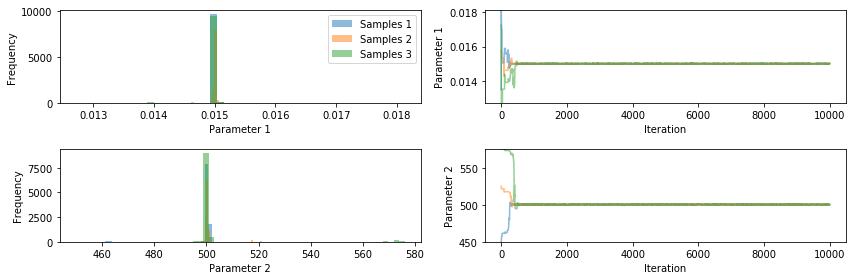

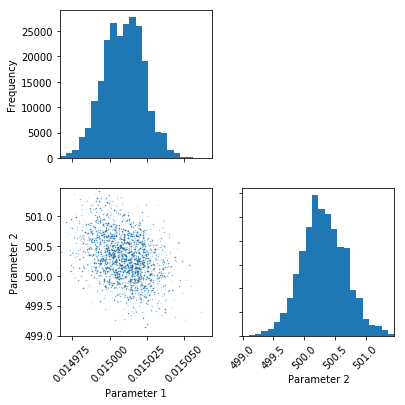

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0019500686516178, 1.0029061255325873]


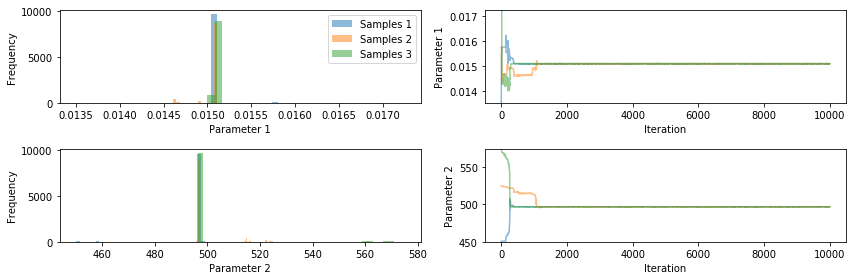

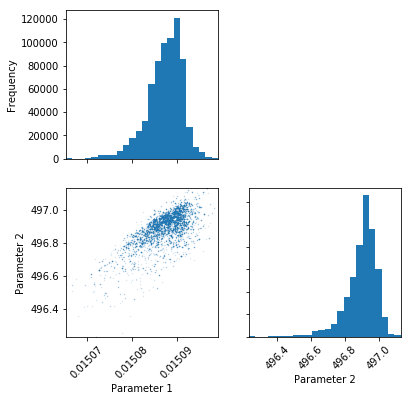

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

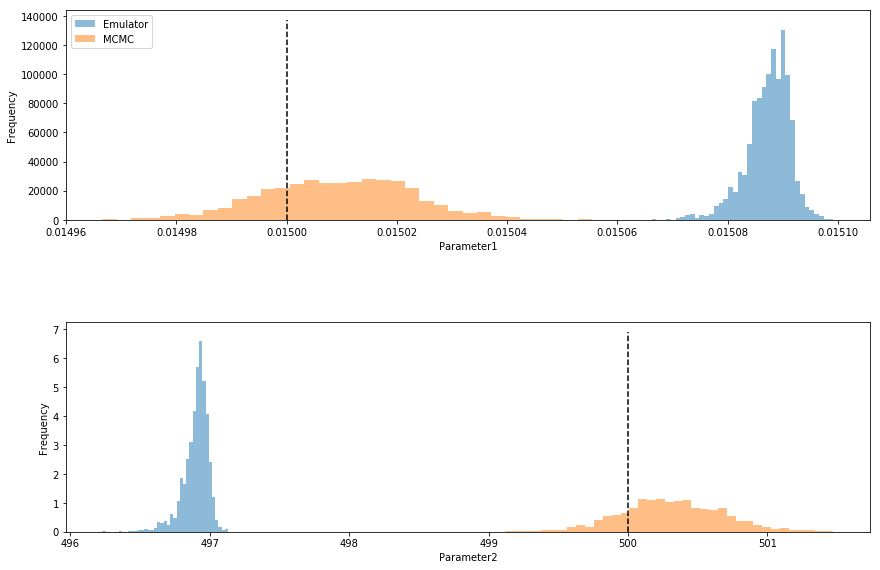

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

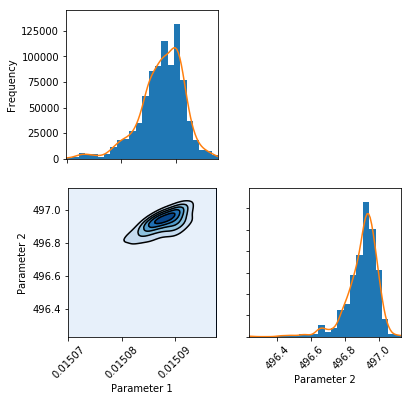

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

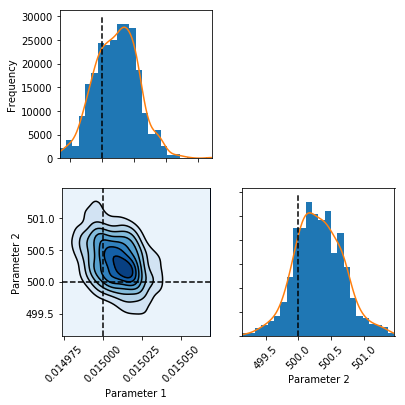

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

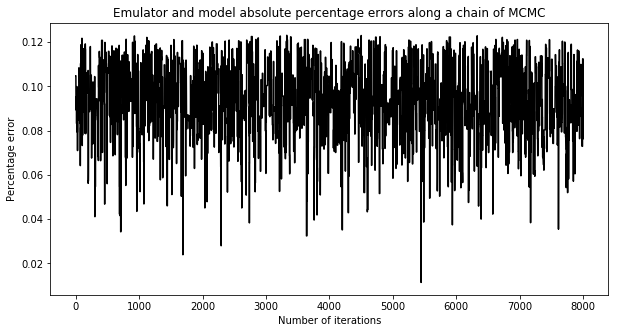

0.09411776344016326

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

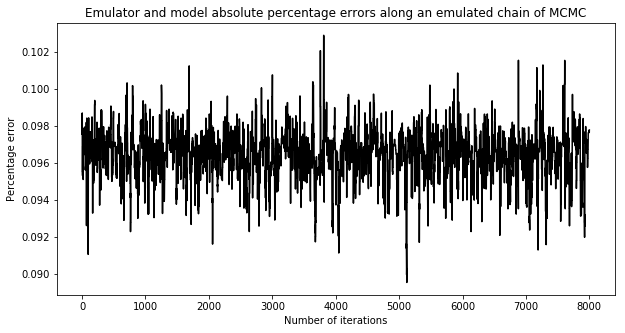

0.0964869570535938

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

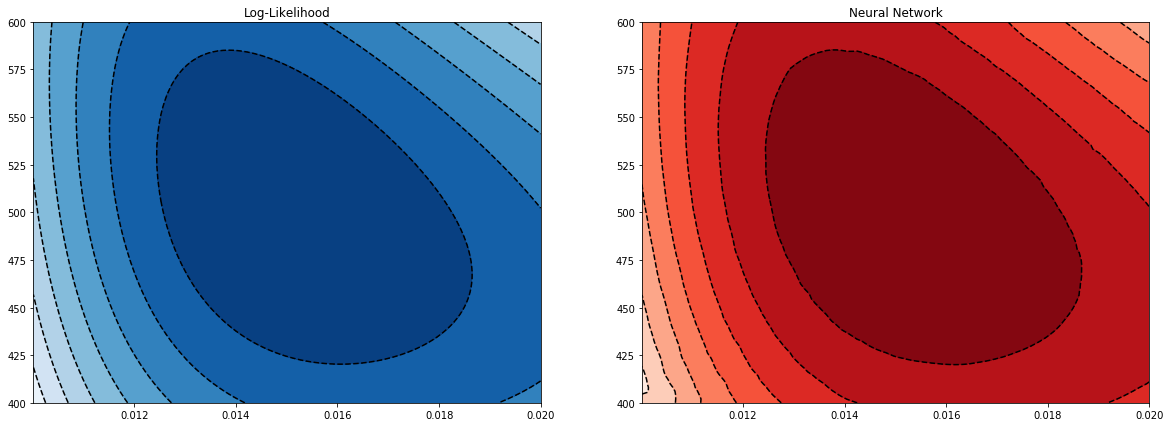

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

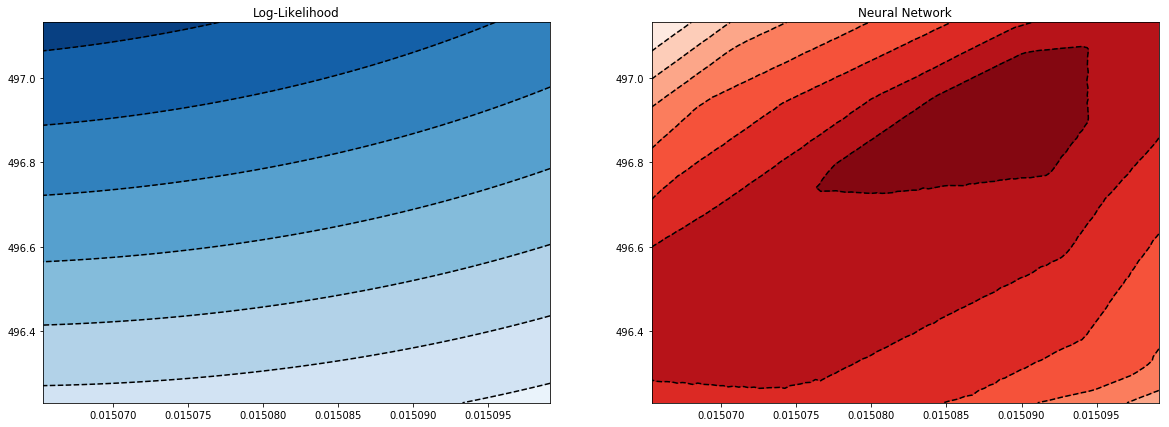

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

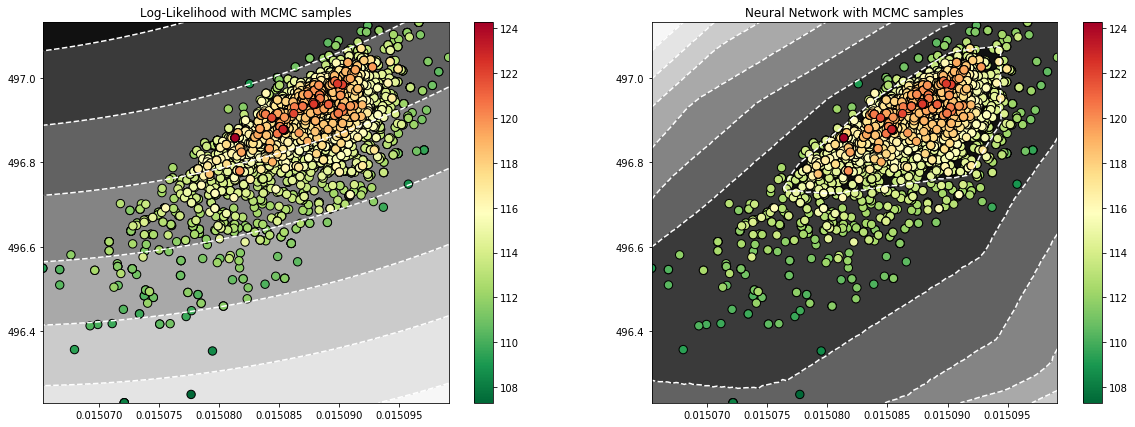

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-1000-5-many-neurons.png", bbox_inches='tight', dpi=600)

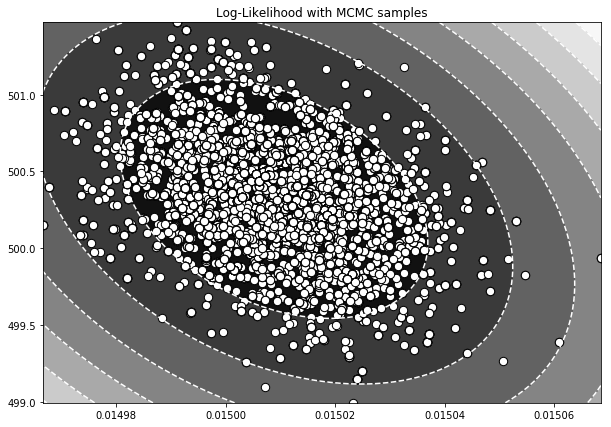

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()